<a href="https://colab.research.google.com/github/Hank-Cui/KWHS2019/blob/master/Long_Score_xgboost_weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# KWHS 2019
# Long Term Score Prediction get weight

In [1]:
# Mount Google Drive

from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
import pandas as pd
import numpy as np
from math import tanh
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

%pip install --upgrade xgboost
import xgboost as xgb
import matplotlib.pyplot as plt

Requirement already up-to-date: xgboost in /usr/local/lib/python3.6/dist-packages (0.90)


In [0]:
# Pandas Settings

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [0]:
# Read the data using Pandsa

df_useful = pd.read_csv('/gdrive/My Drive/Blair/10/KWHS2019/useful_annual(1).csv')
df_otis = pd.read_csv("/gdrive/My Drive/Blair/10/KWHS2019/KWHS_list.csv")

# df_useful = pd.read_csv('/gdrive/My Drive/KWHS2019/useful_annual(1).csv')
# df_otis = pd.read_csv("/gdrive/My Drive/KWHS2019/KWHS_list.csv")

In [0]:
# Returns increased percentages of gross profit

def gross_profit(df_uf):
    d = df_uf.copy()

    gp = np.array(d['gp'], dtype=np.float32)

    annual_growth = np.diff(gp)  # Get annual difference
    growth_rate =  annual_growth / gp[:-1]  # Calculate the annual growth rate
    growth_rate = pd.DataFrame(growth_rate)  # Store the growth rates in pd
    d["gp_ma"] = growth_rate.rolling(window=3).mean()
    d["gp_ma"] = d["gp_ma"].shift(1)

    return d

def revenue_growth(df_uf):  # Return increase percentage
    d = df_uf.copy()
    
    revt = np.array(d['revt'], dtype=np.float32)

    annual_growth = np.diff(revt)  # Get annual difference
    growth_rate =  annual_growth / revt[:-1]  # Calculate the annual growth rate
    growth_rate = pd.DataFrame(growth_rate)  # Store the growth rates in pd
    d["revt_ma"] = growth_rate.rolling(window=3).mean()
    d["revt_ma"] = d["revt_ma"].shift(1)

    return d

def free_cash_flow(df_uf):  # Returns increased percentages 
    d = df_uf.copy()

    oancf = np.array(d['oancf'], dtype=np.float32)
    capx = np.array(d['capx'], dtype=np.float32)
    
    diff = oancf-capx

    annual_growth = np.diff(diff)  # Get annual difference
    growth_rate =  annual_growth / diff[:-1]  # Calculate the annual growth rate
    growth_rate = pd.DataFrame(growth_rate)  # Store the growth rates in pd
    d["cash_flow_ma"] = growth_rate.rolling(window=3).mean()
    d["cash_flow_ma"] = d["cash_flow_ma"].shift(1)

    return d

def ebit(df_uf):  # Finalized. Returns increased percentages
    d = df_uf.copy()
    
    ebit = np.array(d['ebit'], dtype=np.float32)

    annual_growth = np.diff(ebit)  # Get annual difference
    growth_rate =  annual_growth / ebit[:-1]  # Calculate the annual growth rate
    growth_rate = pd.DataFrame(growth_rate)  # Store the growth rates in pd
    d["ebit_ma"] = growth_rate.rolling(window=3).mean()
    d["ebit_ma"] = d["ebit_ma"].shift(1)

    return d

def optdr(df_uf):  # Finalized Returns increased percentages
    d = df_uf.copy()
    
    optdr = np.array(d['optdr'], dtype=np.float32)

    annual_growth = np.diff(optdr)  # Get annual difference
    growth_rate =  annual_growth / optdr[:-1]  # Calculate the annual growth rate
    growth_rate = pd.DataFrame(growth_rate)  # Store the growth rates in pd
    d["optdr_ma"] = growth_rate.rolling(window=3).mean()
    d["optdr_ma"] = d["optdr_ma"].shift(1)

    return d

In [0]:
def roa(df_uf):  # Returns average yearly values
    d = df_uf.copy()

    ni = np.array(d['ni'], dtype=np.float32)
    at = np.array(d['at'], dtype=np.float32)
    lt = np.array(d['lt'], dtype=np.float32)

    roa = ni/abs(at-lt)

    growth_rate = pd.DataFrame(roa)  # Store the growth rates in pd
    d["roa_growth_rate"] = growth_rate.rolling(window=3).mean()

    return d

In [0]:
def fundamentals(company_name):

    df_u = df_useful[df_useful['tic']==company_name]
    df_u = df_u.dropna(subset = ['gp'])  # Drop the rows that have no data
    df_u = df_u.fillna(0)
    df_u = df_u.reset_index()

    df_u = gross_profit(df_u)
    df_u = free_cash_flow(df_u)
    df_u = revenue_growth(df_u)
    df_u = ebit(df_u)
    df_u = optdr(df_u)
    df_u = roa(df_u)

    return df_u.drop(columns='tic')

In [0]:
def get_annual_close(comp_tic):
    df = pd.read_csv("/gdrive/My Drive/Blair/10/KWHS2019/hist_data/"+comp_tic+".csv")
    dl = df["Date"].tolist()
    dates = []
    d_list = dl
    for i in range(1019):
        year = str(1000+i)
        if year+"-12-31" in d_list:
            dates.append(year+"-12-31")
            continue
        elif year+"-12-30" in d_list:
            dates.append(year+"-12-30")
            continue
        elif year+"-12-29" in d_list:
            dates.append(year+"-12-29")
            continue
    data = df[df['Date'].isin(dates)]
    data = np.array(data['Close'])
    return data

In [0]:
# param['gpu_id'] = 0
# param['tree_method'] = 'gpu_hist'
# tree_method='gpu_hist', 
# gpu_id=0

**XBG Model**

In [0]:
def get_Weight(comp_tic):
    fundamental = fundamentals(comp_tic)[["gp_ma", "cash_flow_ma", "revt_ma", "ebit_ma", "roa_growth_rate"]]
    size = len(fundamental)

    close_price = get_annual_close(comp_tic)
    close_price = np.pad(close_price, (size-len(close_price), 0), 'constant', constant_values=(0))
    fundamental["annual_close"] = close_price

    df_close = fundamental["annual_close"]
    df_fundamentals = fundamental.drop(columns="annual_close")

    sc_y = MinMaxScaler(feature_range = (0, 1))
    y_scaled = pd.DataFrame(sc_y.fit_transform(df_close.values.reshape(-1, 1)), columns=["annual_close"])

    sc_x = MinMaxScaler(feature_range = (0, 1))
    x_scaled = pd.DataFrame(sc_x.fit_transform(df_fundamentals), columns=df_fundamentals.columns)
    
    y = y_scaled
    X = x_scaled

    # X_train_FI, X_test_FI, y_train_FI, y_test_FI = train_test_split(X, y, test_size=0.33, shuffle=False)

    regressor = xgb.XGBRegressor(gamma=0.0,
                                n_estimators=1500,
                                base_score=0.6,
                                colsample_bytree=1,
                                learning_rate=0.01)

    xgbModel = regressor.fit(X, y, \
                             early_stopping_rounds=10, \
                             eval_set = [(X, y), (X, y)], \
                             verbose=False)

    eval_result = regressor.evals_result()
    training_rounds = range(len(eval_result['validation_0']['rmse']))

    plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
    plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.title('Training Vs Validation Error')
    plt.legend()
    plt.show() 

    fig = plt.figure(figsize=(8,8))
    plt.xticks(rotation='vertical')
    plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X.columns)
    plt.title('Figure 6: Feature importance of the technical indicators.')
    plt.savefig("/gdrive/My Drive/Blair/10/KWHS2019/Long_weights/"+comp_tic+".png")
    plt.show()

    return xgbModel.feature_importances_.tolist()

  0%|          | 0/507 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:35:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


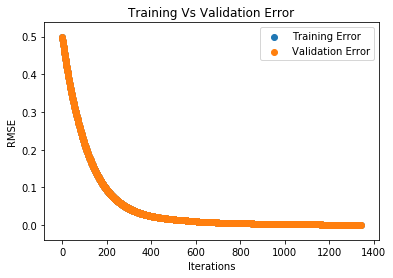

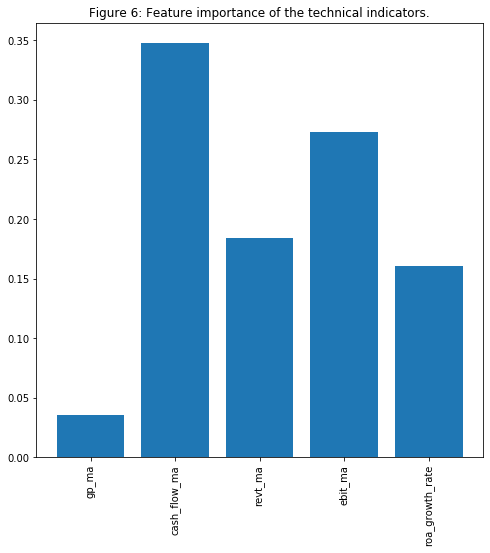

  1%|          | 3/507 [00:02<06:06,  1.38it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


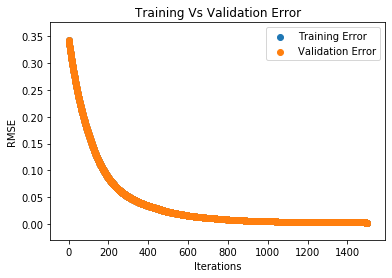

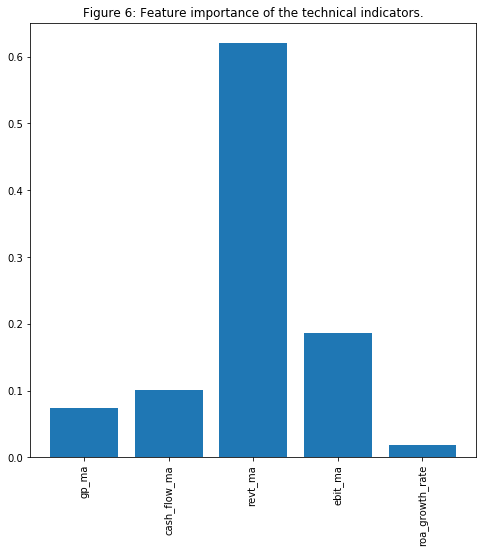

  1%|          | 5/507 [00:05<09:08,  1.09s/it]

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


[15:35:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


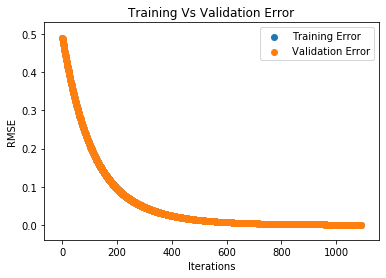

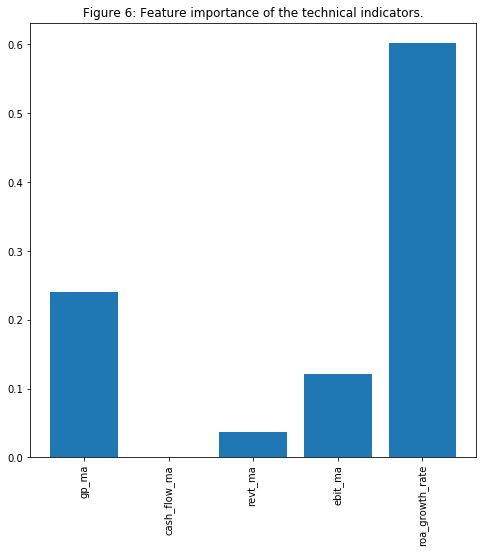

  1%|          | 6/507 [00:07<11:06,  1.33s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


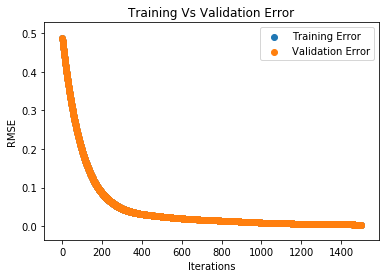

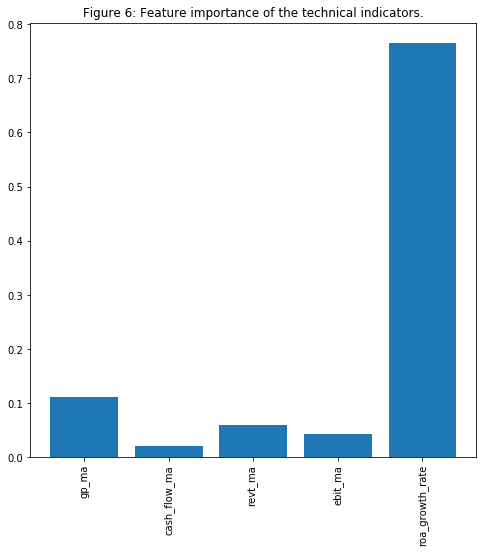

  1%|▏         | 7/507 [00:09<14:19,  1.72s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:35:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


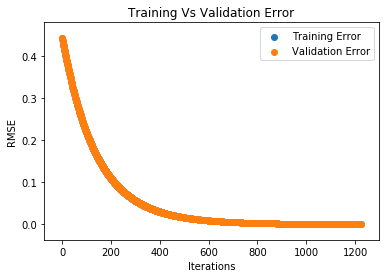

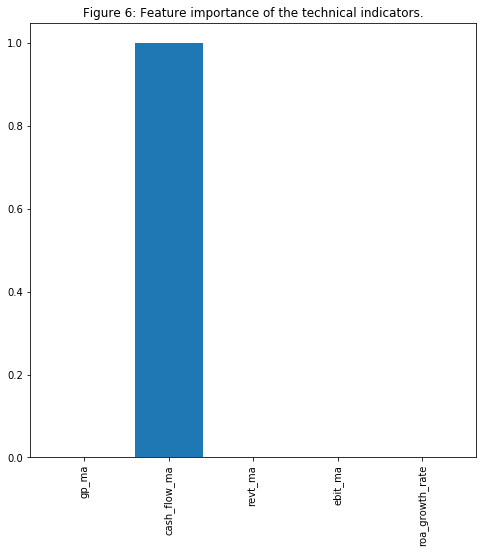

  2%|▏         | 10/507 [00:11<11:42,  1.41s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:35:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


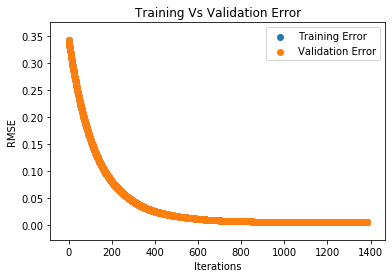

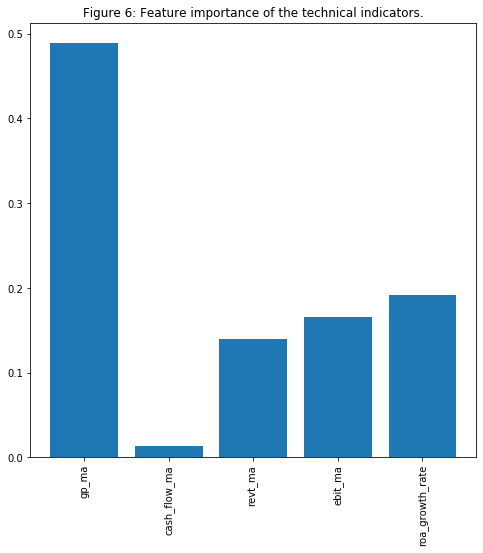

  2%|▏         | 12/507 [00:14<10:46,  1.31s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


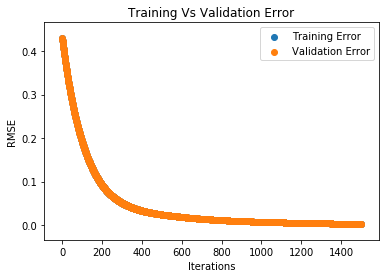

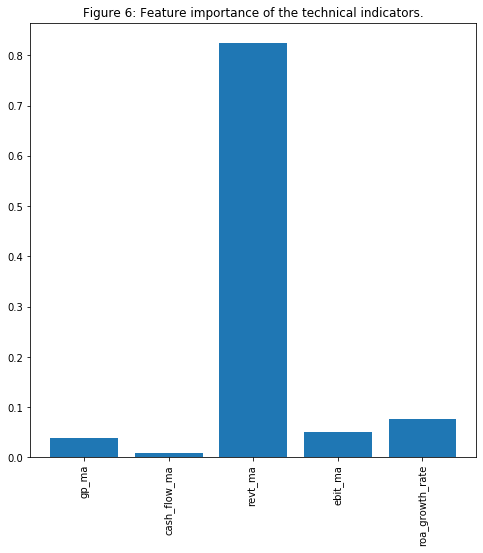

  3%|▎         | 13/507 [00:16<13:42,  1.66s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


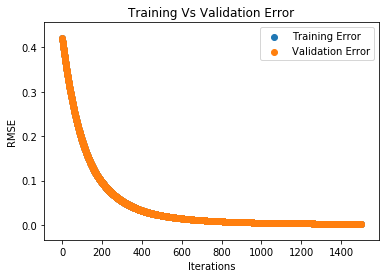

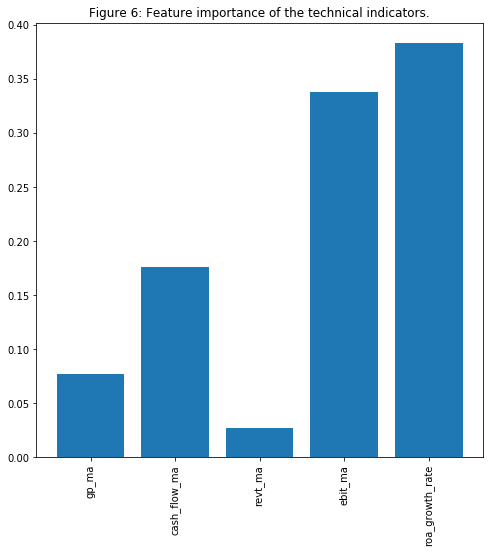

  3%|▎         | 14/507 [00:18<15:32,  1.89s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


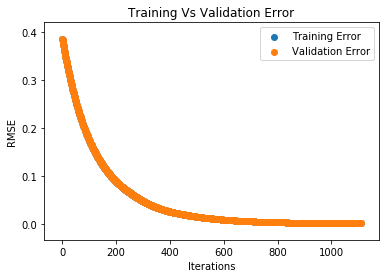

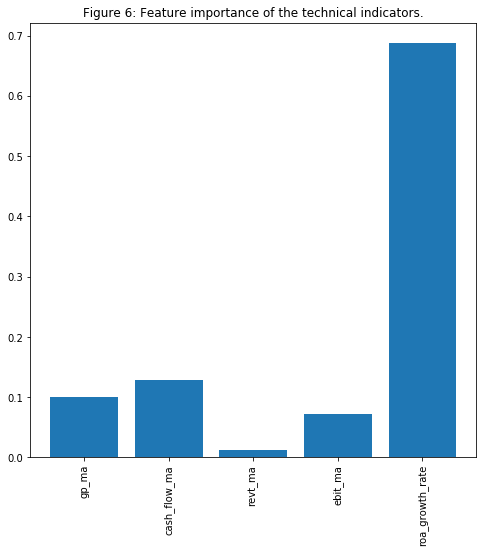

  3%|▎         | 16/507 [00:20<13:16,  1.62s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


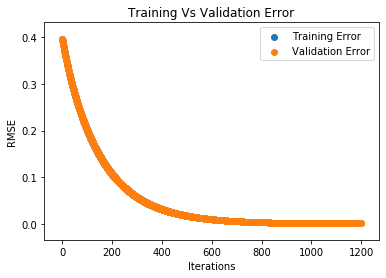

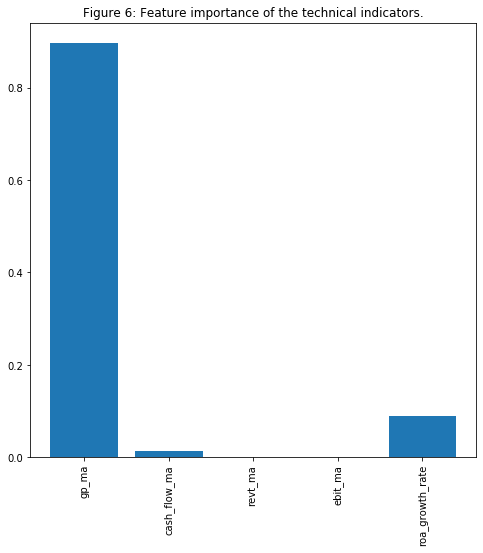

  3%|▎         | 17/507 [00:24<17:39,  2.16s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


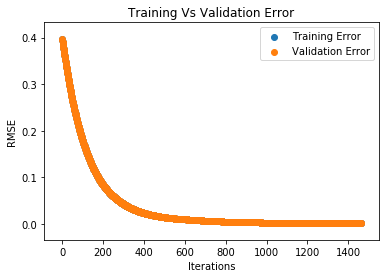

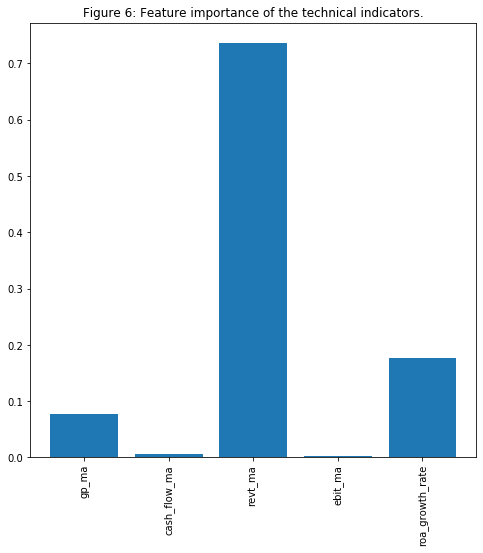

  4%|▎         | 18/507 [00:26<17:46,  2.18s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


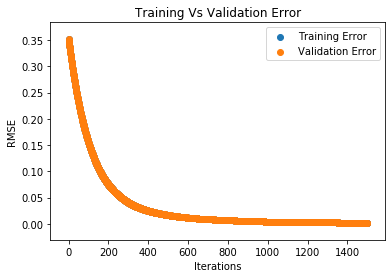

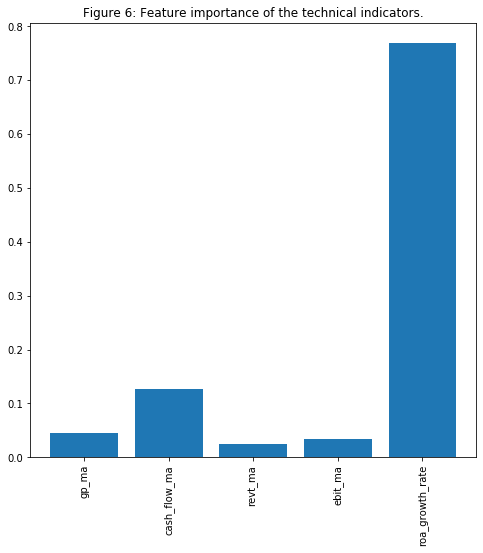

  4%|▍         | 20/507 [00:29<15:00,  1.85s/it]

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


[15:35:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


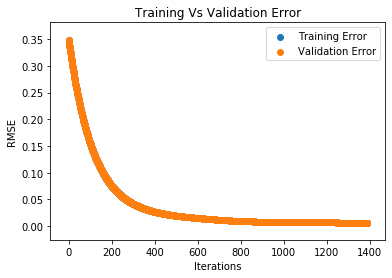

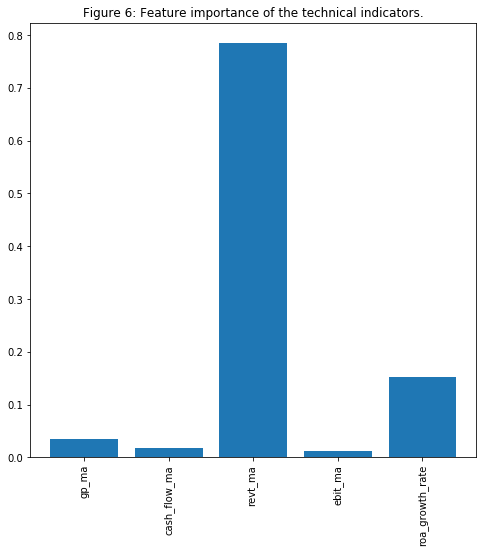

  4%|▍         | 21/507 [00:32<16:03,  1.98s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


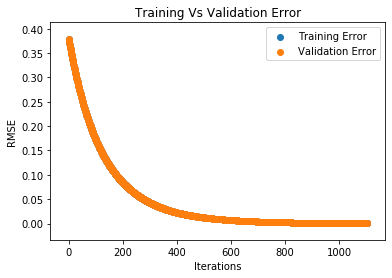

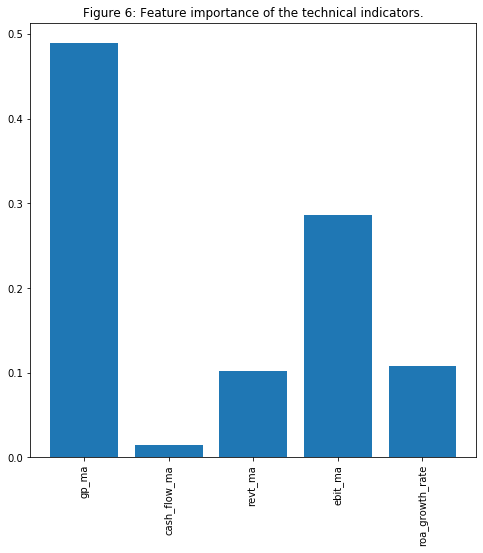

  5%|▍         | 24/507 [00:34<12:50,  1.59s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


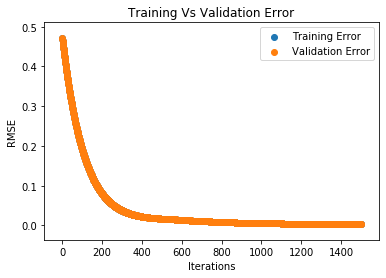

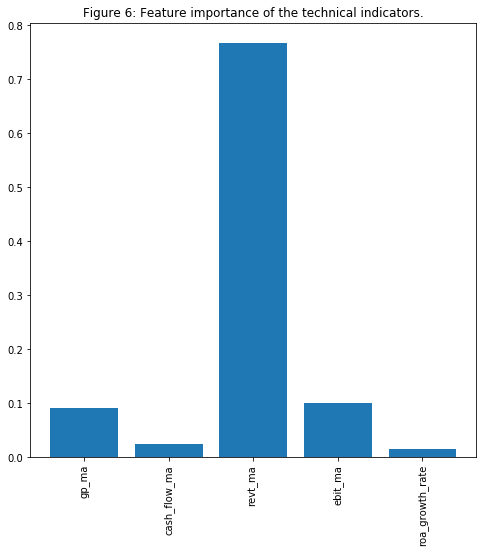

  5%|▍         | 25/507 [00:36<14:30,  1.81s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


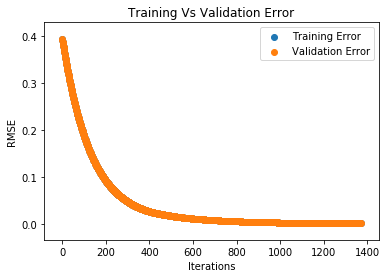

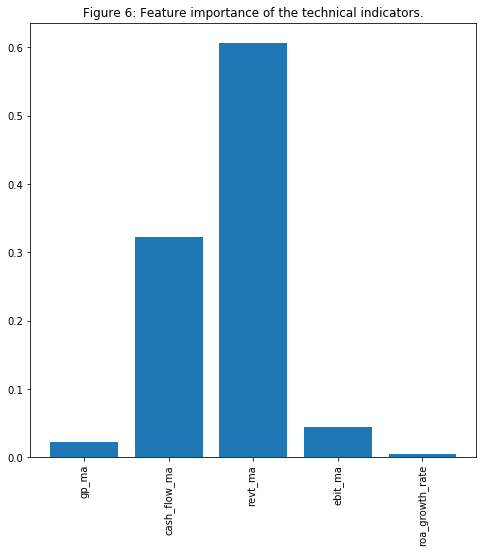

  5%|▌         | 26/507 [00:38<15:27,  1.93s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
  5%|▌         | 27/507 [00:39<12:51,  1.61s/it]

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


[15:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


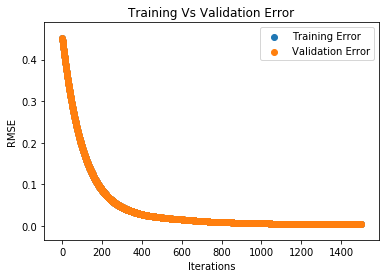

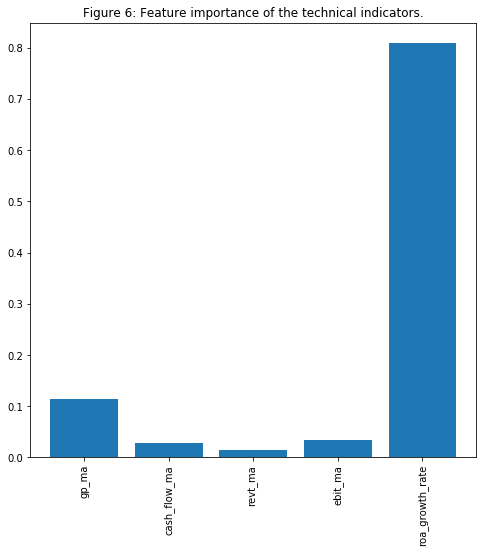

  6%|▌         | 28/507 [00:41<14:29,  1.81s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


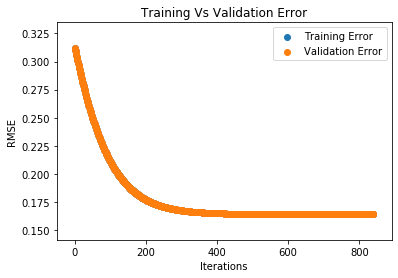

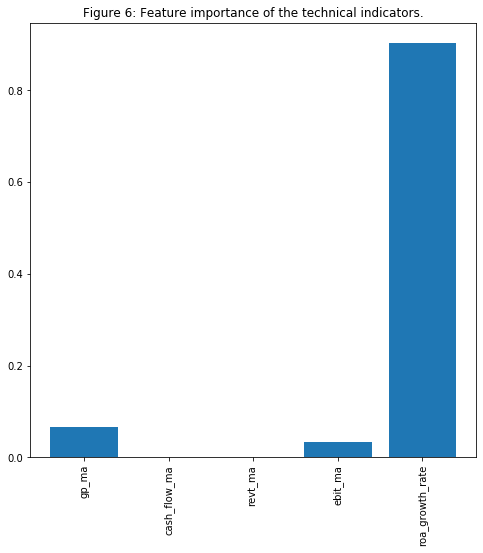

  6%|▌         | 29/507 [00:43<14:24,  1.81s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


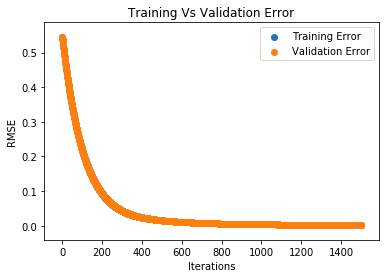

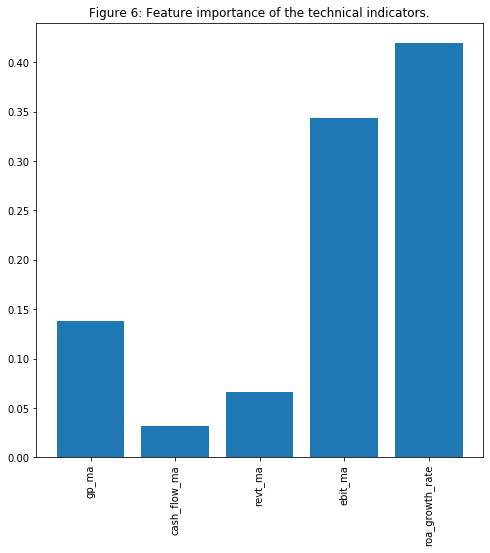

  6%|▌         | 30/507 [00:45<14:54,  1.87s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


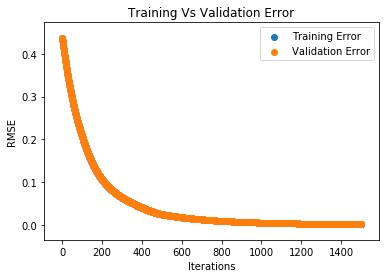

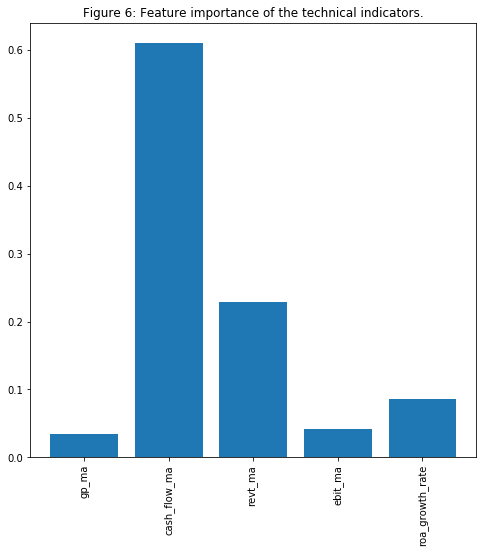

  6%|▌         | 31/507 [00:48<16:08,  2.03s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


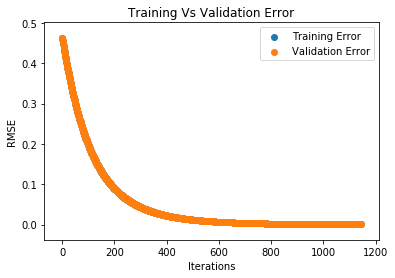

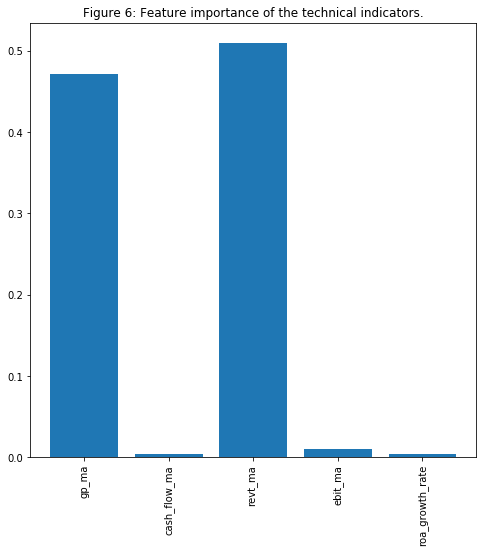

  6%|▋         | 32/507 [00:50<15:47,  1.99s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


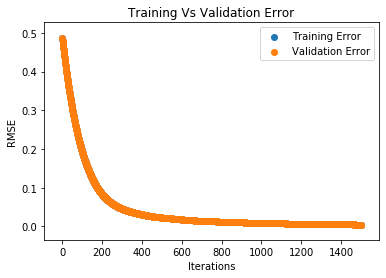

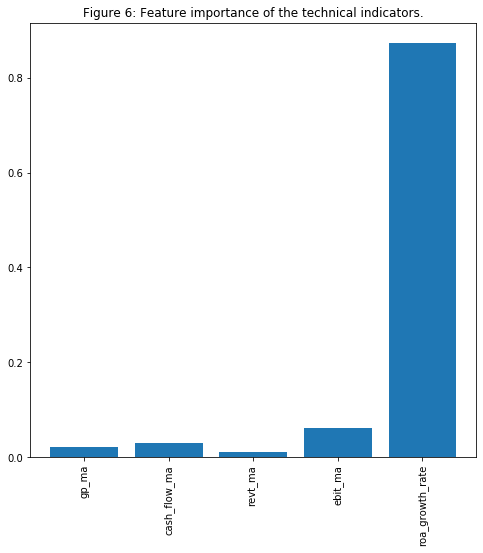

  7%|▋         | 33/507 [00:52<17:00,  2.15s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


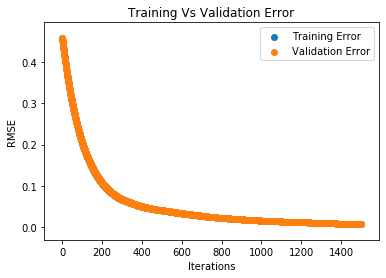

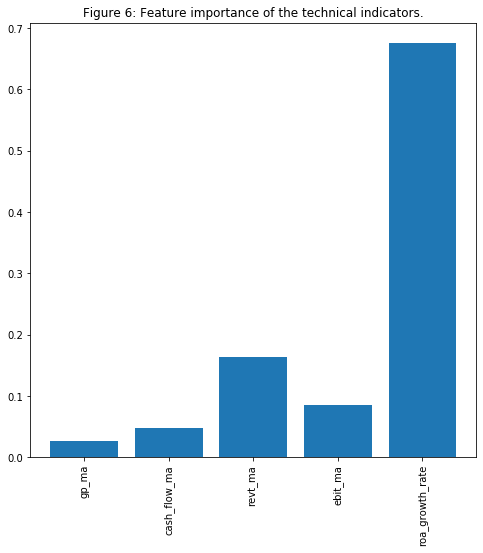

  7%|▋         | 34/507 [00:55<19:09,  2.43s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:36:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


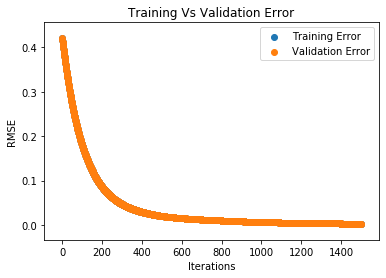

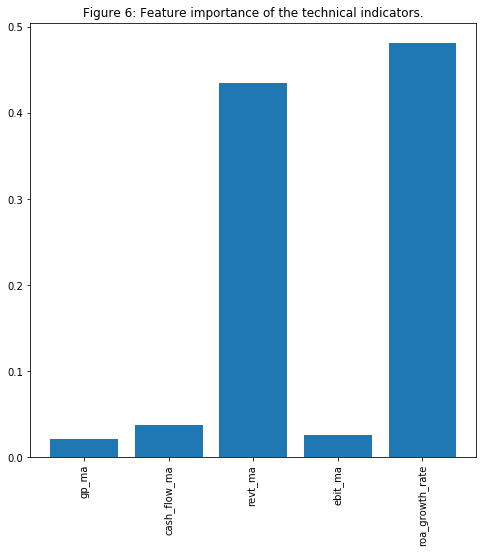

  7%|▋         | 35/507 [00:58<19:02,  2.42s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:36:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


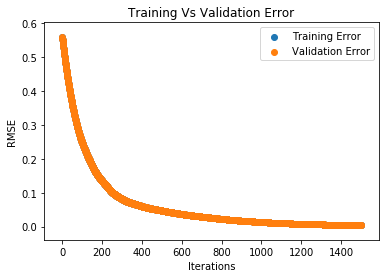

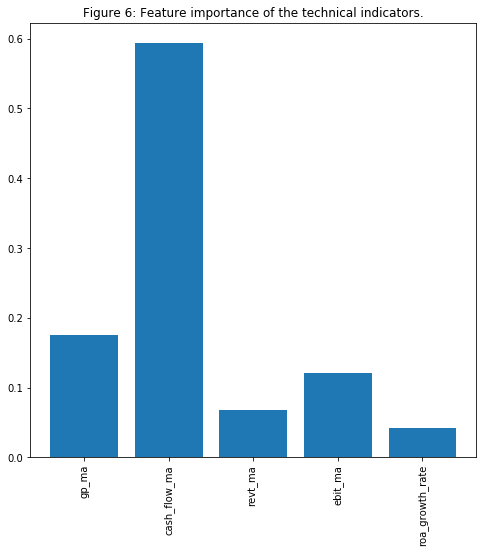

  7%|▋         | 36/507 [01:00<18:08,  2.31s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:36:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


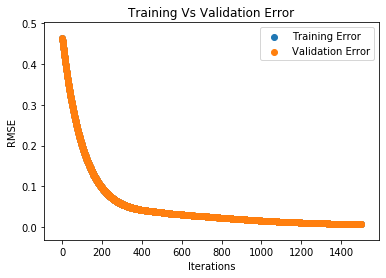

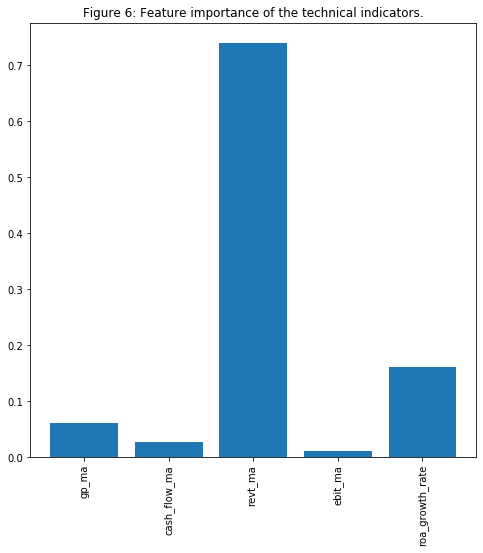

  7%|▋         | 38/507 [01:03<16:20,  2.09s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:36:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


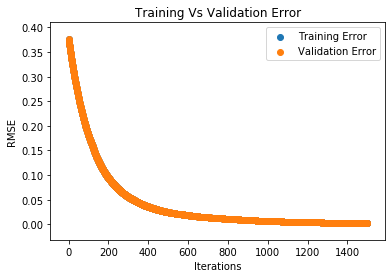

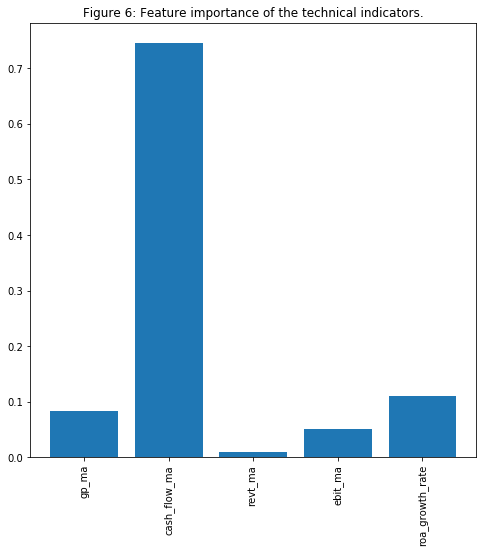

  8%|▊         | 39/507 [01:05<16:59,  2.18s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


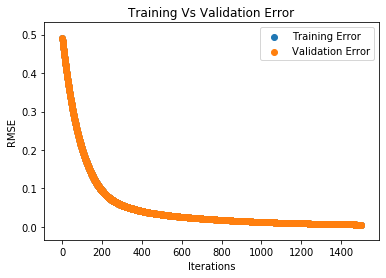

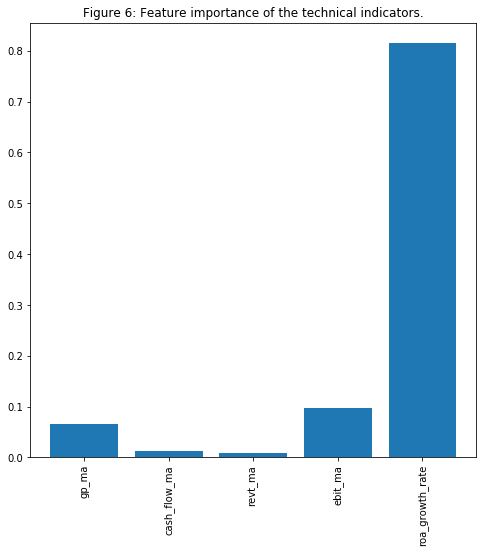

  8%|▊         | 40/507 [01:07<16:59,  2.18s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:36:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


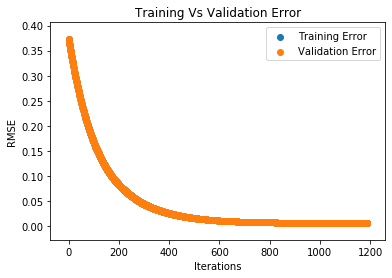

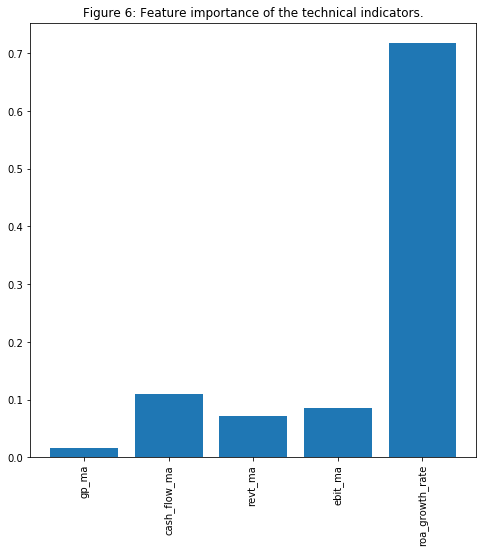

  8%|▊         | 42/507 [01:10<14:28,  1.87s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:36:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


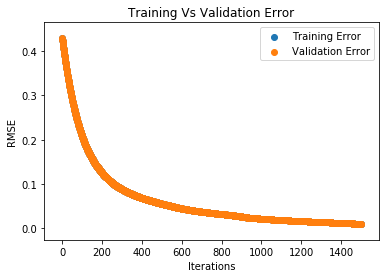

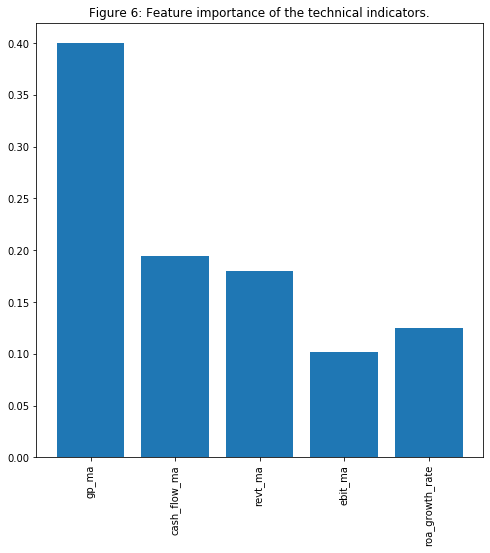

  8%|▊         | 43/507 [01:12<15:52,  2.05s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:36:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


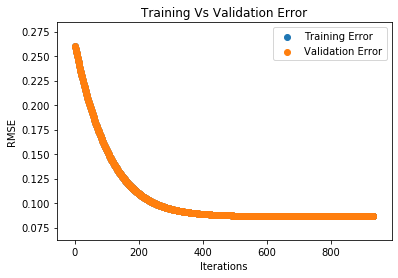

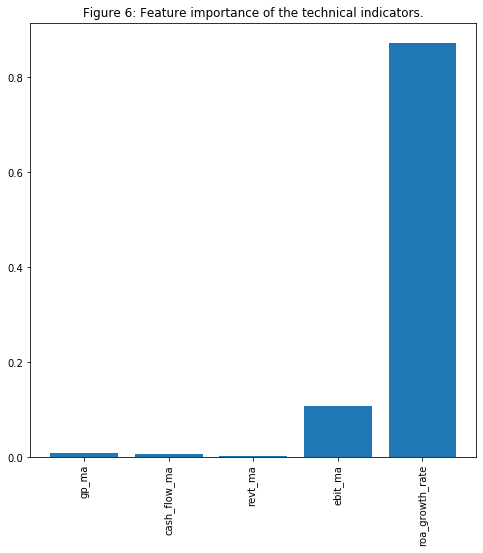

  9%|▉         | 45/507 [01:14<13:19,  1.73s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:36:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


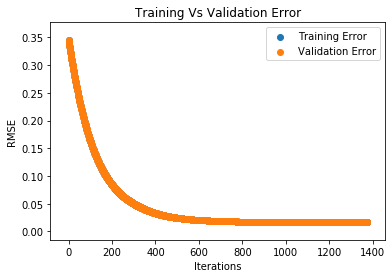

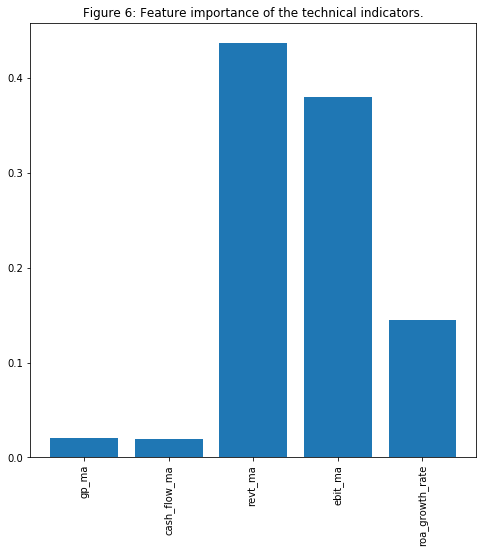

  9%|▉         | 46/507 [01:17<14:53,  1.94s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:36:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


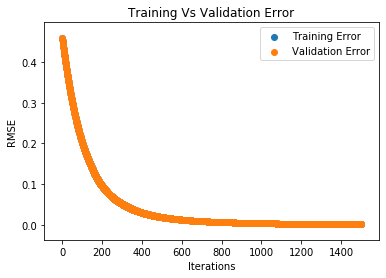

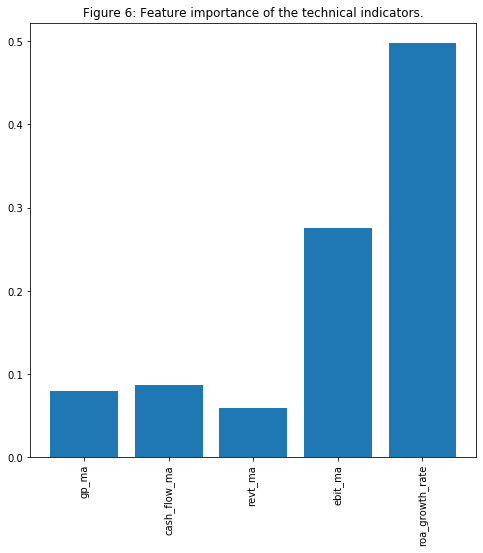

  9%|▉         | 47/507 [01:19<15:24,  2.01s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:36:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


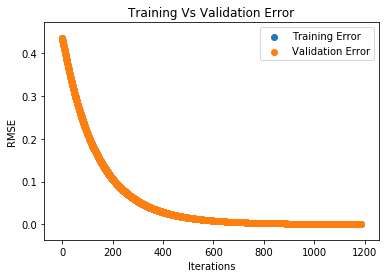

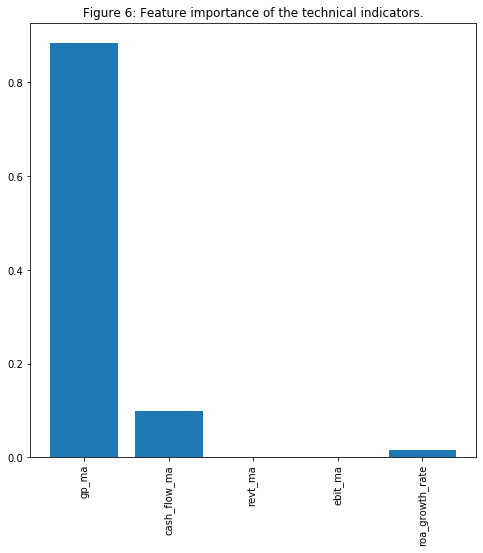

 10%|▉         | 50/507 [01:21<12:15,  1.61s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:36:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


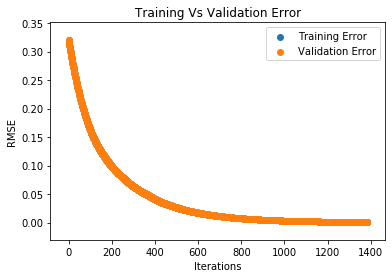

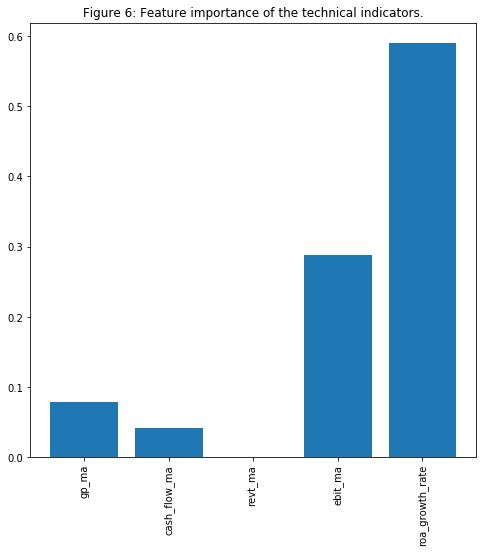

 10%|█         | 51/507 [01:23<13:27,  1.77s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:36:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


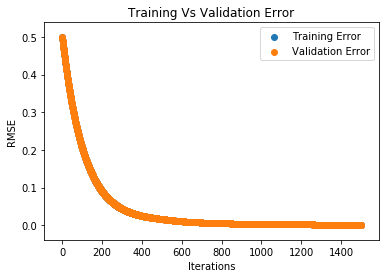

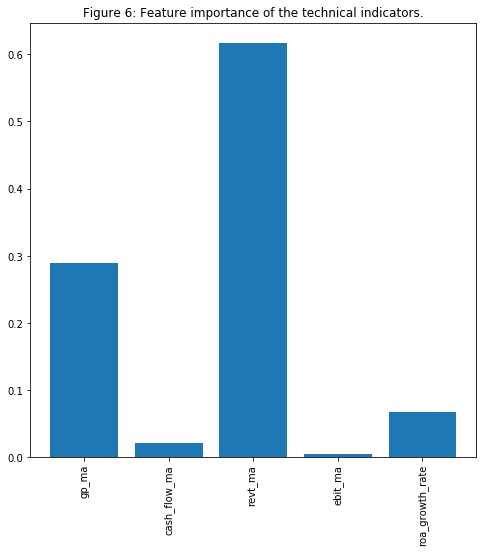

 11%|█         | 55/507 [01:25<10:24,  1.38s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
1
1
[15:36:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


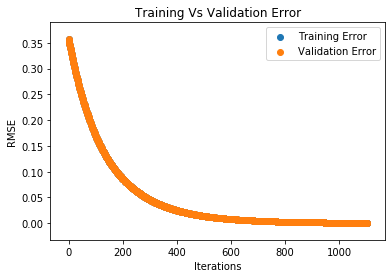

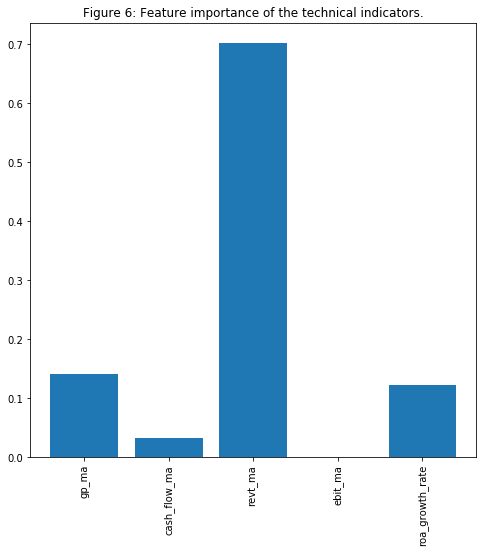

 11%|█         | 57/507 [01:27<09:28,  1.26s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


[15:36:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


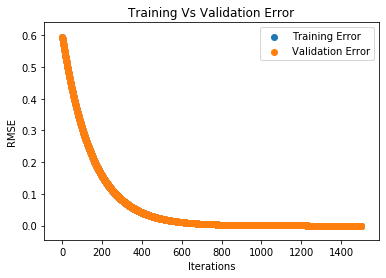

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


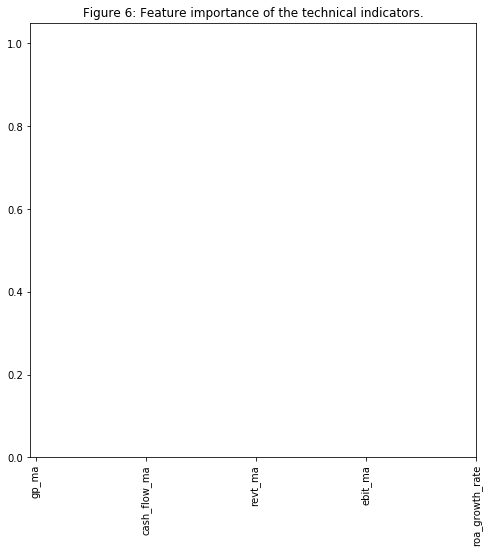

 11%|█▏        | 58/507 [01:29<10:49,  1.45s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


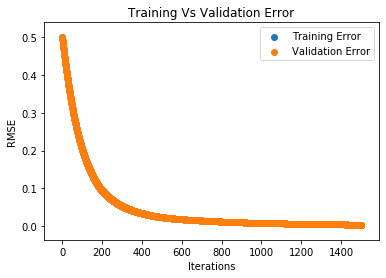

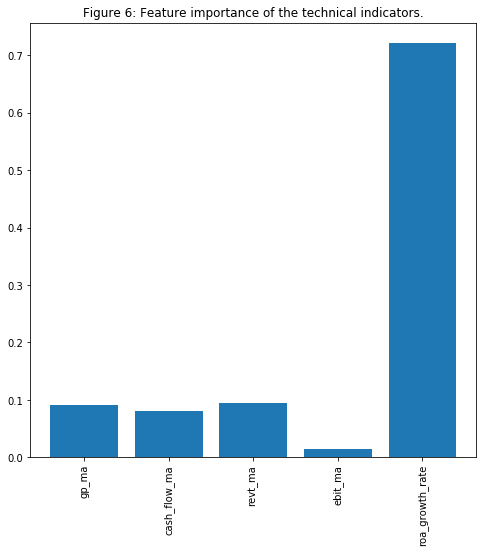

 12%|█▏        | 59/507 [01:31<12:26,  1.67s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:36:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


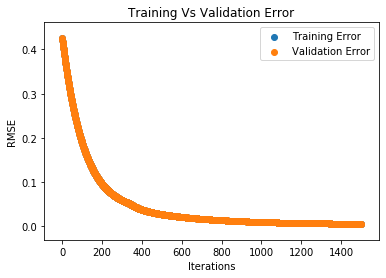

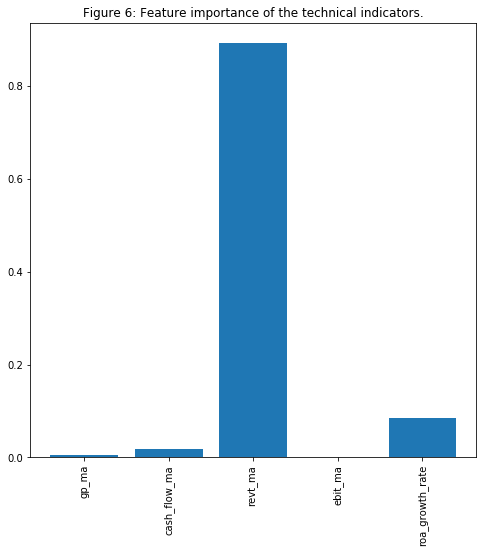

 12%|█▏        | 62/507 [01:34<10:17,  1.39s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


1
[15:36:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


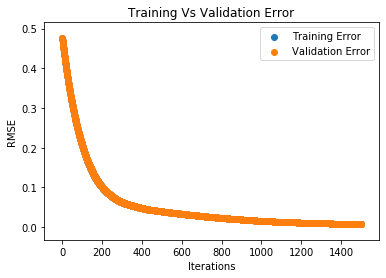

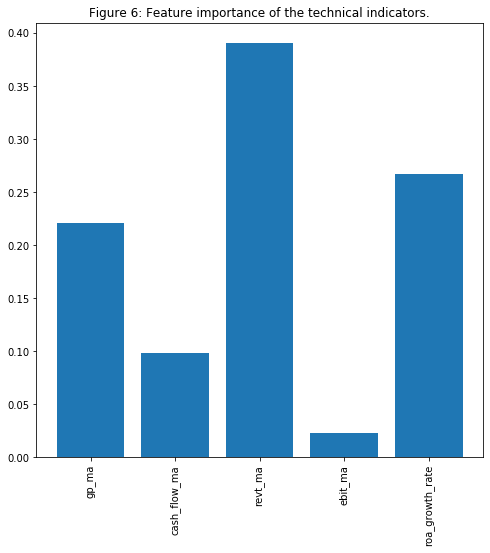

 13%|█▎        | 64/507 [01:36<09:51,  1.33s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:36:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


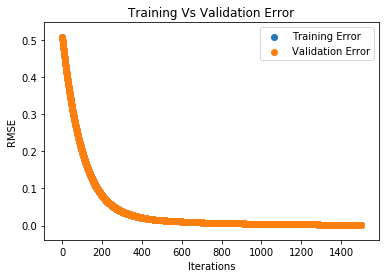

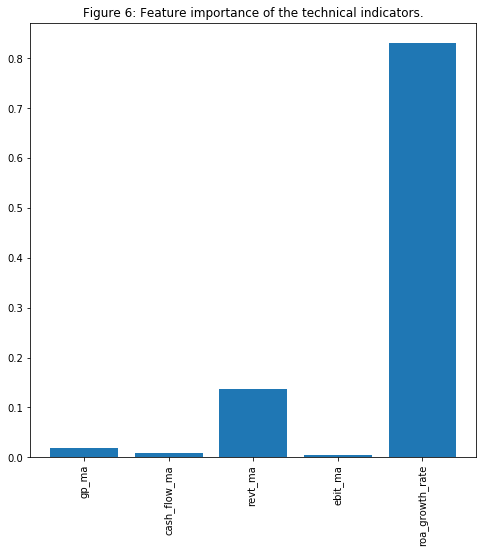

 13%|█▎        | 65/507 [01:38<12:04,  1.64s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


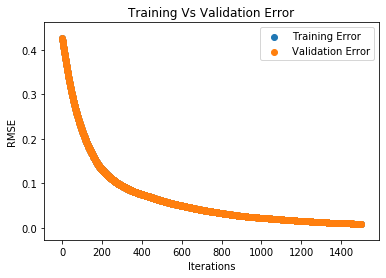

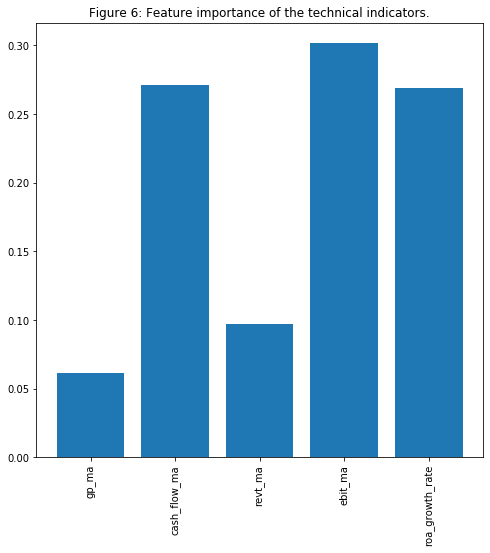

 13%|█▎        | 67/507 [01:41<11:22,  1.55s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:36:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


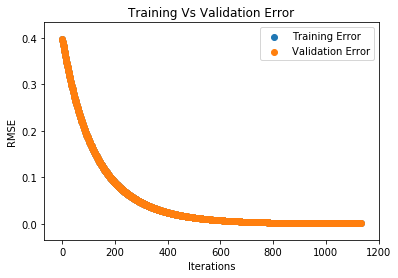

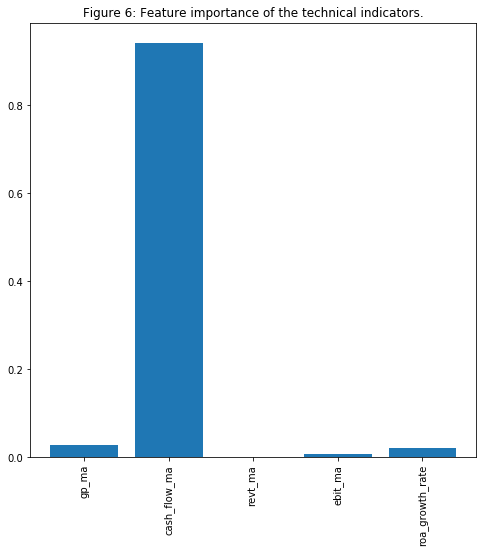

 13%|█▎        | 68/507 [01:43<12:21,  1.69s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:36:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


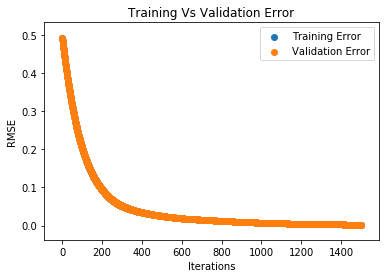

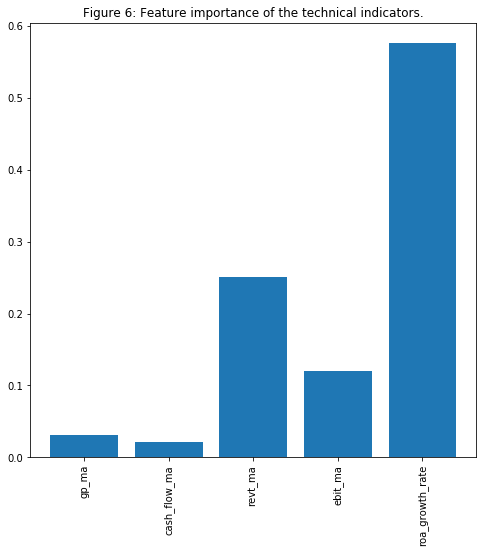

 14%|█▍        | 70/507 [01:45<11:02,  1.52s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:36:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


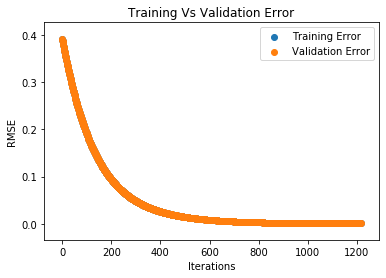

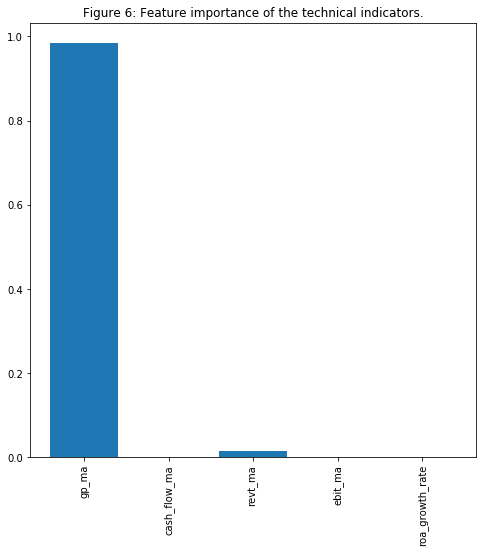

 14%|█▍        | 71/507 [01:47<11:36,  1.60s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:36:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


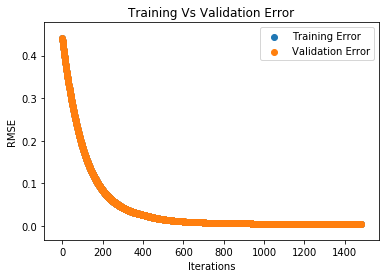

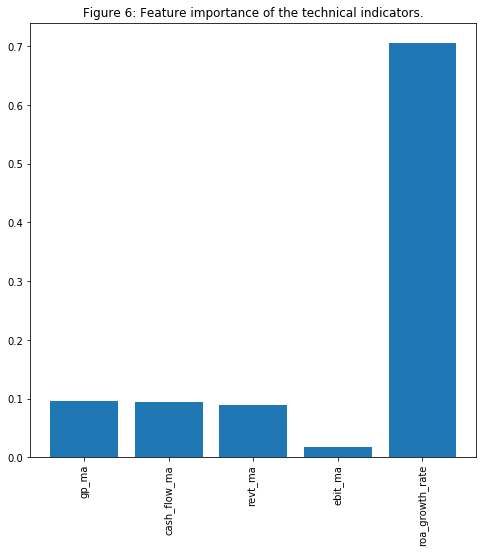

 14%|█▍        | 73/507 [01:50<10:43,  1.48s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
 15%|█▍        | 74/507 [01:50<09:24,  1.30s/it]

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


[15:36:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


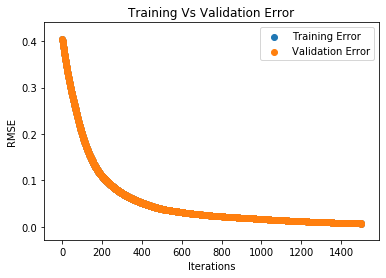

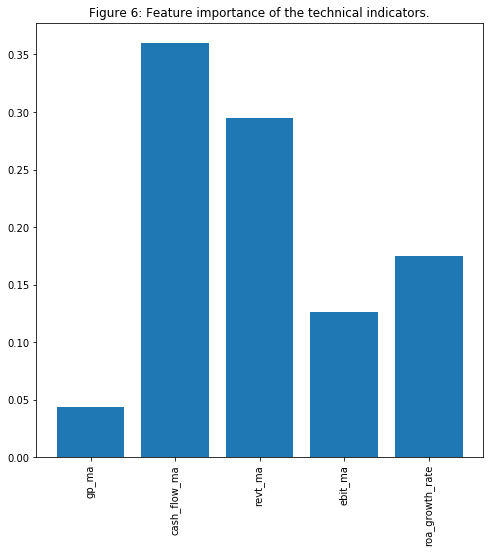

 15%|█▍        | 75/507 [01:53<11:55,  1.66s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:36:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


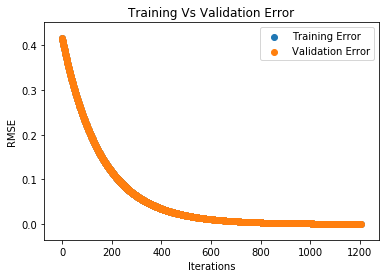

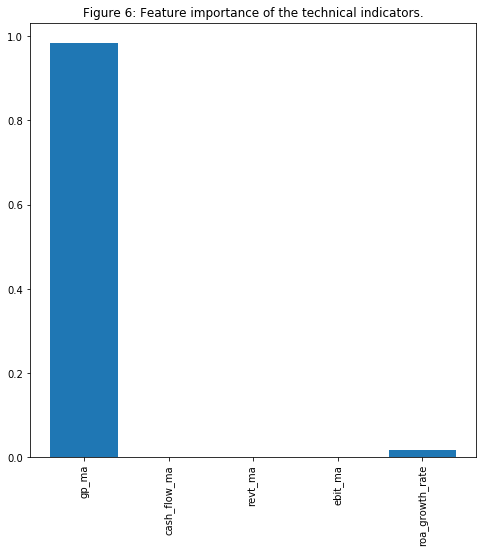

 15%|█▍        | 76/507 [01:55<12:27,  1.74s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


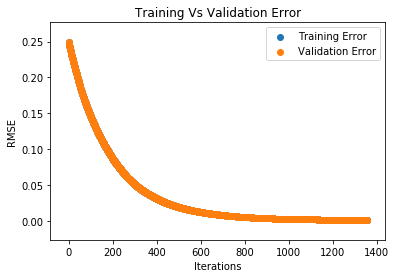

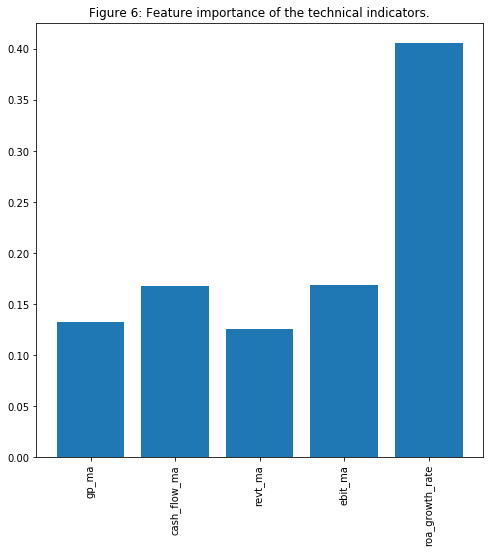

 15%|█▌        | 77/507 [01:57<13:14,  1.85s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


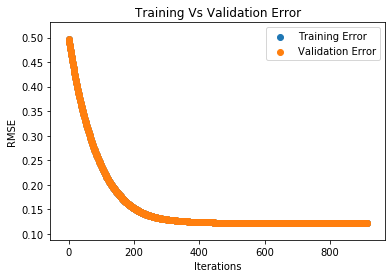

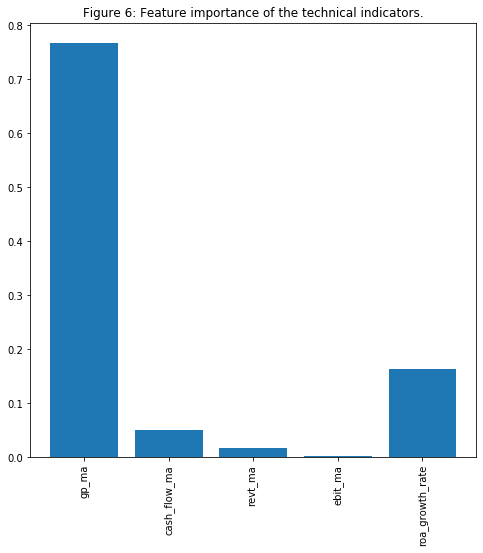

 15%|█▌        | 78/507 [01:59<13:33,  1.90s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:37:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


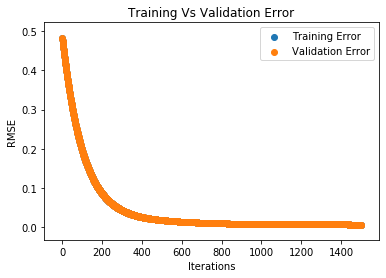

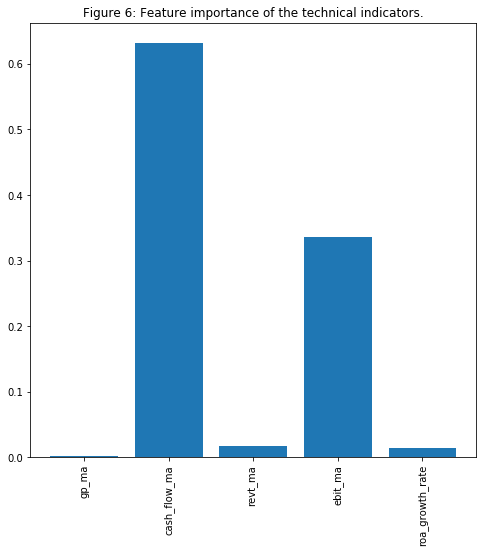

 16%|█▌        | 80/507 [02:01<11:45,  1.65s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


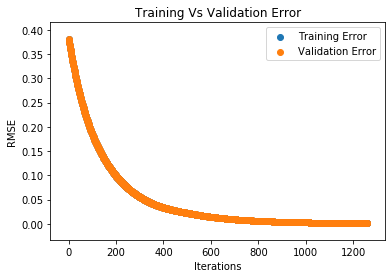

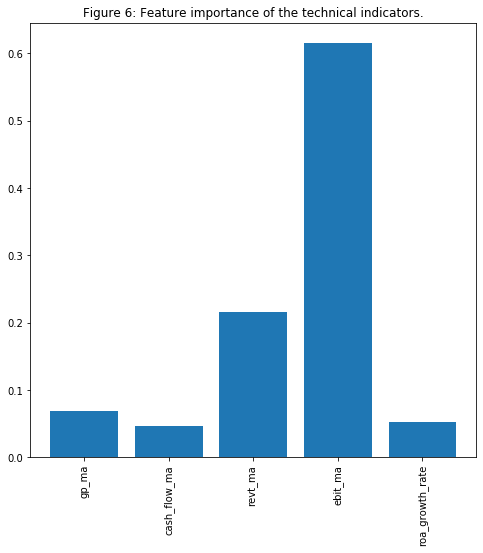

 16%|█▌        | 81/507 [02:03<12:38,  1.78s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


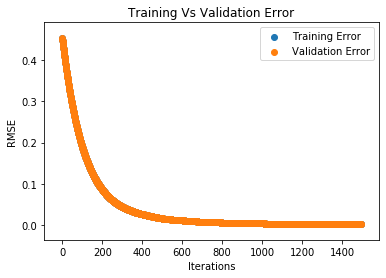

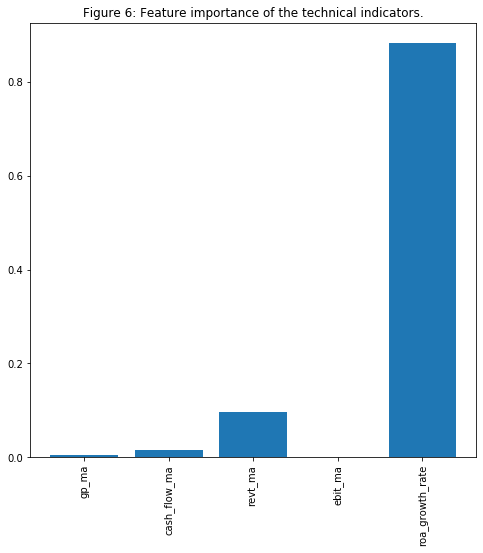

 16%|█▌        | 82/507 [02:05<13:14,  1.87s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


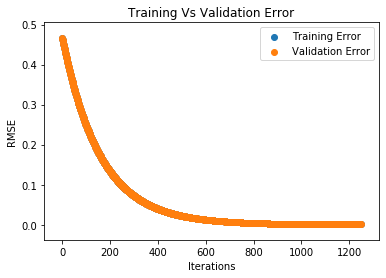

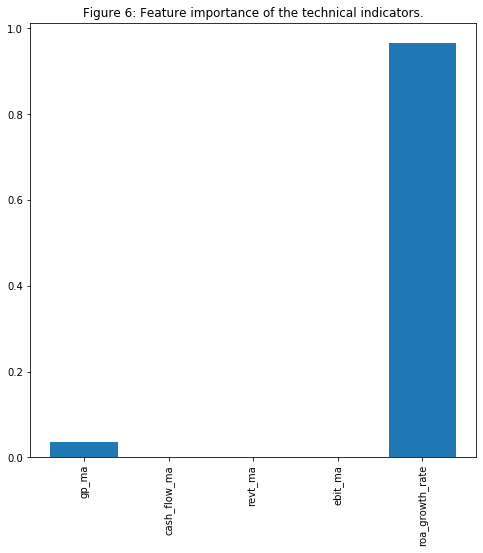

 16%|█▋        | 83/507 [02:07<13:26,  1.90s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


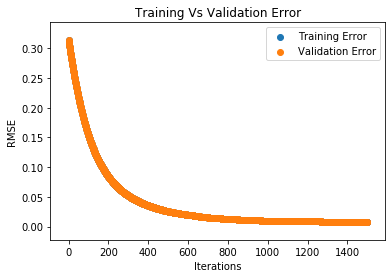

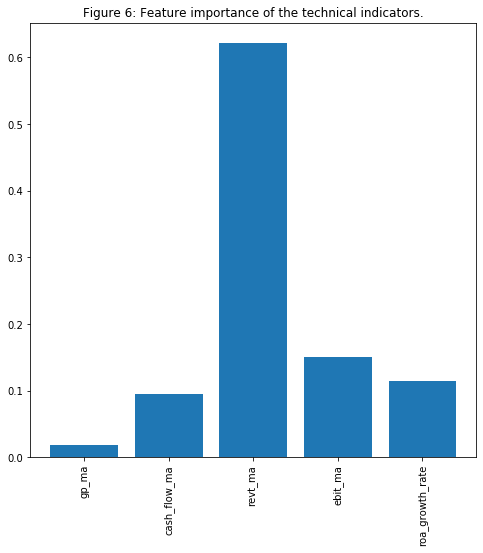

 17%|█▋        | 84/507 [02:10<14:30,  2.06s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


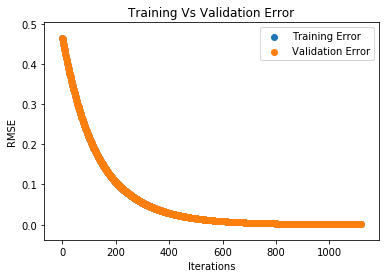

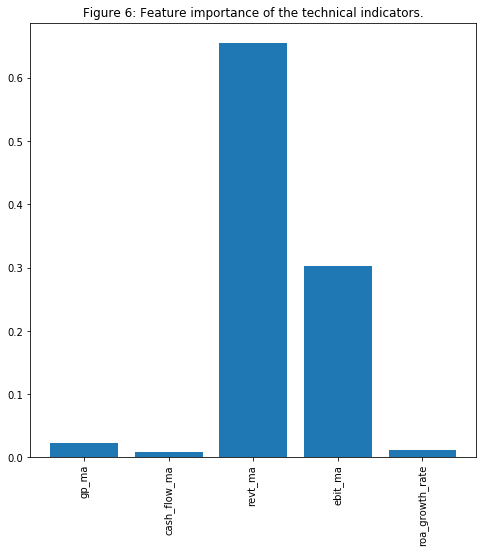

 17%|█▋        | 85/507 [02:12<14:12,  2.02s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


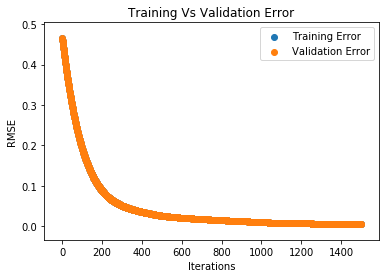

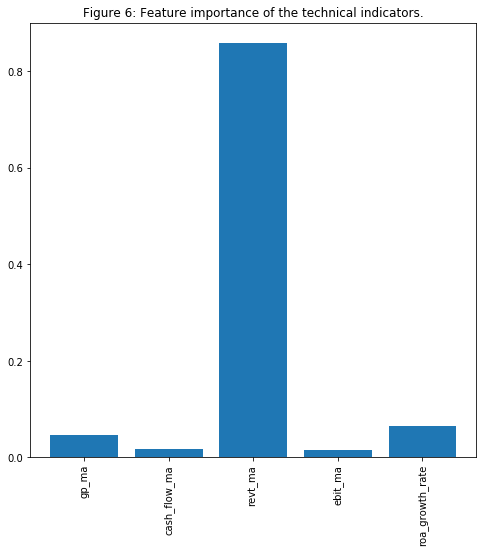

 17%|█▋        | 86/507 [02:14<15:05,  2.15s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:37:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


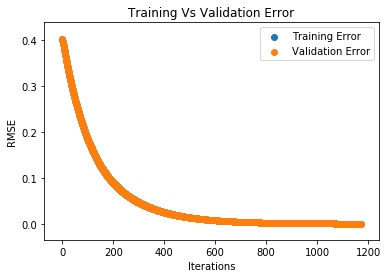

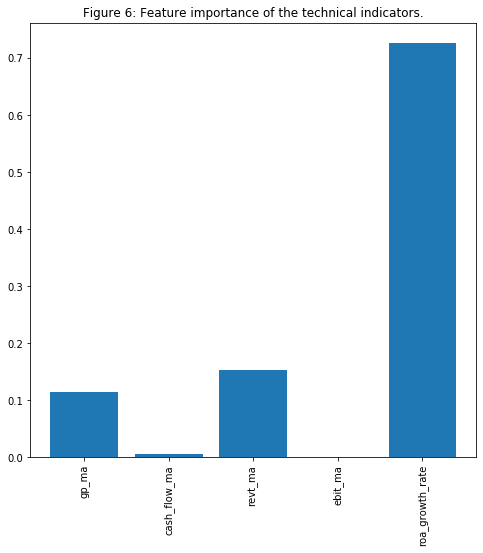

 17%|█▋        | 88/507 [02:16<12:38,  1.81s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


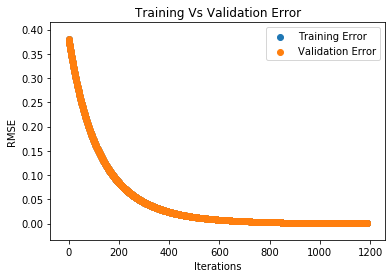

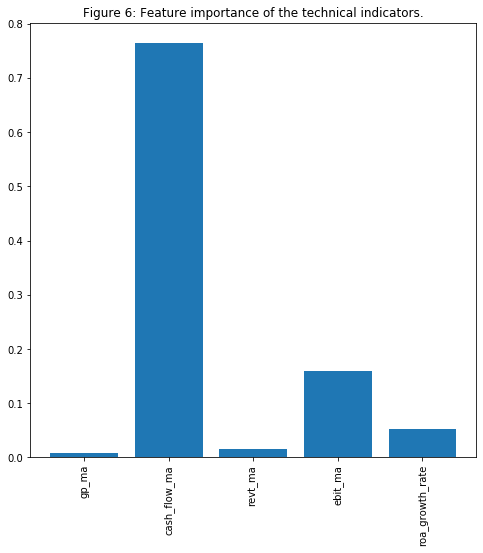

 18%|█▊        | 89/507 [02:18<13:03,  1.88s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


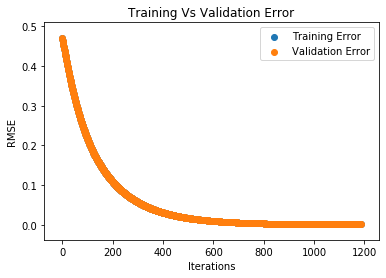

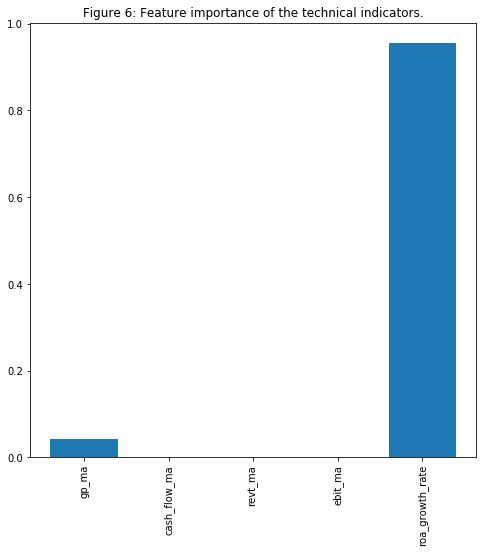

 18%|█▊        | 90/507 [02:20<12:58,  1.87s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


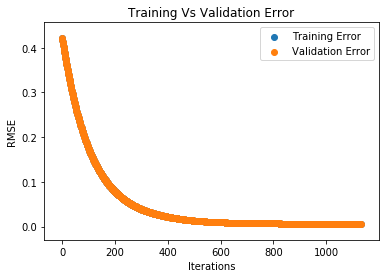

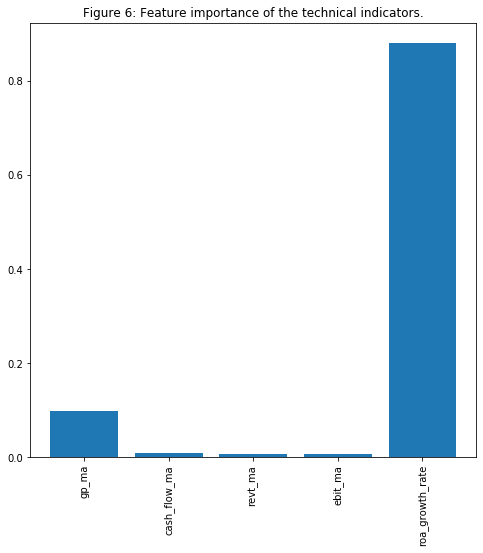

 18%|█▊        | 91/507 [02:22<13:37,  1.96s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


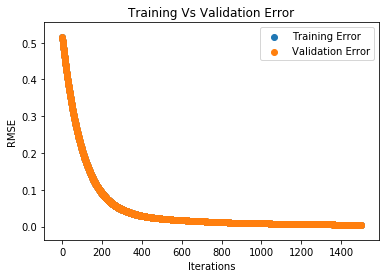

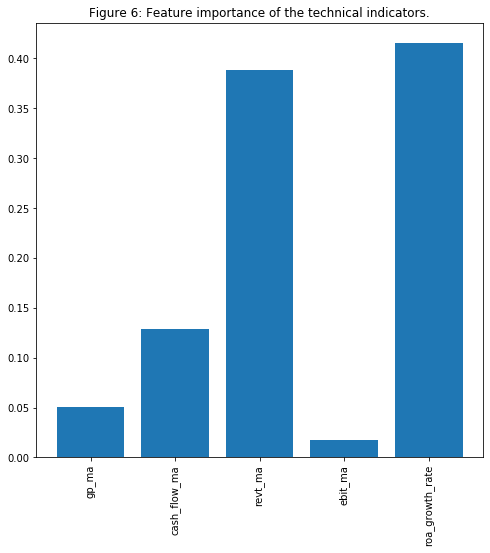

 18%|█▊        | 92/507 [02:25<15:03,  2.18s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


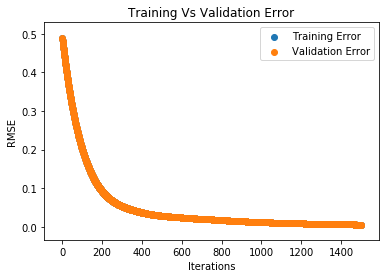

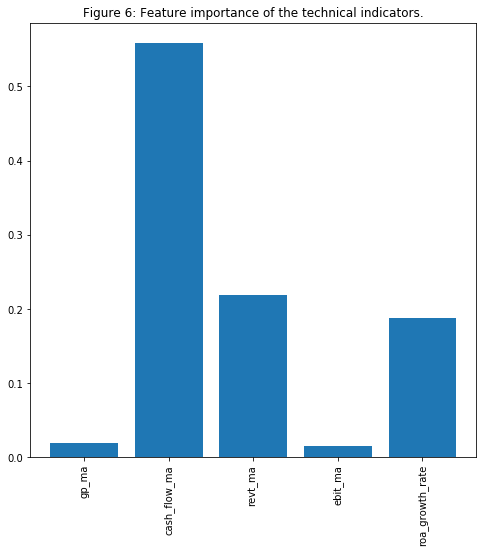

 18%|█▊        | 93/507 [02:27<15:52,  2.30s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


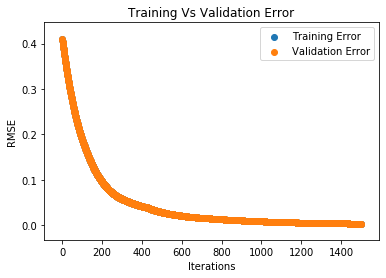

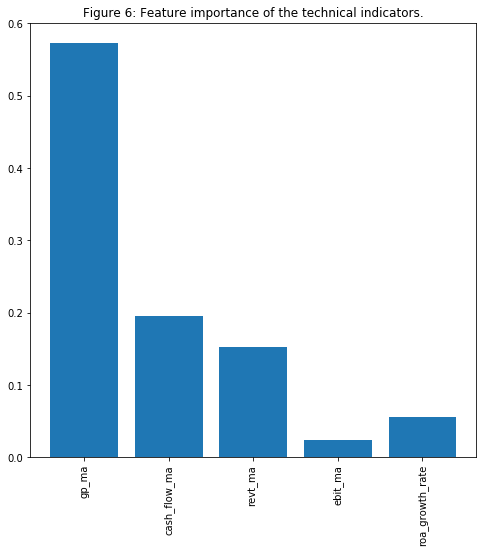

 19%|█▊        | 94/507 [02:30<15:57,  2.32s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


[15:37:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


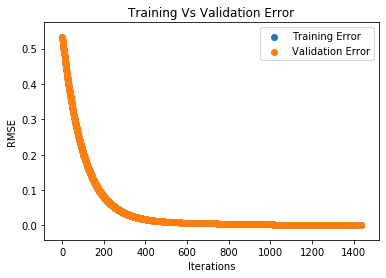

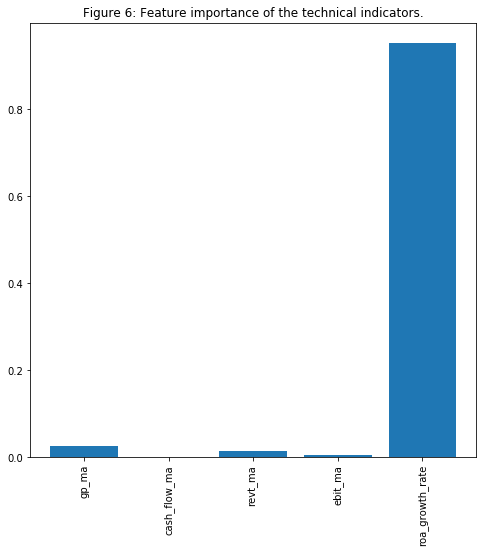

 19%|█▊        | 95/507 [02:32<15:43,  2.29s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
 19%|█▉        | 96/507 [02:33<13:11,  1.93s/it]

1


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


[15:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


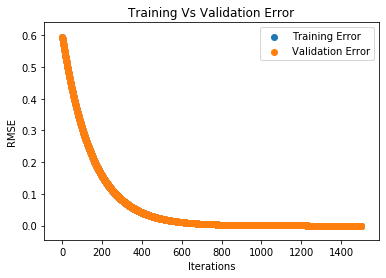

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


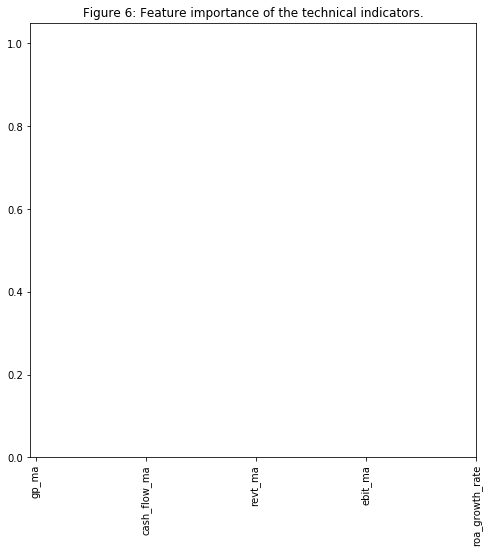

 19%|█▉        | 97/507 [02:35<12:59,  1.90s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


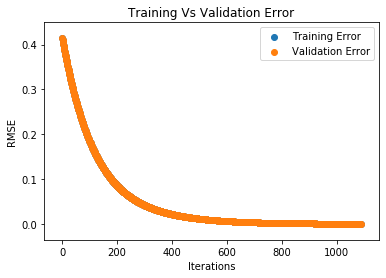

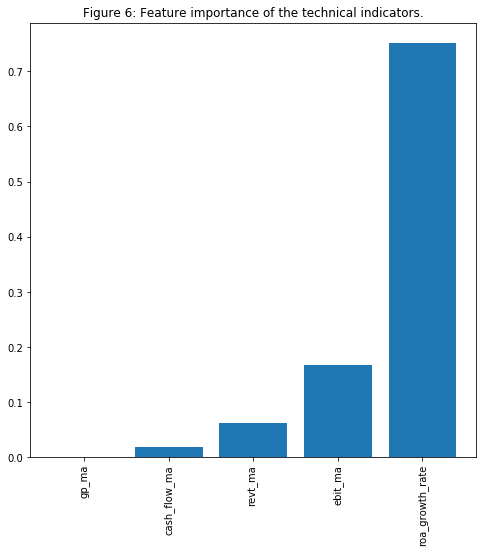

 19%|█▉        | 98/507 [02:37<13:07,  1.93s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


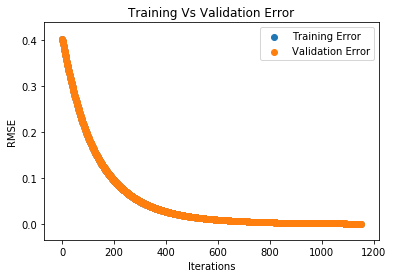

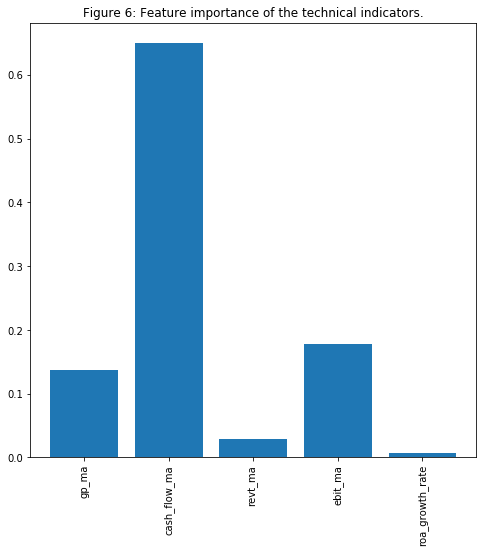

 20%|█▉        | 99/507 [02:39<13:18,  1.96s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


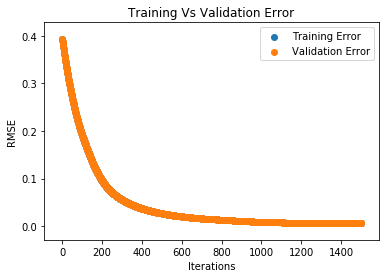

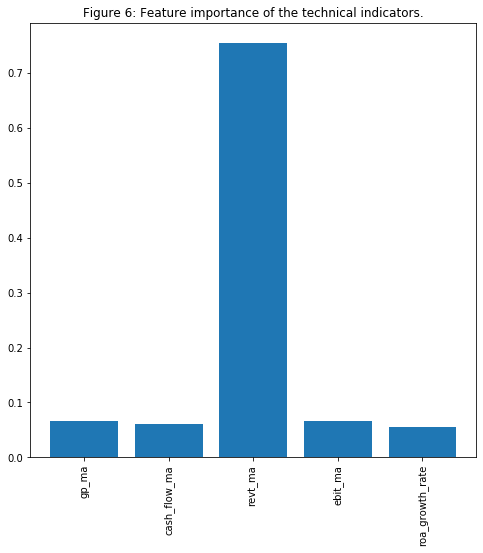

 20%|█▉        | 100/507 [02:41<13:56,  2.06s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


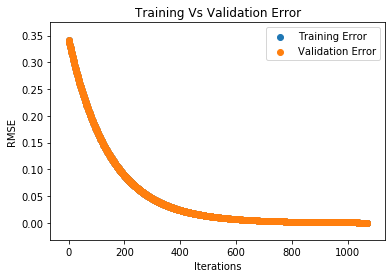

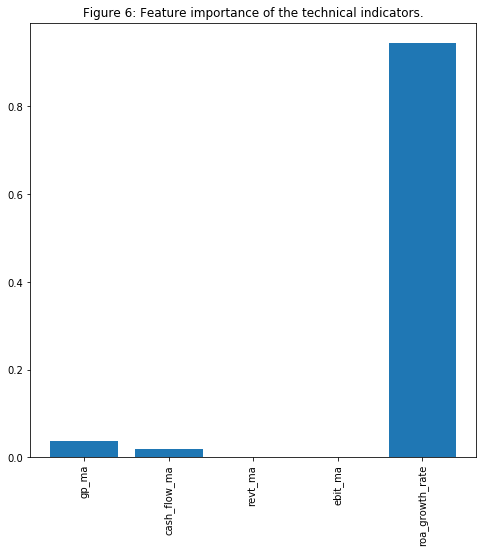

 20%|█▉        | 101/507 [02:43<13:38,  2.02s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


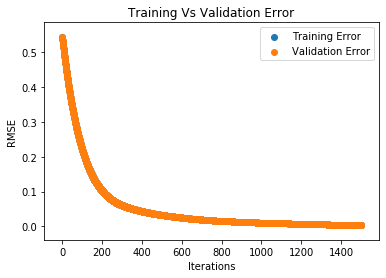

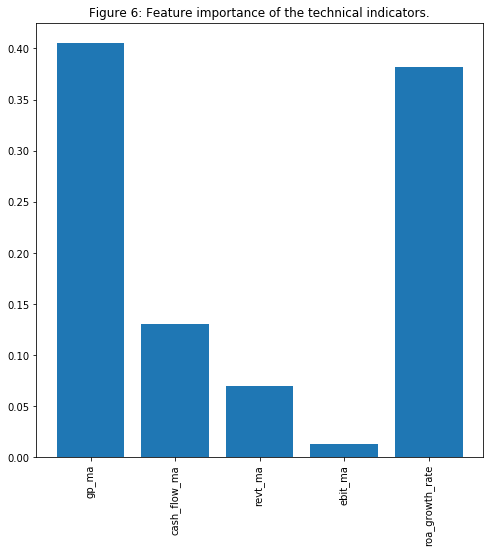

 20%|██        | 102/507 [02:45<14:07,  2.09s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:37:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


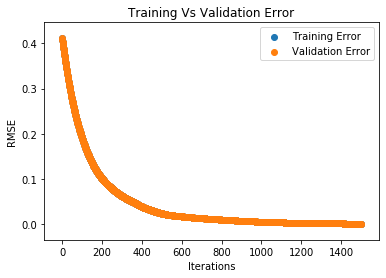

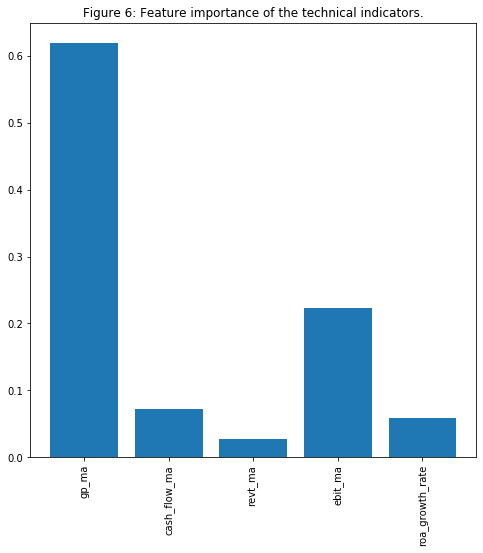

 21%|██        | 107/507 [02:48<08:28,  1.27s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


1
1
1
[15:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


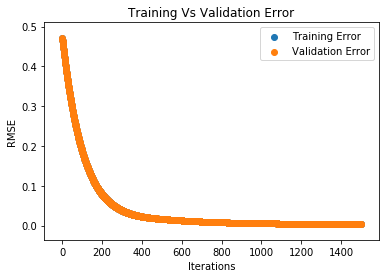

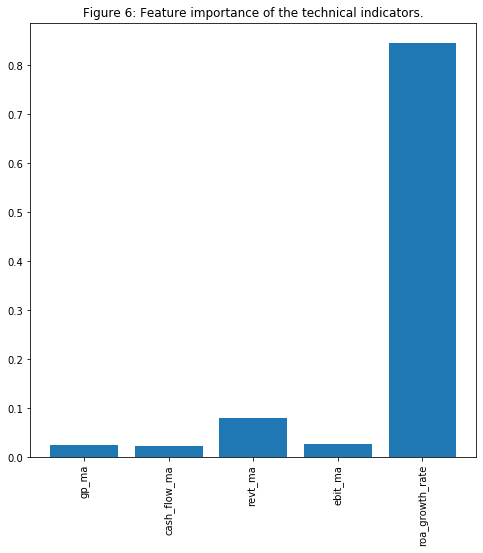

 21%|██▏       | 108/507 [02:50<10:40,  1.61s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


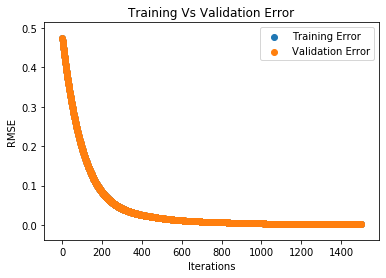

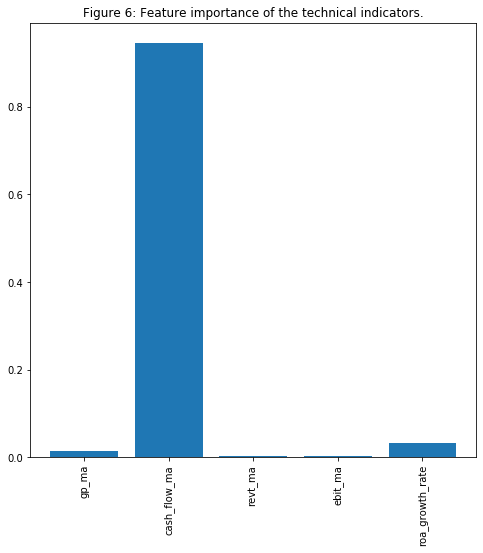

 21%|██▏       | 109/507 [02:53<12:08,  1.83s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


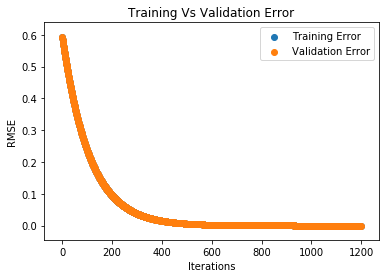

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


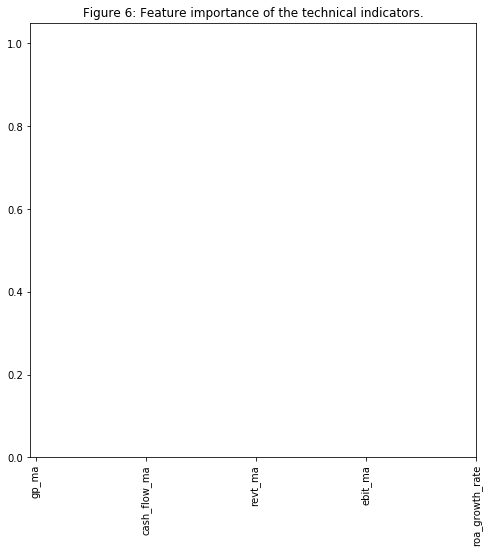

 22%|██▏       | 110/507 [02:54<12:05,  1.83s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


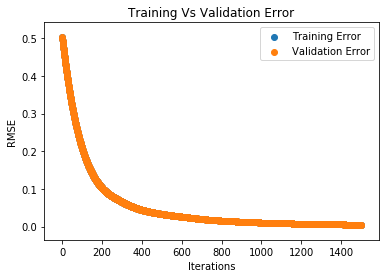

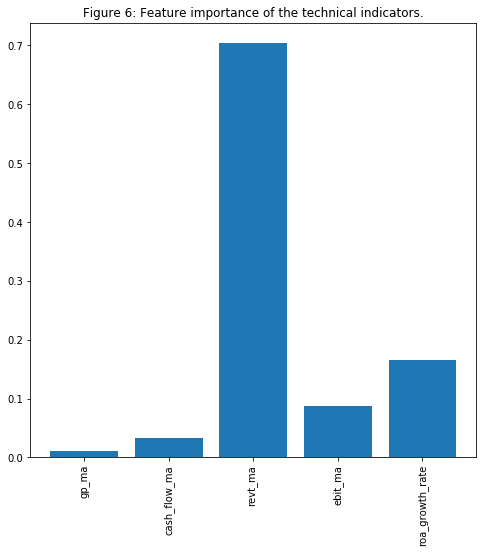

 22%|██▏       | 111/507 [02:57<13:14,  2.01s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


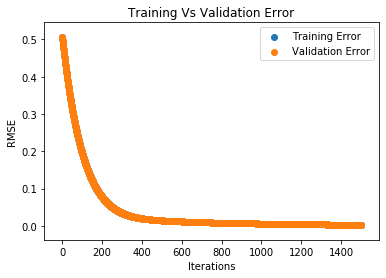

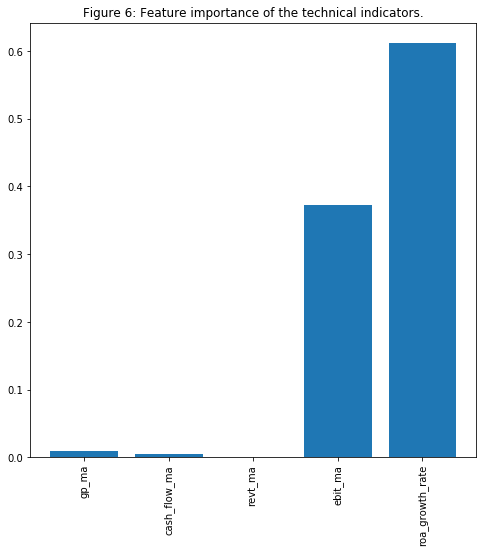

 22%|██▏       | 112/507 [02:59<14:10,  2.15s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:38:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


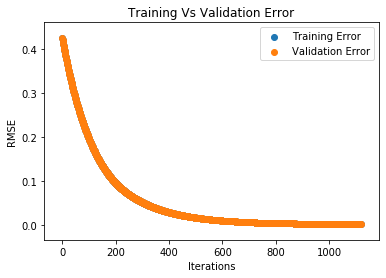

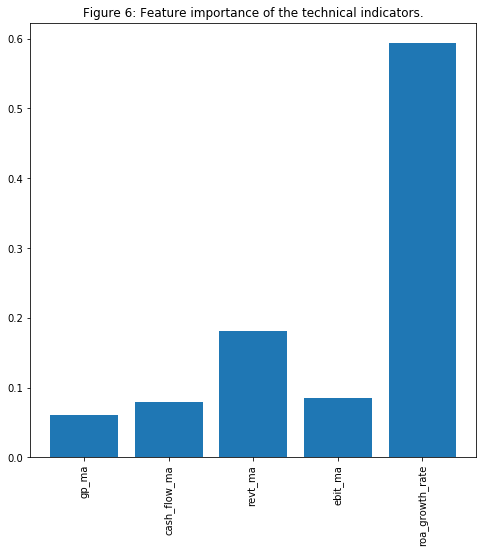

 22%|██▏       | 114/507 [03:01<11:39,  1.78s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


[15:38:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


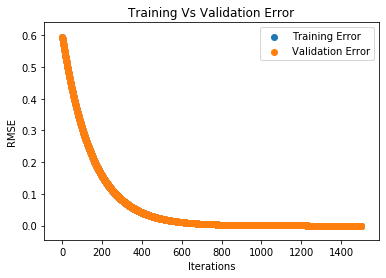

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


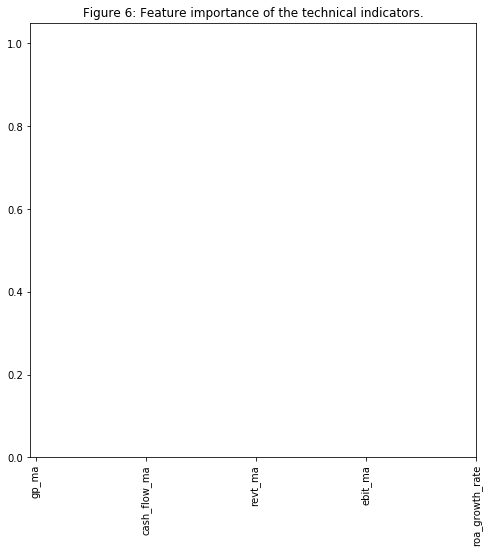

 23%|██▎       | 115/507 [03:03<11:44,  1.80s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


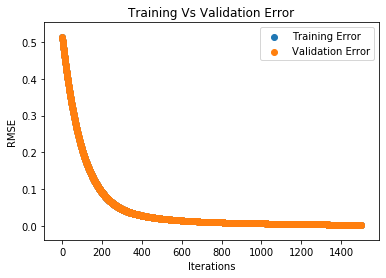

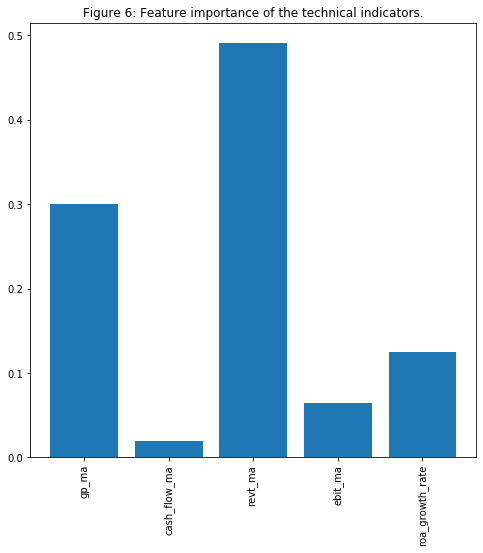

 23%|██▎       | 116/507 [03:06<13:18,  2.04s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


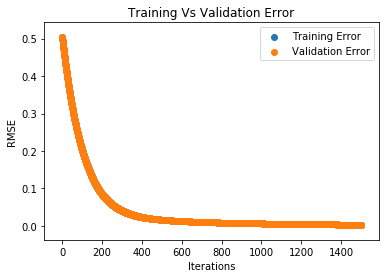

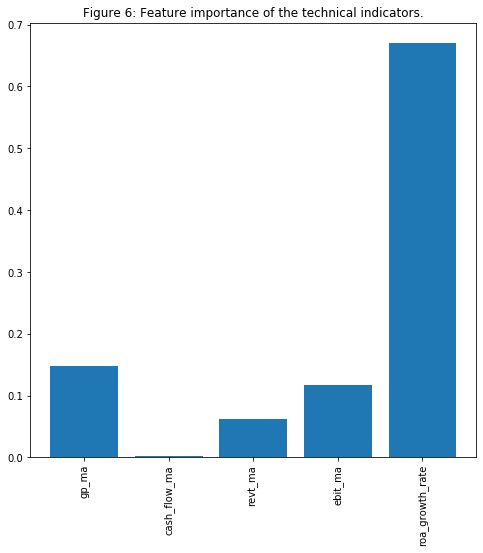

 23%|██▎       | 117/507 [03:08<13:53,  2.14s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


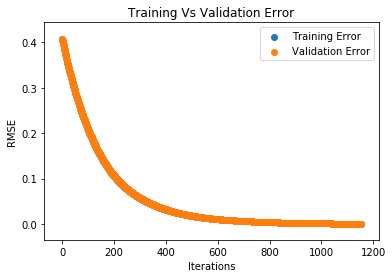

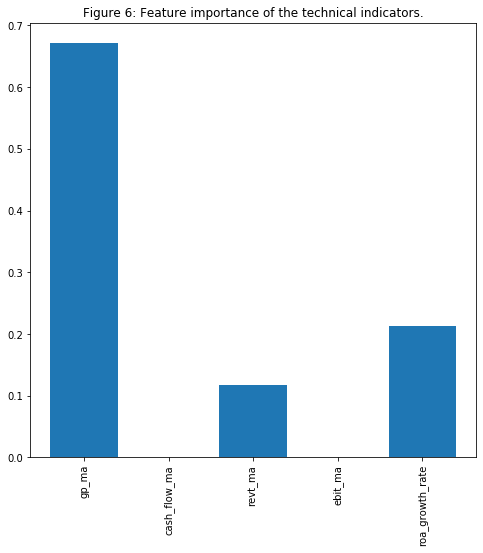

 24%|██▍       | 121/507 [03:10<09:24,  1.46s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
1
1
[15:38:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


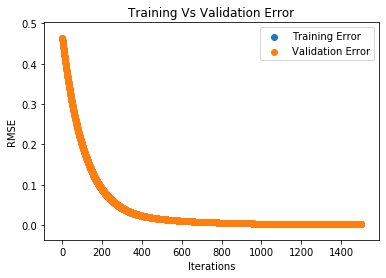

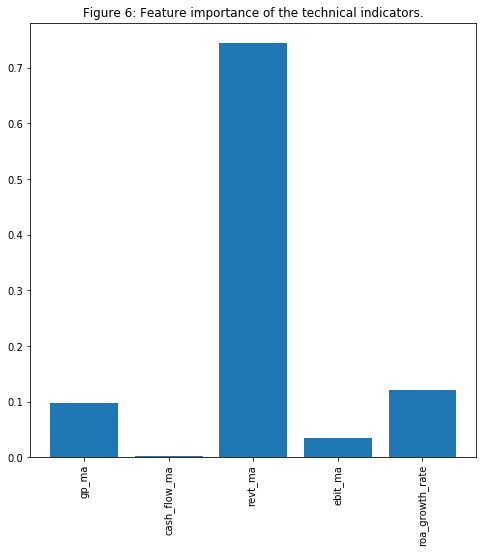

 24%|██▍       | 123/507 [03:13<09:02,  1.41s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1


 25%|██▍       | 125/507 [03:13<07:07,  1.12s/it]

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


[15:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


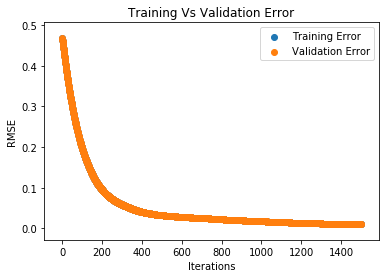

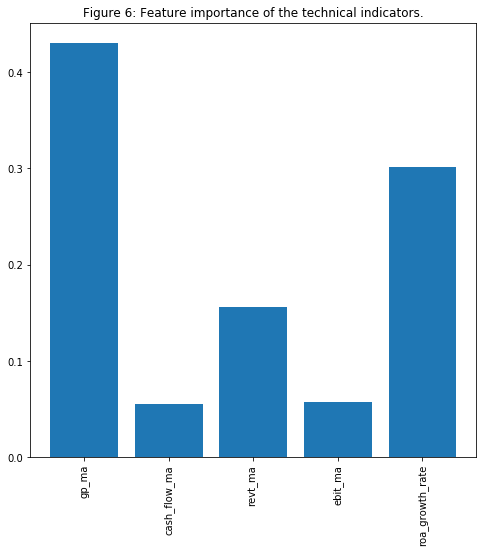

 25%|██▍       | 126/507 [03:16<09:35,  1.51s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


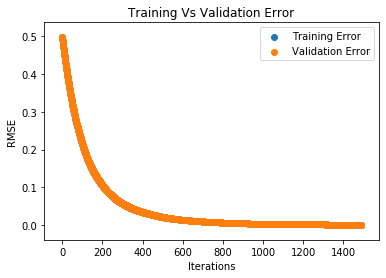

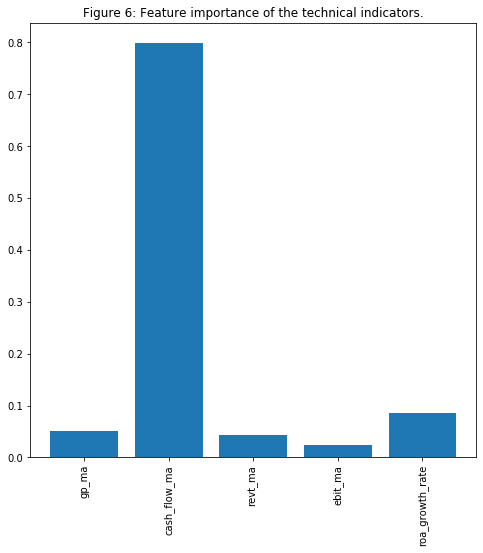

 25%|██▌       | 127/507 [03:18<11:00,  1.74s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


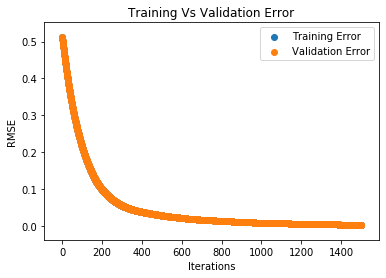

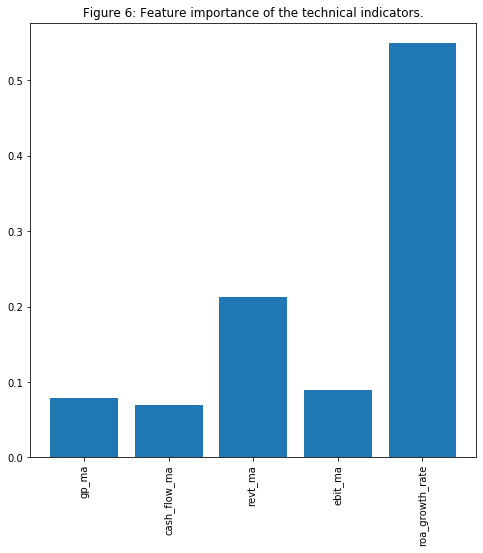

 26%|██▌       | 130/507 [03:21<09:16,  1.48s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


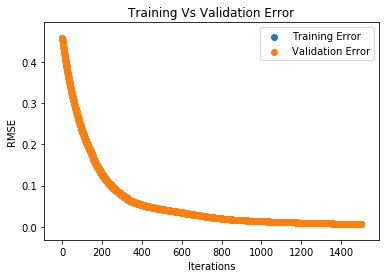

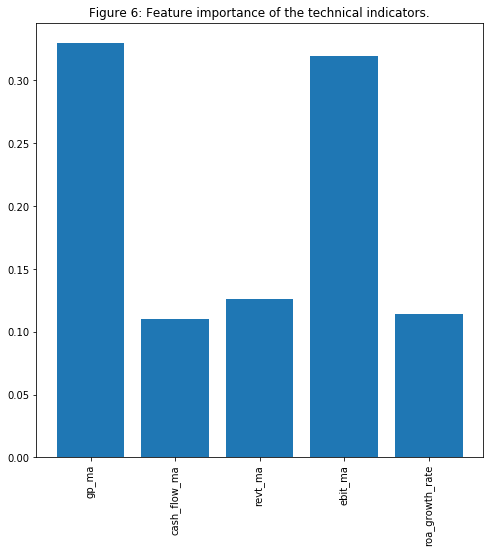

 26%|██▌       | 131/507 [03:23<11:26,  1.82s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


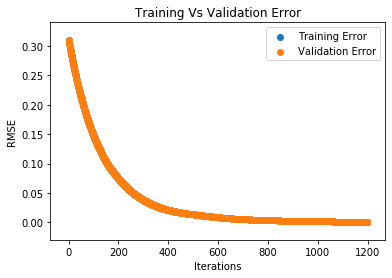

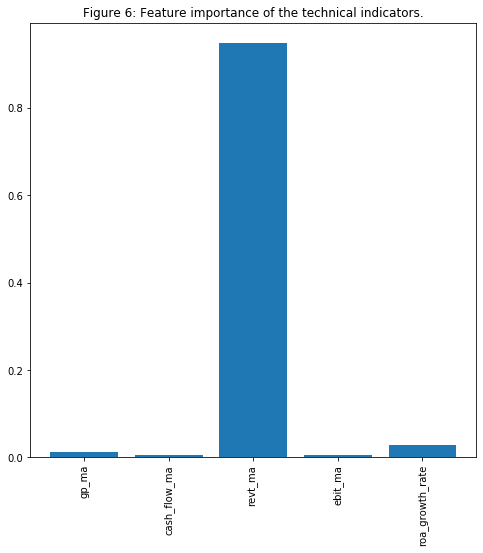

 26%|██▌       | 133/507 [03:26<09:51,  1.58s/it]

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


[15:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


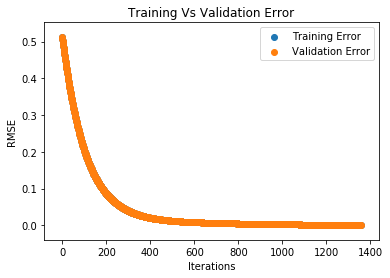

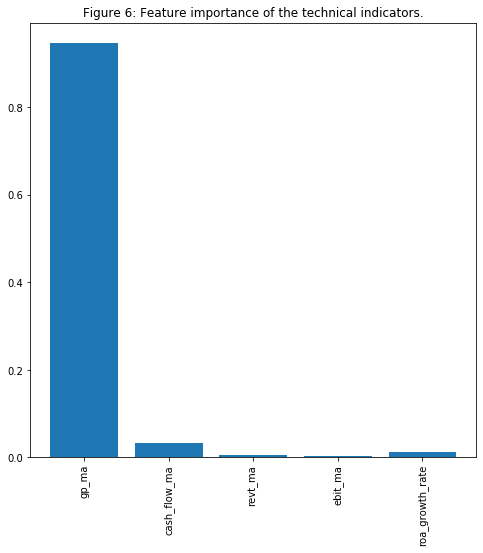

 26%|██▋       | 134/507 [03:28<11:08,  1.79s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


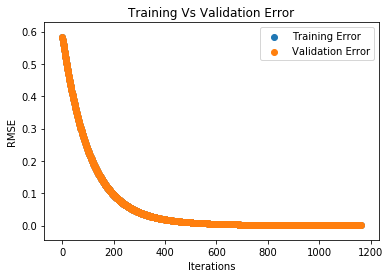

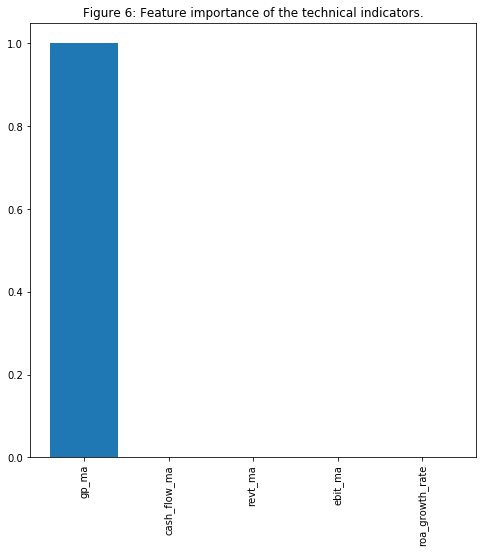

 27%|██▋       | 137/507 [03:30<08:56,  1.45s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


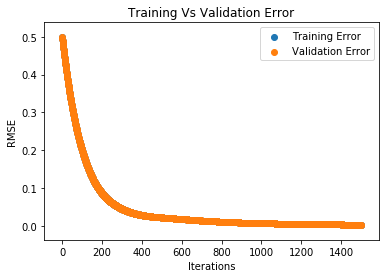

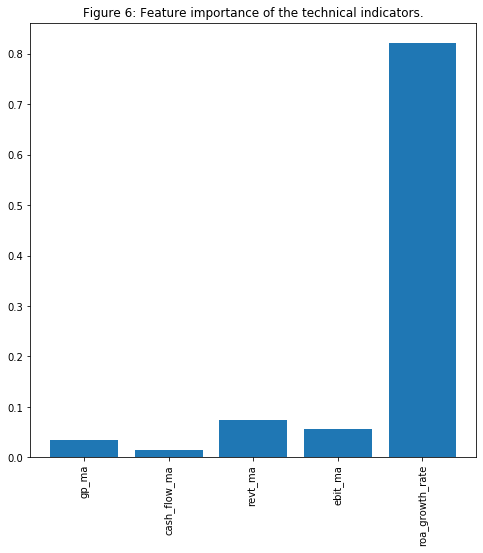

 27%|██▋       | 138/507 [03:33<11:00,  1.79s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


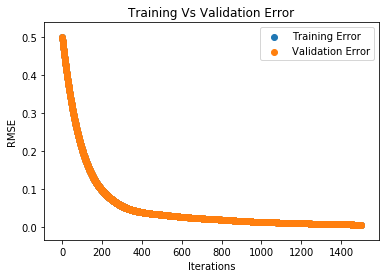

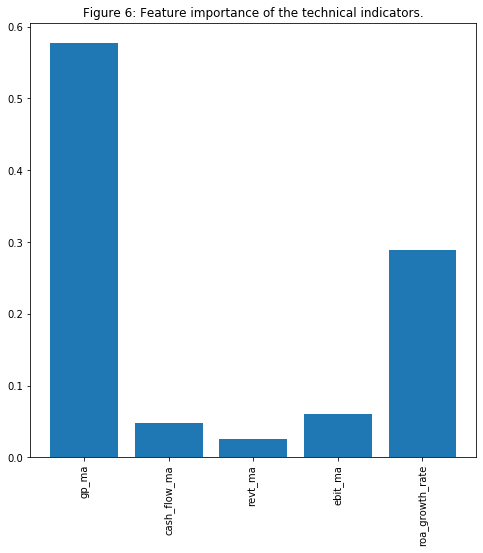

 27%|██▋       | 139/507 [03:35<12:12,  1.99s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:38:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


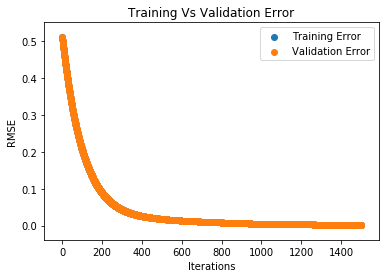

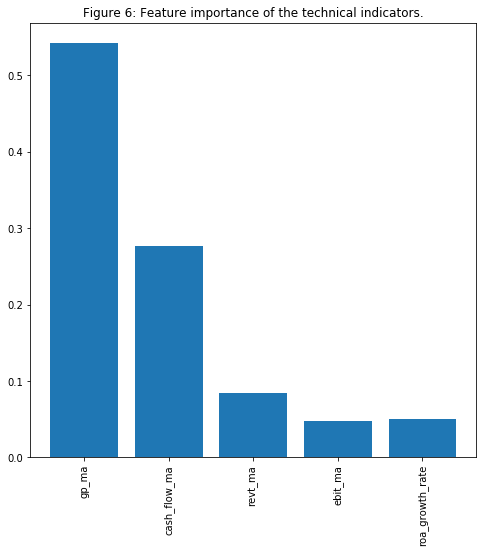

 28%|██▊       | 142/507 [03:38<09:56,  1.64s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:38:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


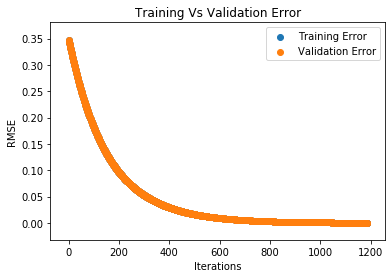

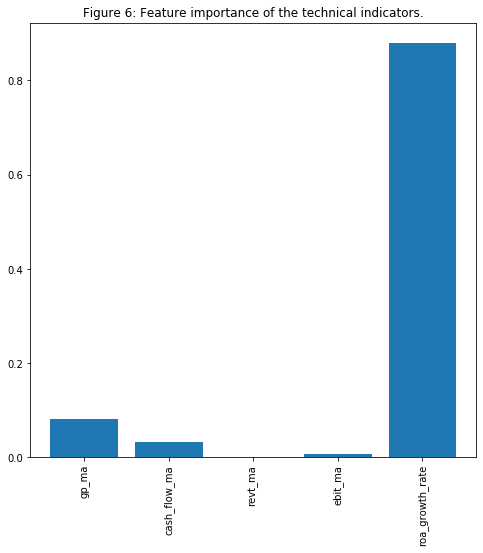

 28%|██▊       | 144/507 [03:40<08:40,  1.43s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


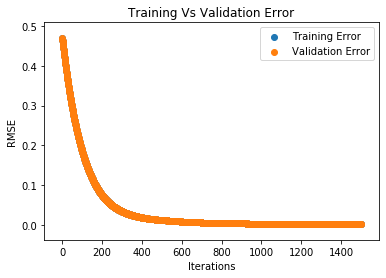

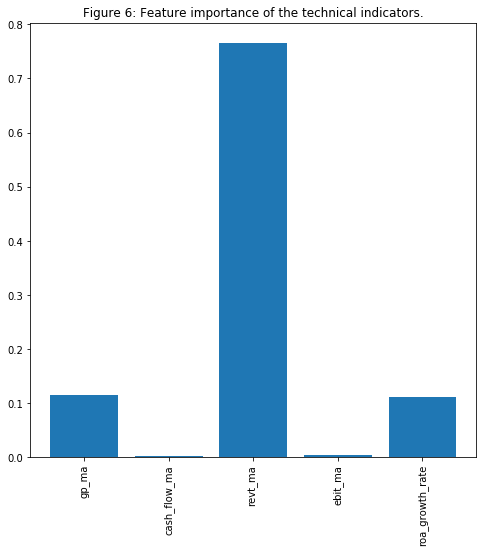

 29%|██▊       | 145/507 [03:42<10:29,  1.74s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


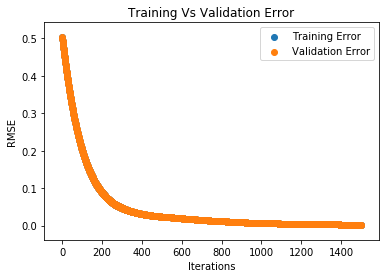

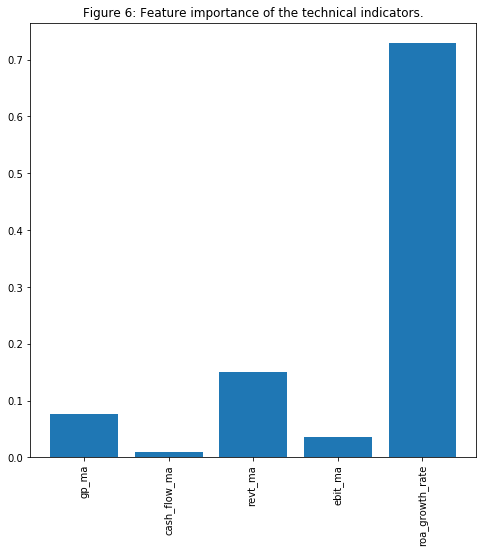

 29%|██▉       | 146/507 [03:45<11:39,  1.94s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


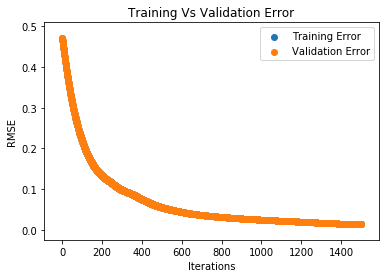

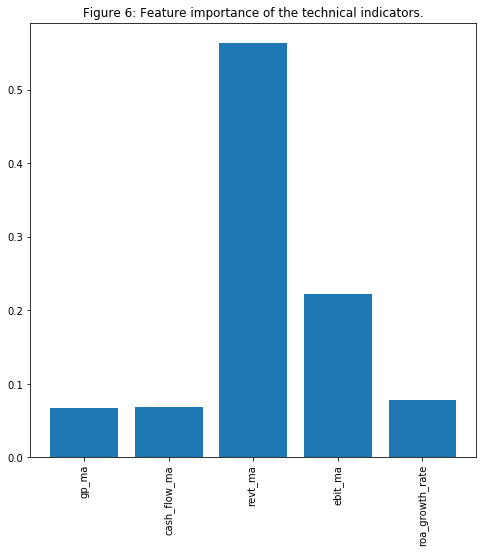

 29%|██▉       | 147/507 [03:47<12:41,  2.11s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


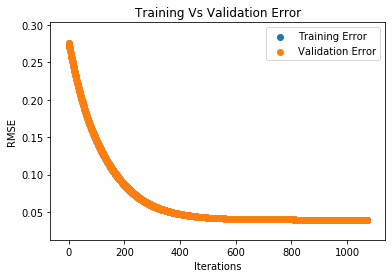

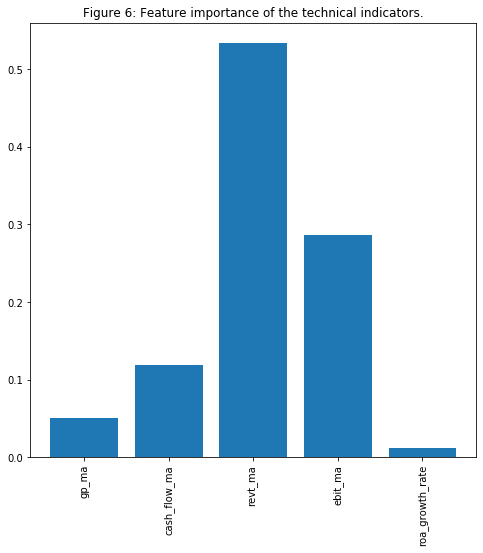

 29%|██▉       | 148/507 [03:49<12:24,  2.07s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


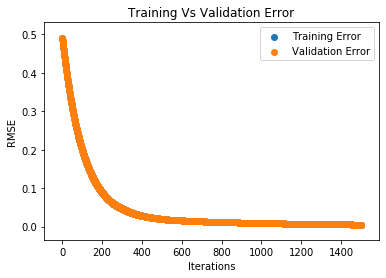

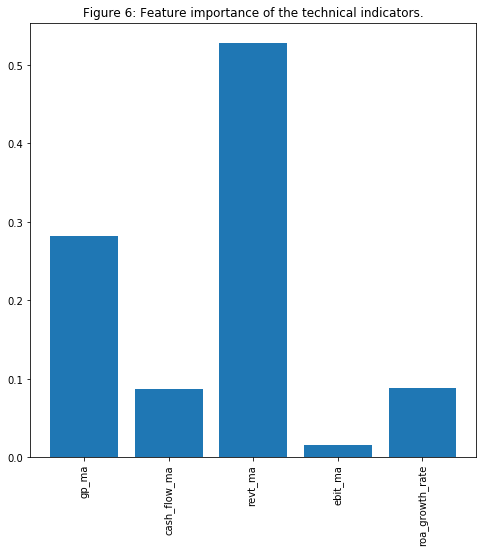

 29%|██▉       | 149/507 [03:52<13:26,  2.25s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:38:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


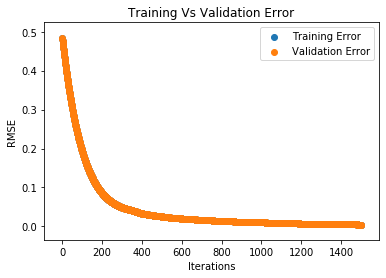

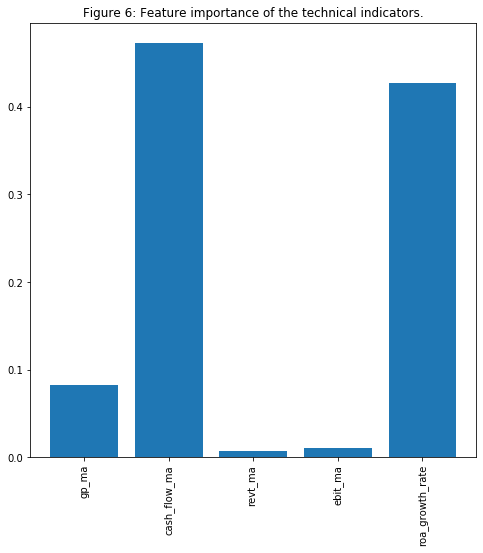

 30%|██▉       | 151/507 [03:54<11:40,  1.97s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:39:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


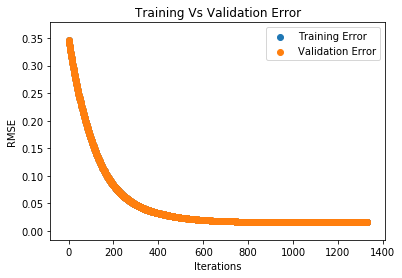

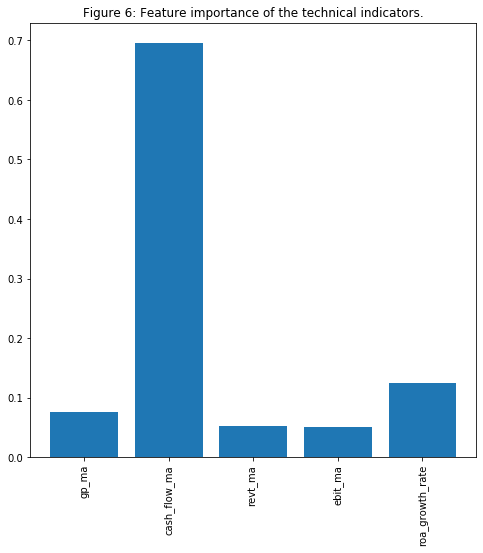

 30%|██▉       | 152/507 [03:57<12:31,  2.12s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


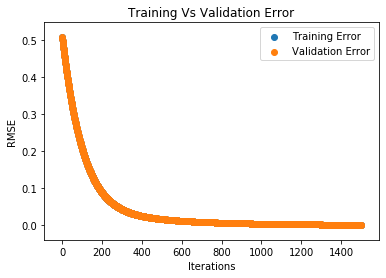

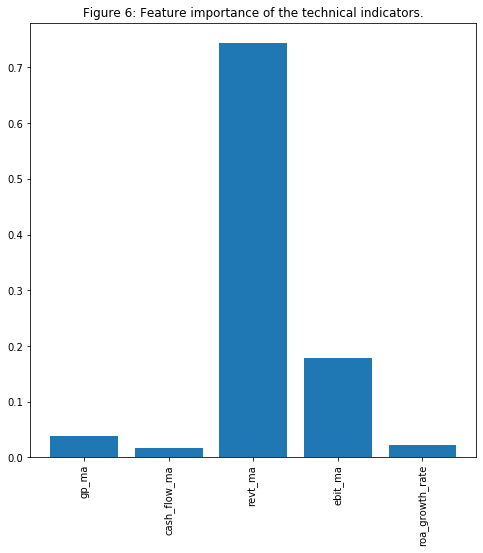

 30%|███       | 153/507 [04:00<13:22,  2.27s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


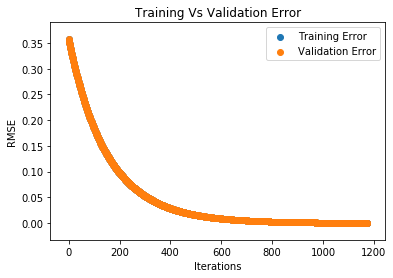

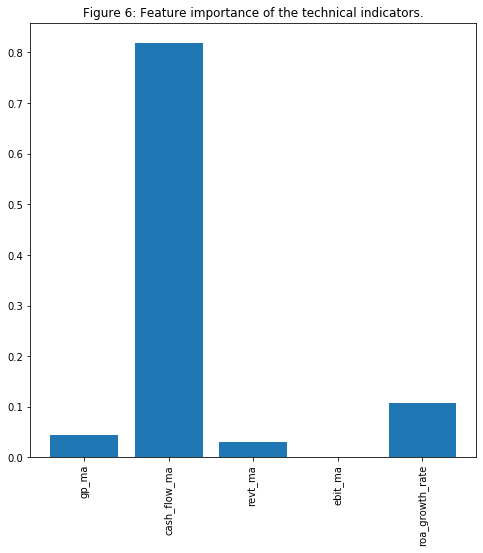

 31%|███       | 156/507 [04:02<10:39,  1.82s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:39:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


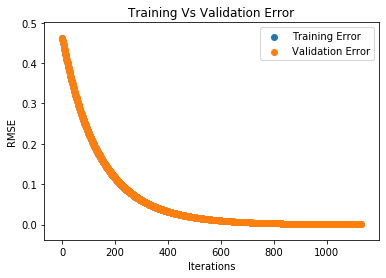

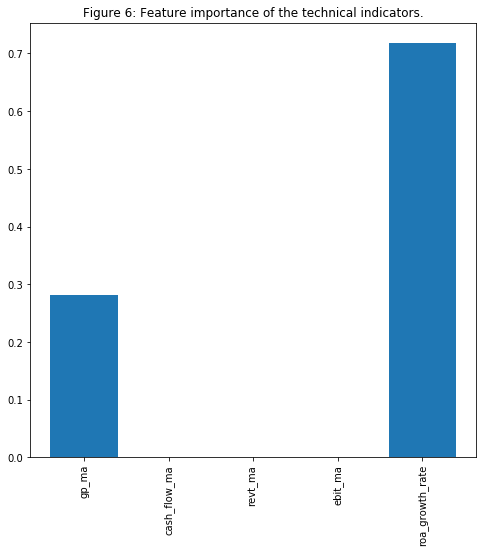

 31%|███       | 157/507 [04:04<10:52,  1.86s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:39:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


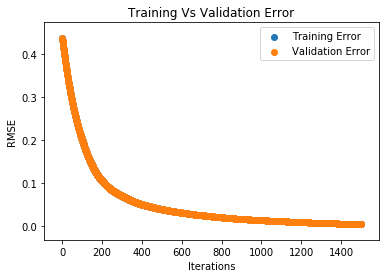

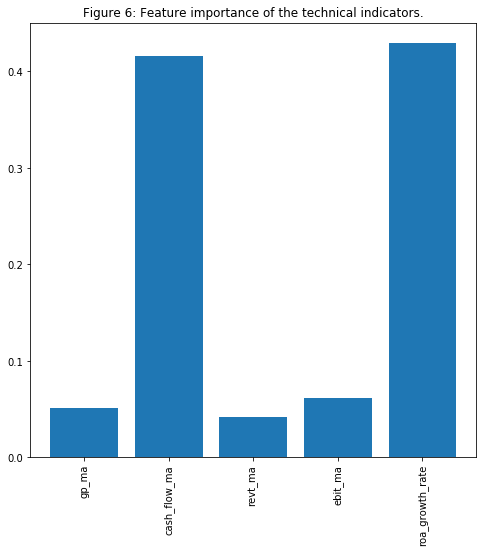

 31%|███       | 158/507 [04:06<11:57,  2.05s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


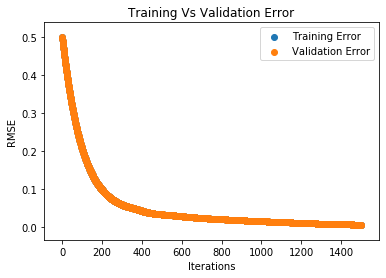

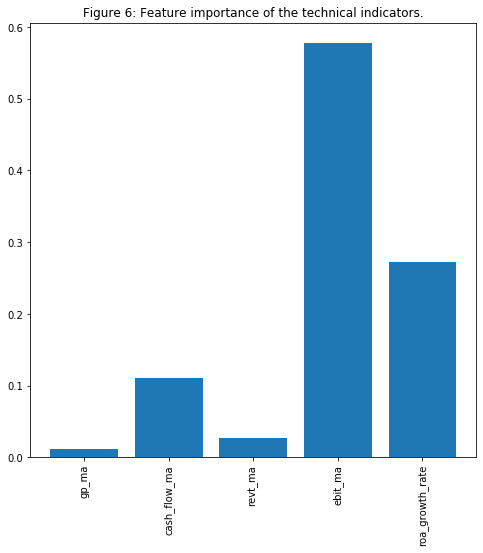

 31%|███▏      | 159/507 [04:09<13:10,  2.27s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


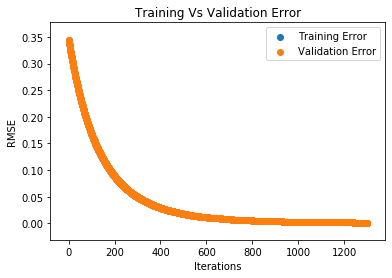

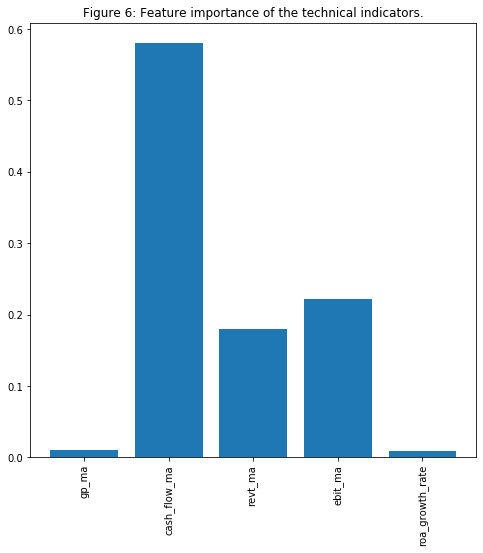

 32%|███▏      | 161/507 [04:12<10:30,  1.82s/it]

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


[15:39:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


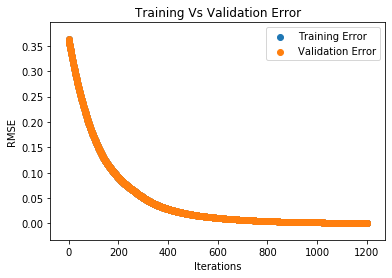

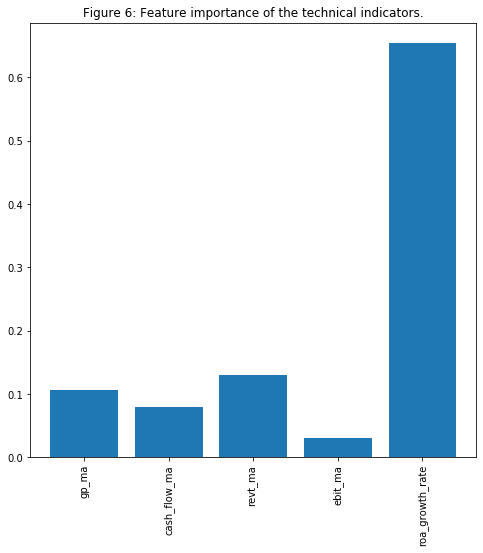

 32%|███▏      | 162/507 [04:14<10:54,  1.90s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:39:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


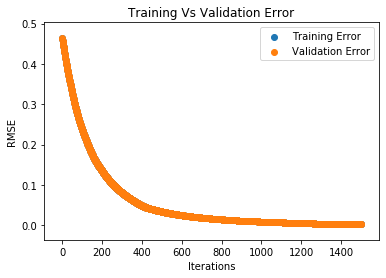

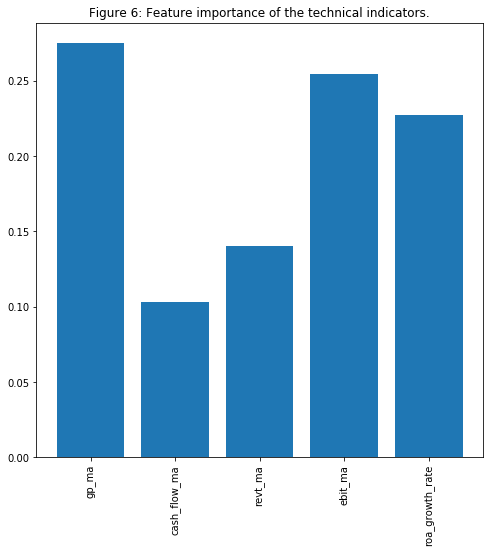

 32%|███▏      | 164/507 [04:16<09:18,  1.63s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1


 33%|███▎      | 166/507 [04:17<07:04,  1.25s/it]

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


[15:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


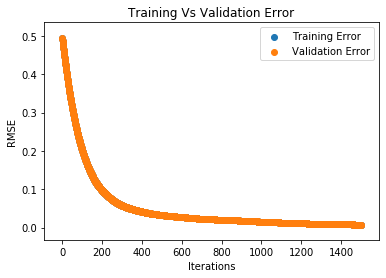

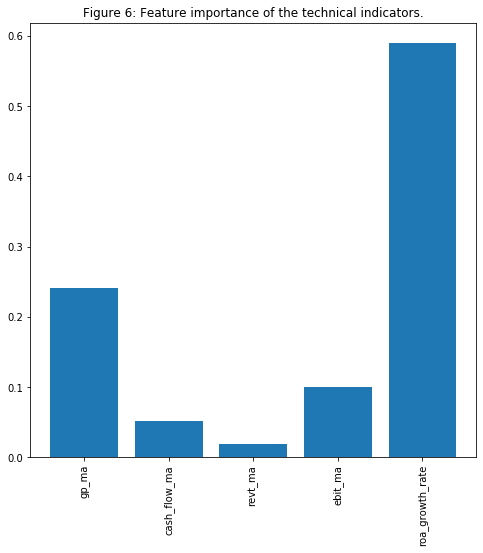

 33%|███▎      | 167/507 [04:19<09:10,  1.62s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:39:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


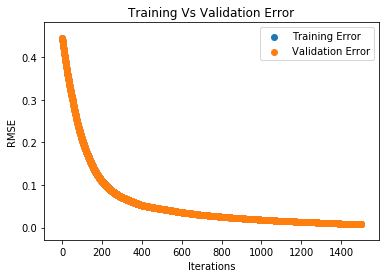

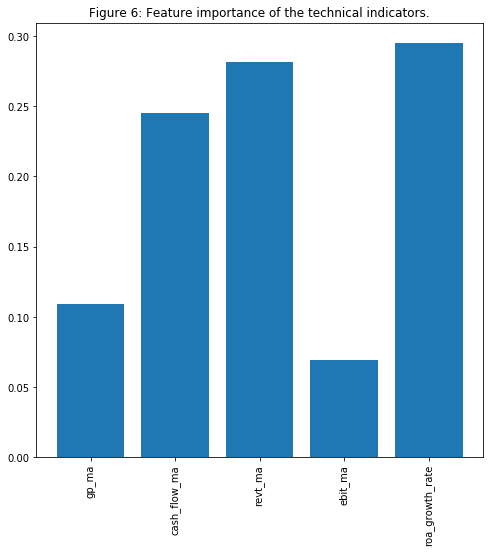

 33%|███▎      | 169/507 [04:22<08:20,  1.48s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


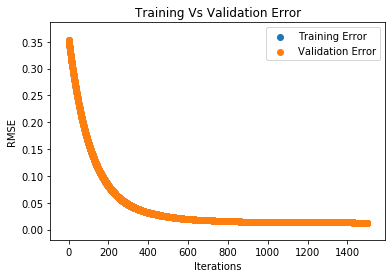

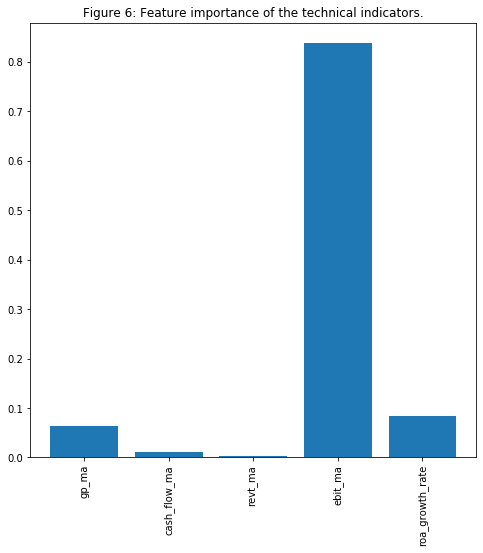

 34%|███▎      | 171/507 [04:24<07:44,  1.38s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:39:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


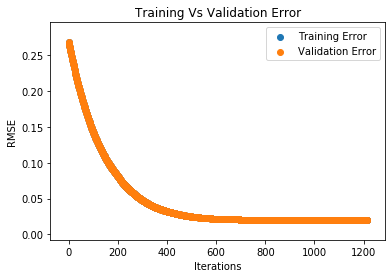

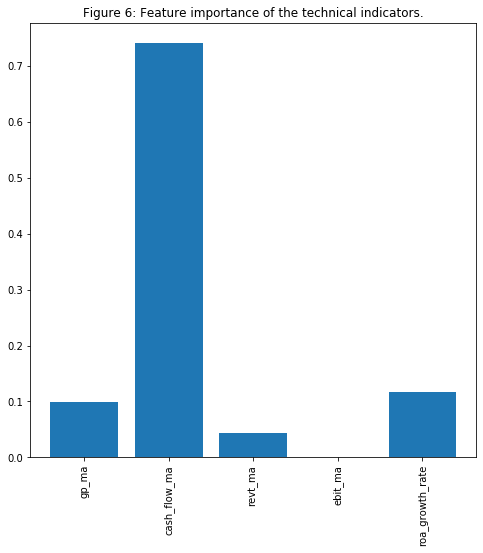

 34%|███▍      | 172/507 [04:26<08:47,  1.58s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


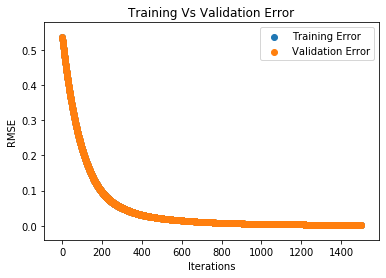

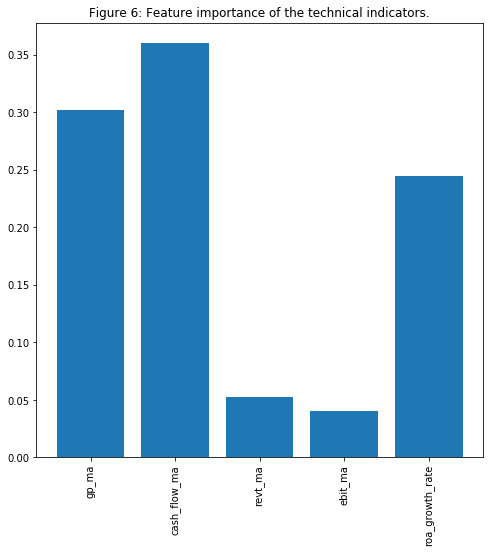

 34%|███▍      | 174/507 [04:29<08:12,  1.48s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:39:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


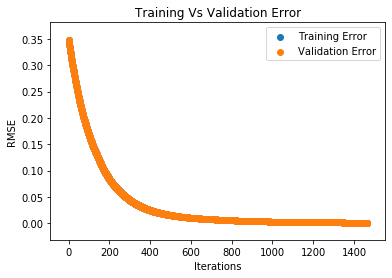

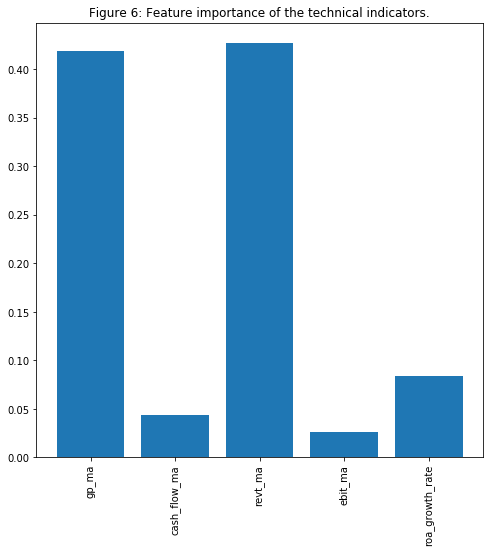

 35%|███▍      | 176/507 [04:31<07:32,  1.37s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


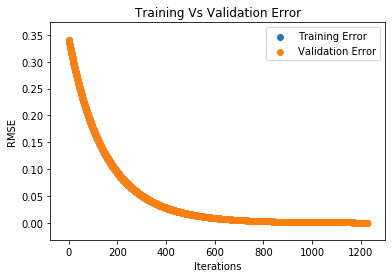

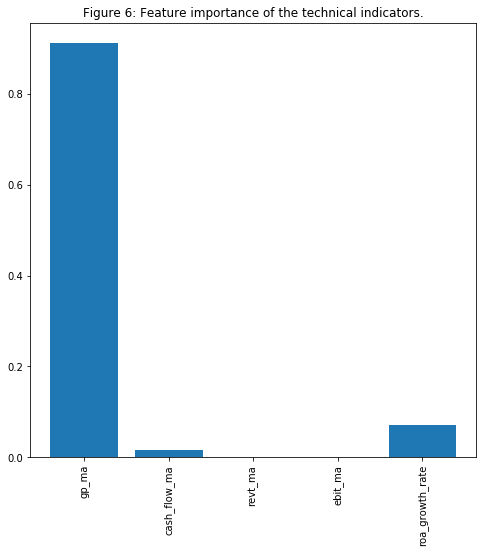

 36%|███▌      | 182/507 [04:33<04:26,  1.22it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
1


 36%|███▌      | 183/507 [04:34<04:42,  1.15it/s]

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


[15:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


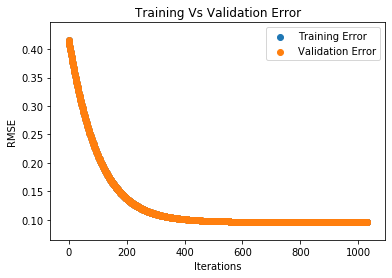

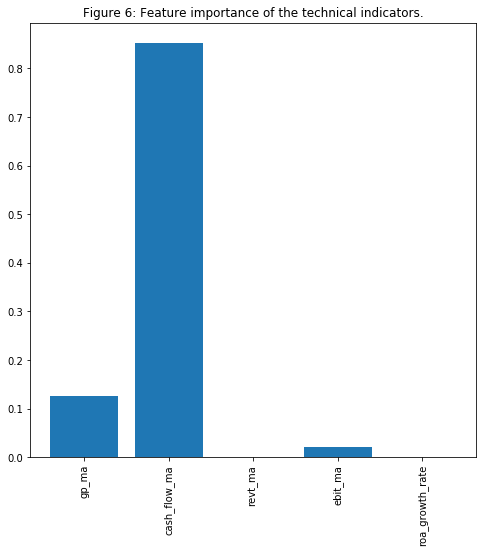

 36%|███▋      | 184/507 [04:36<06:35,  1.23s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


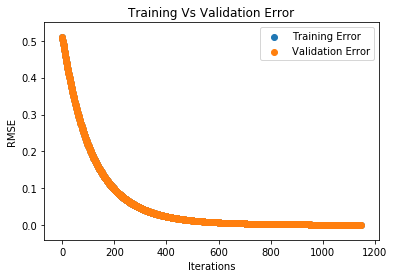

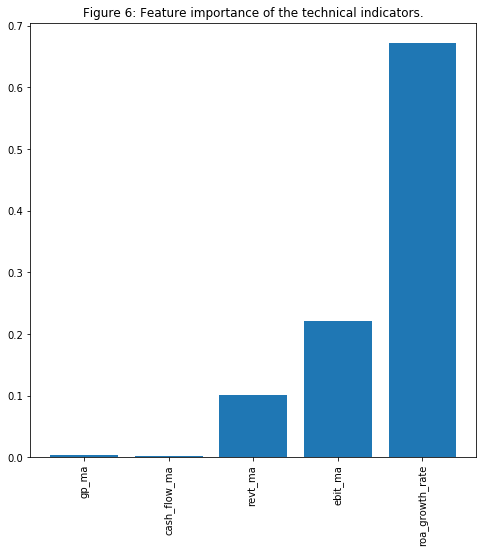

 37%|███▋      | 187/507 [04:38<05:33,  1.04s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


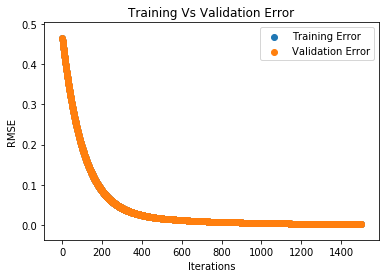

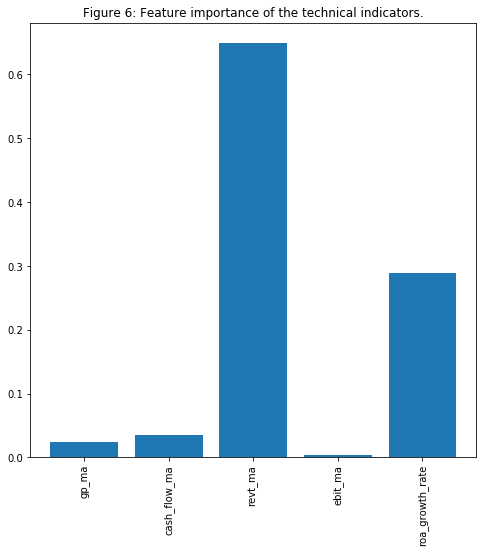

 37%|███▋      | 189/507 [04:40<05:44,  1.08s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:39:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


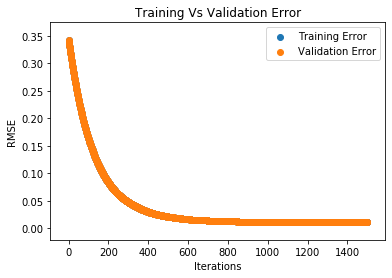

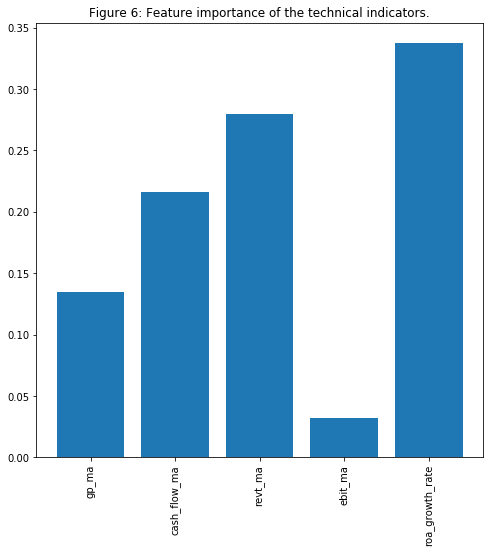

 38%|███▊      | 191/507 [04:42<05:52,  1.11s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


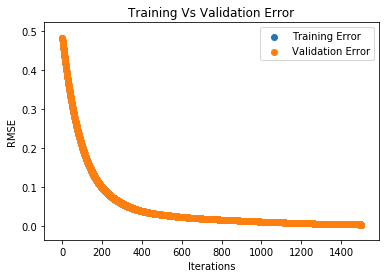

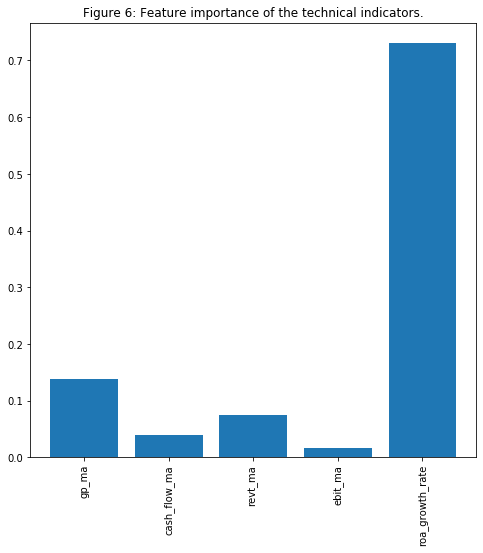

 38%|███▊      | 192/507 [04:45<07:45,  1.48s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


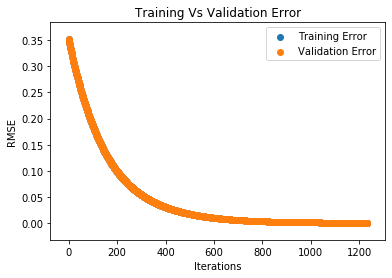

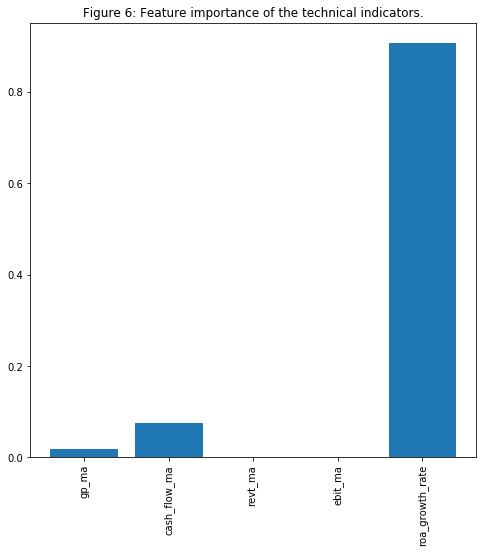

 39%|███▉      | 199/507 [04:47<04:12,  1.22it/s]

1
1
1
1
1
1


 40%|███▉      | 202/507 [04:47<02:58,  1.71it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
1
[15:39:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


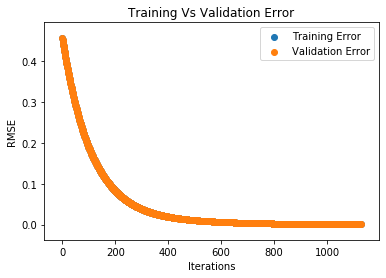

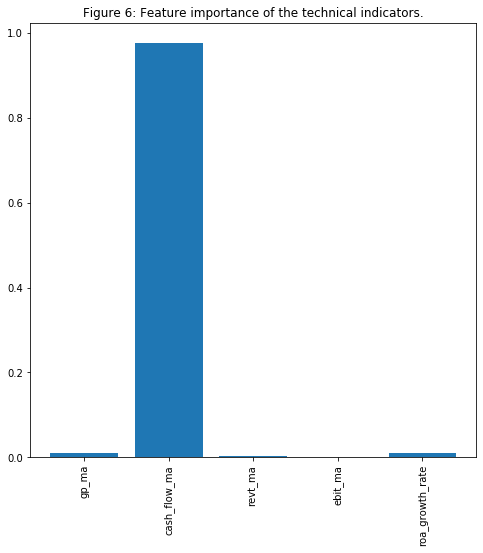

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:39:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


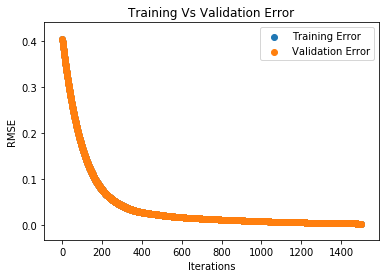

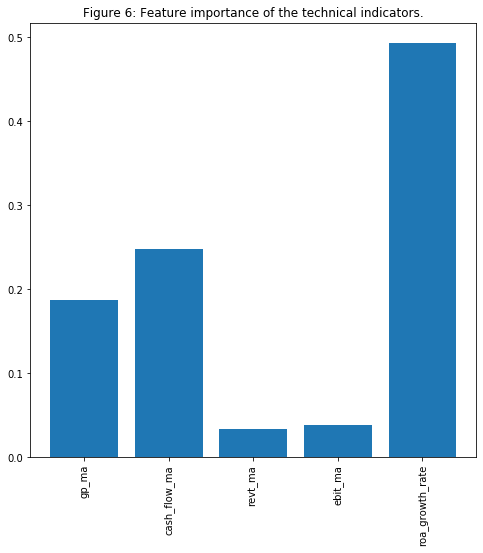

 40%|████      | 204/507 [04:52<05:28,  1.08s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:39:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


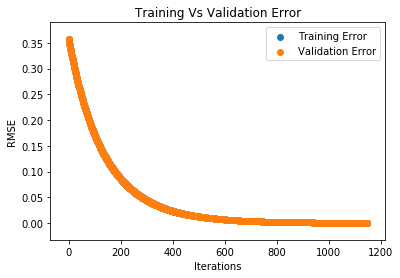

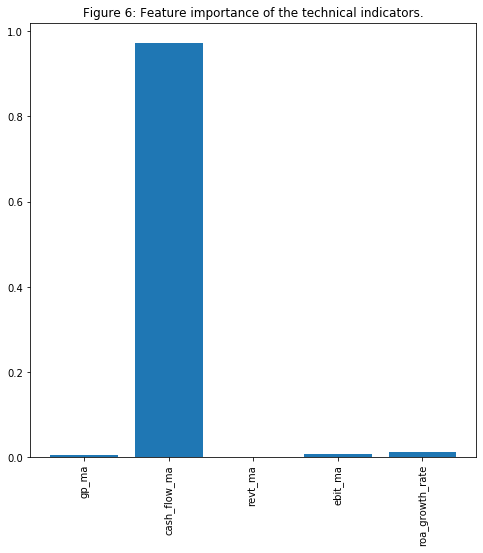

 41%|████      | 206/507 [04:53<05:09,  1.03s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


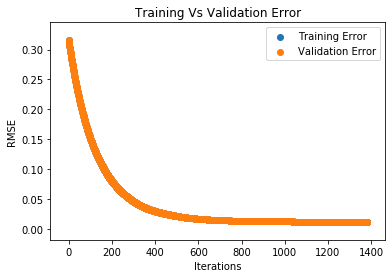

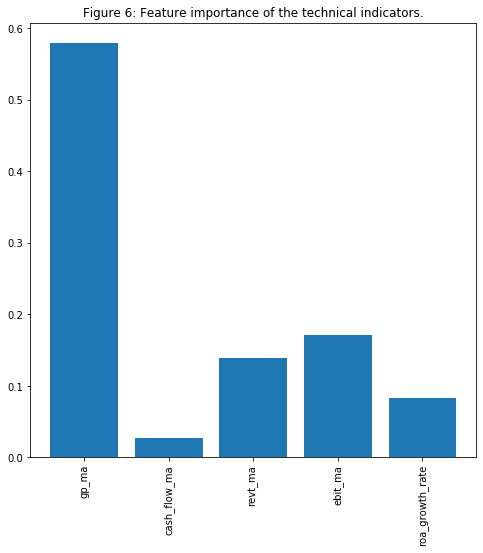

 41%|████      | 207/507 [04:56<07:03,  1.41s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


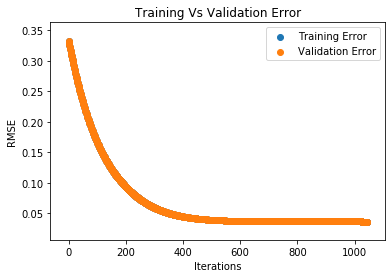

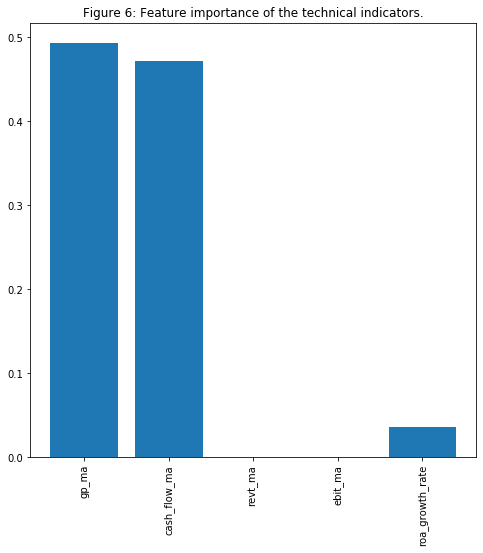

 41%|████▏     | 210/507 [04:58<05:47,  1.17s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


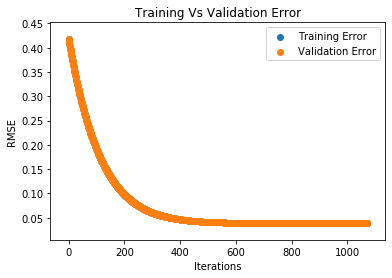

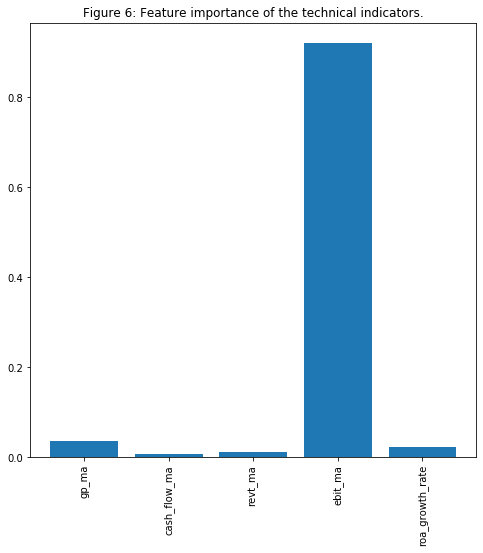

 42%|████▏     | 215/507 [05:00<03:54,  1.25it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
1


 43%|████▎     | 217/507 [05:01<03:18,  1.46it/s]

1
1


 43%|████▎     | 218/507 [05:02<03:43,  1.29it/s]

1
[15:40:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


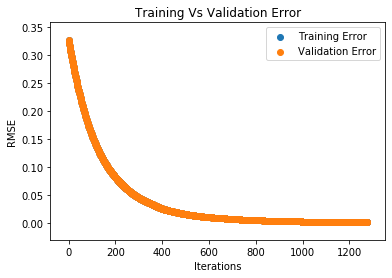

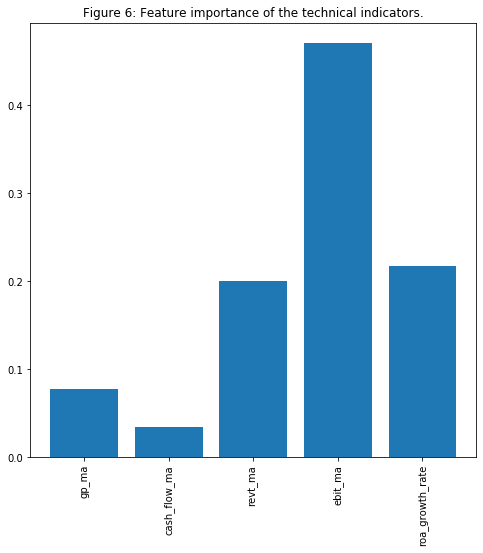

 43%|████▎     | 219/507 [05:04<05:33,  1.16s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:40:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


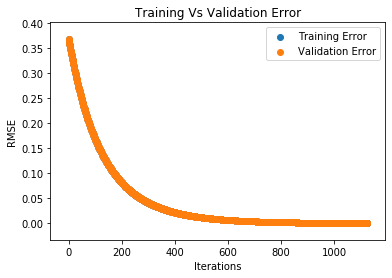

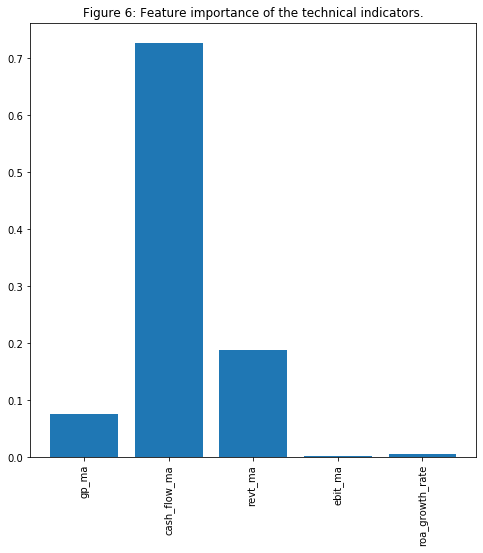

 43%|████▎     | 220/507 [05:05<06:32,  1.37s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:40:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


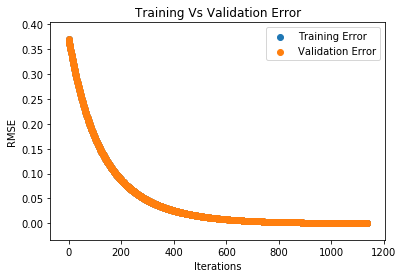

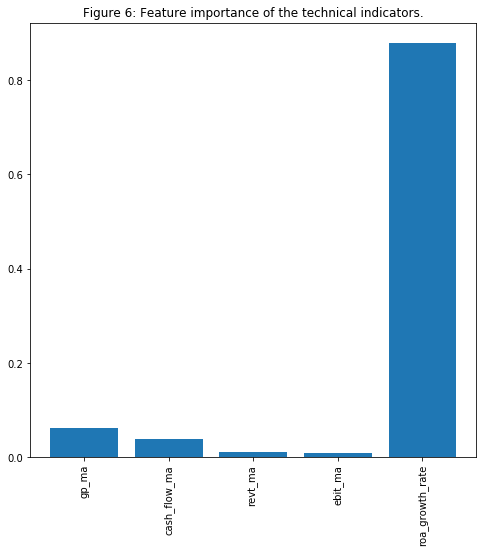

 44%|████▍     | 224/507 [05:07<05:04,  1.08s/it]

1
1
1
1
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:40:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


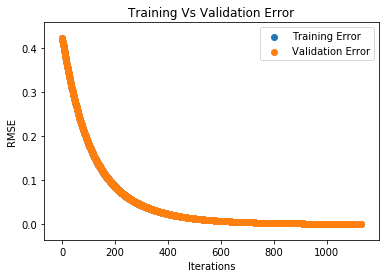

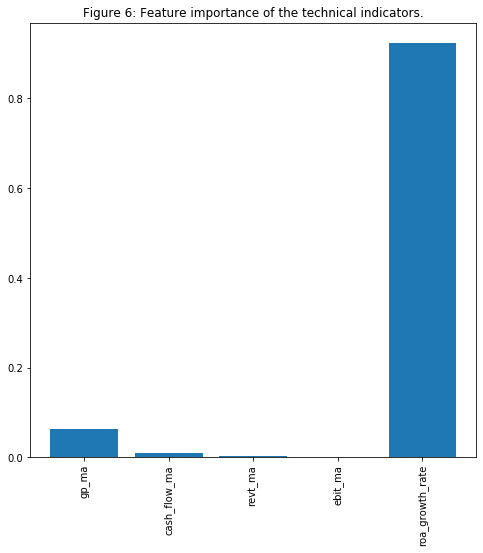

 45%|████▍     | 227/507 [05:09<04:27,  1.04it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


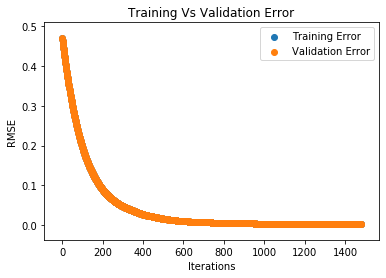

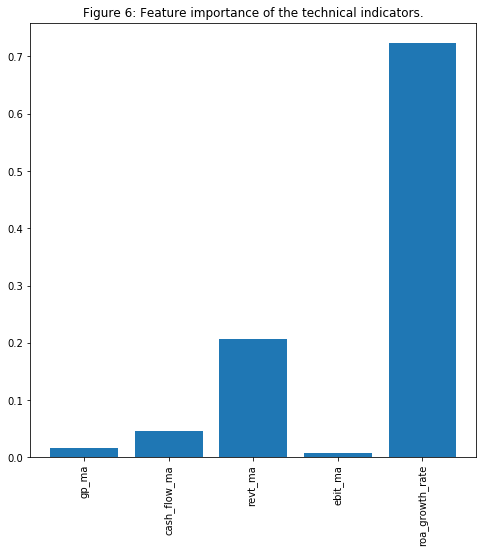

 45%|████▍     | 228/507 [05:12<06:27,  1.39s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1


 46%|████▌     | 233/507 [05:13<03:41,  1.24it/s]

1
1
1
1
1
[15:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


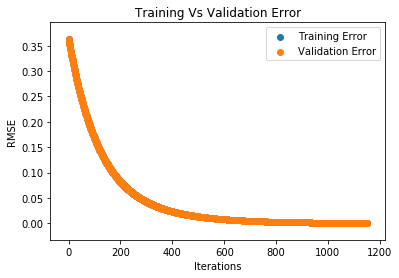

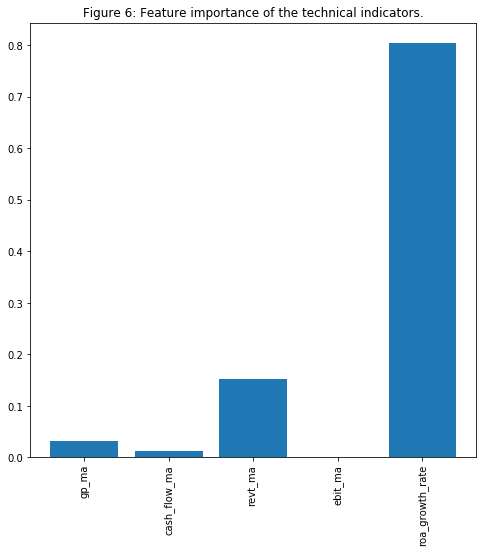

 46%|████▋     | 235/507 [05:15<03:52,  1.17it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:40:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


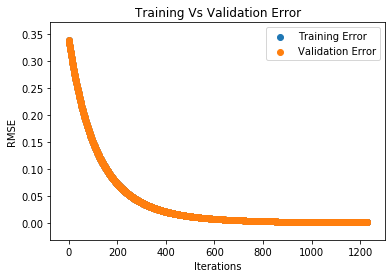

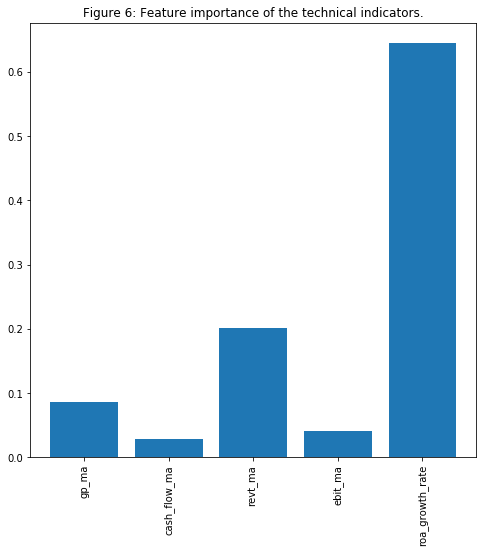

 47%|████▋     | 237/507 [05:17<04:15,  1.06it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:40:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


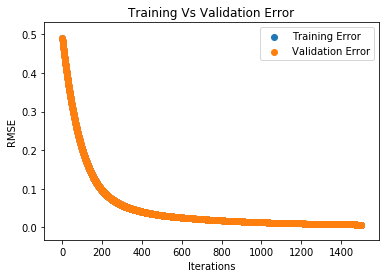

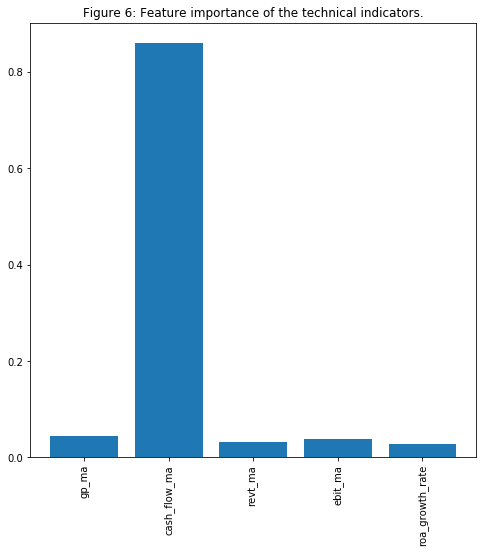

 47%|████▋     | 240/507 [05:20<04:03,  1.09it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:40:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


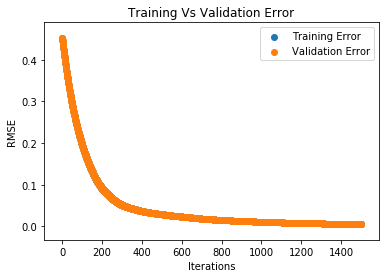

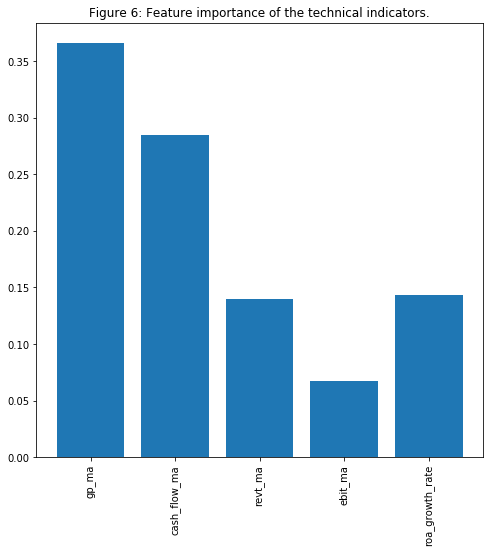

 48%|████▊     | 241/507 [05:22<05:53,  1.33s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:40:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


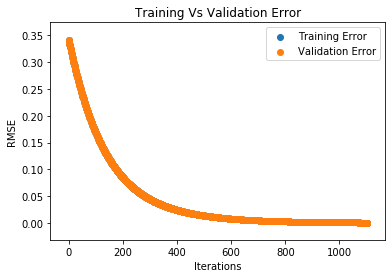

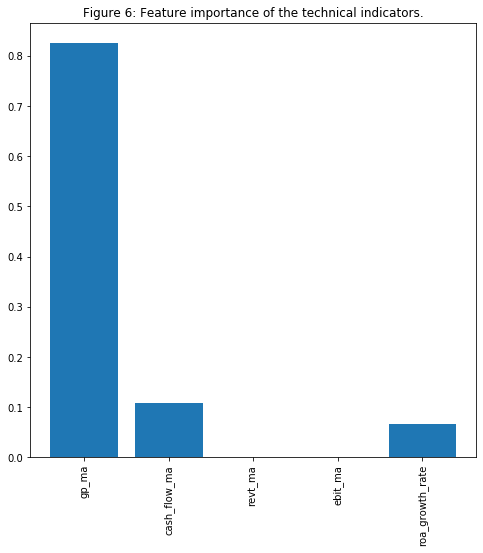

 48%|████▊     | 242/507 [05:24<06:58,  1.58s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:40:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


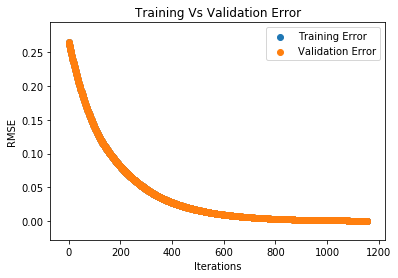

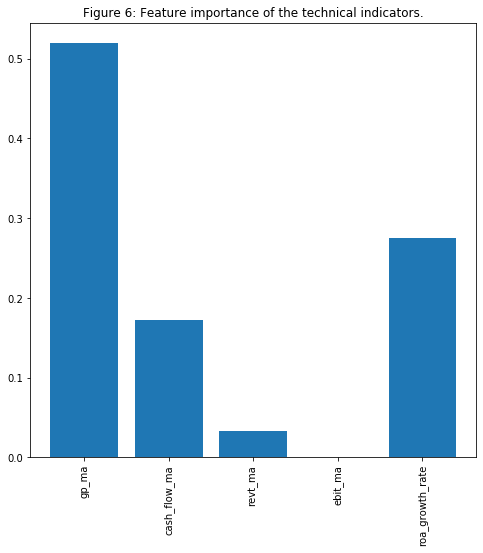

 48%|████▊     | 243/507 [05:26<07:20,  1.67s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:40:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


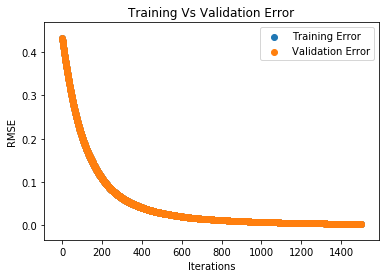

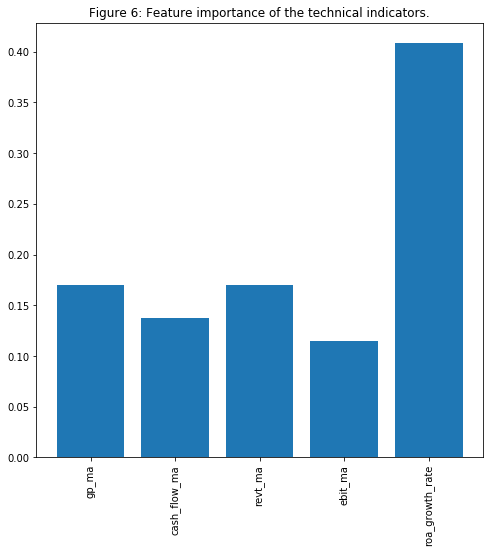

 48%|████▊     | 244/507 [05:29<08:19,  1.90s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


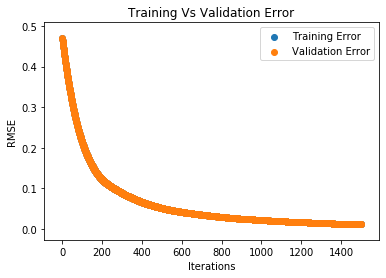

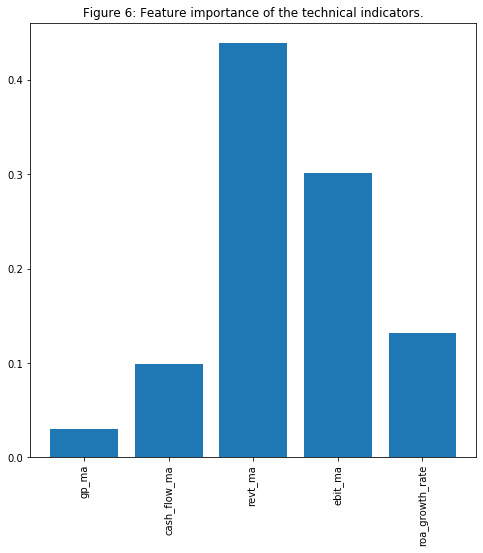

 49%|████▊     | 246/507 [05:31<07:20,  1.69s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:40:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


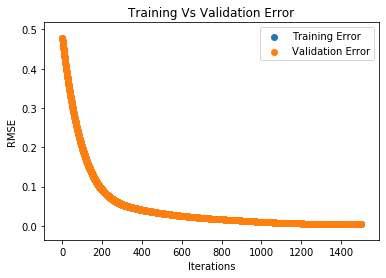

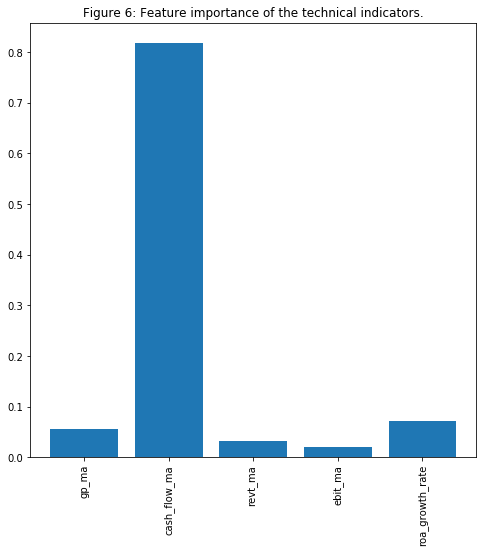

 49%|████▊     | 247/507 [05:33<08:16,  1.91s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


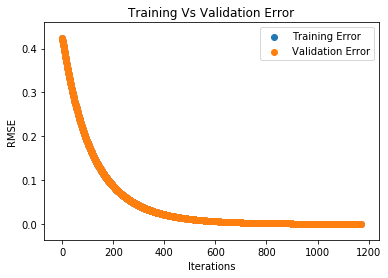

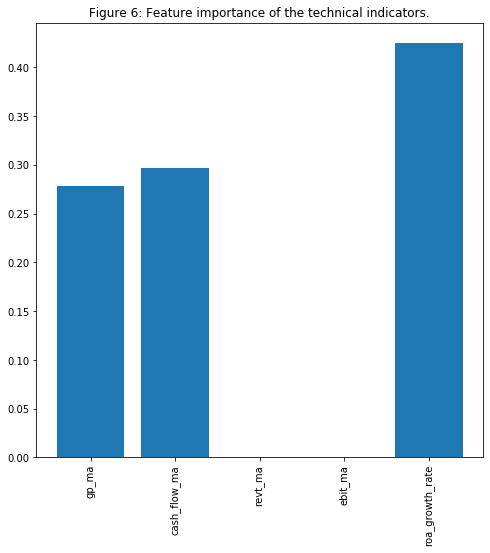

 49%|████▉     | 248/507 [05:35<08:15,  1.91s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


1
[15:40:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


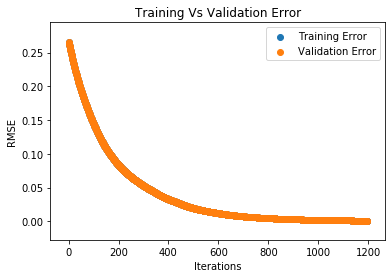

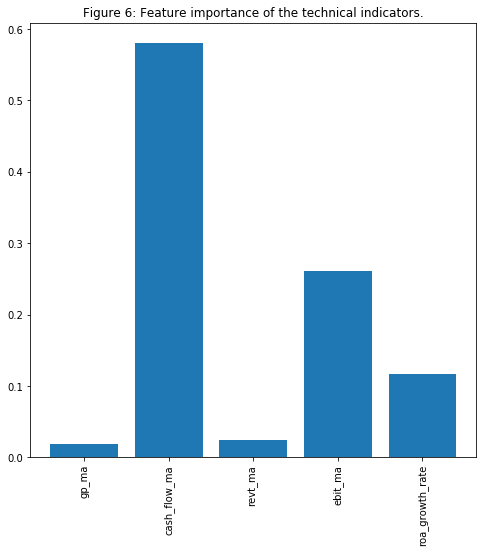

 49%|████▉     | 250/507 [05:37<06:58,  1.63s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
 50%|████▉     | 251/507 [05:38<05:52,  1.38s/it]

1
[15:40:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


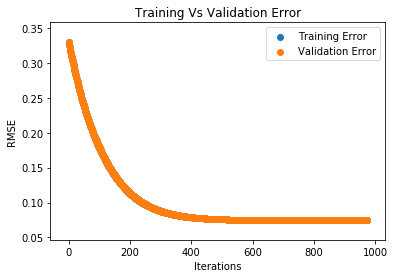

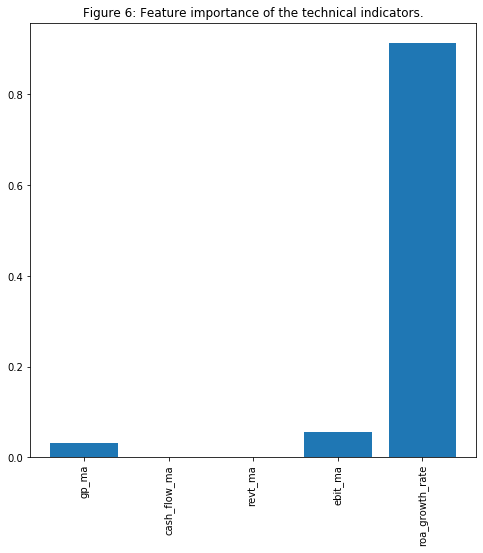

 50%|████▉     | 252/507 [05:40<06:27,  1.52s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1


 50%|█████     | 254/507 [05:41<05:10,  1.23s/it]

1
[15:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


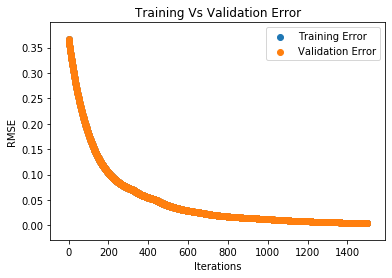

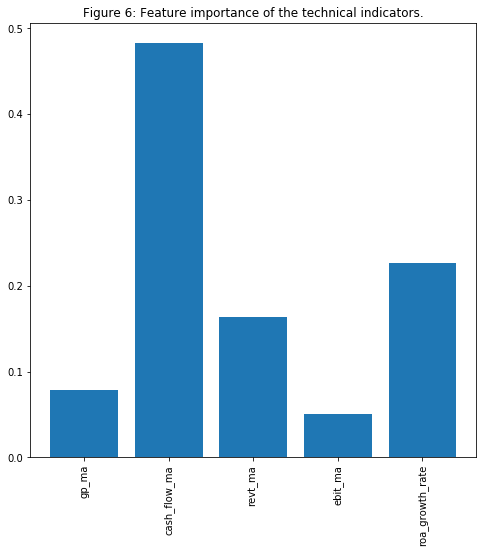

 50%|█████     | 255/507 [05:43<06:42,  1.60s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:40:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


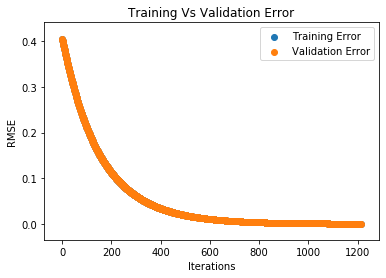

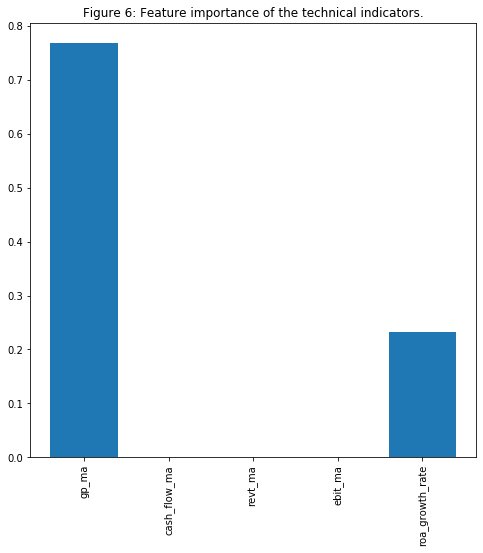

 50%|█████     | 256/507 [05:45<06:59,  1.67s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:40:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


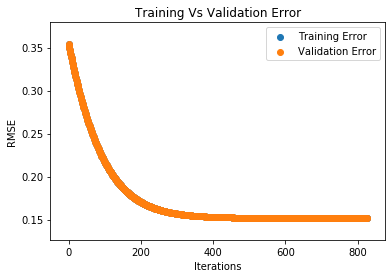

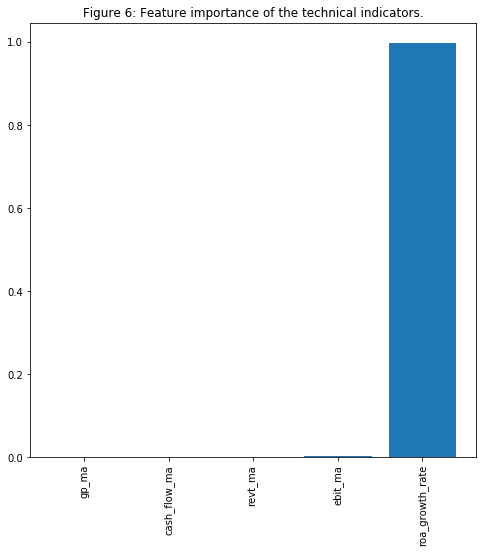

 51%|█████     | 257/507 [05:47<07:14,  1.74s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


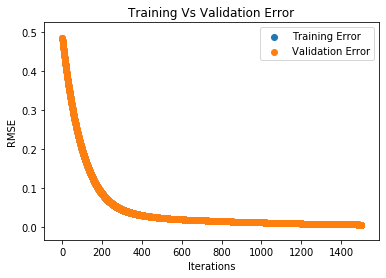

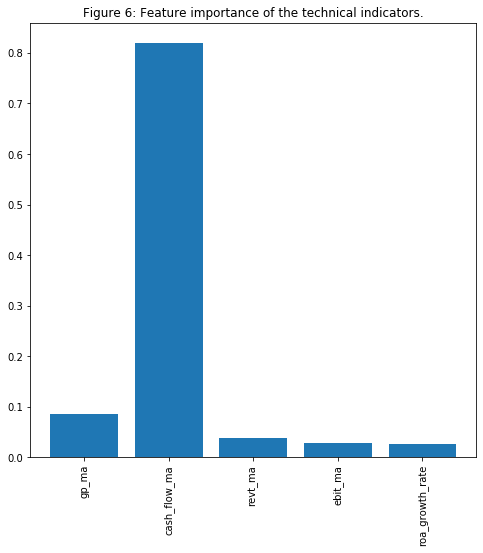

 51%|█████     | 259/507 [05:50<06:42,  1.62s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:40:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


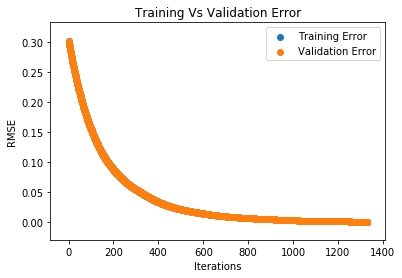

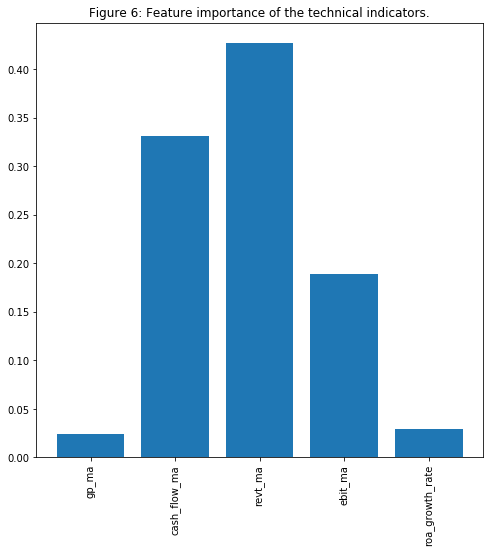

 51%|█████▏    | 261/507 [05:52<05:53,  1.44s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
 52%|█████▏    | 262/507 [05:53<05:09,  1.26s/it]

1
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


[15:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


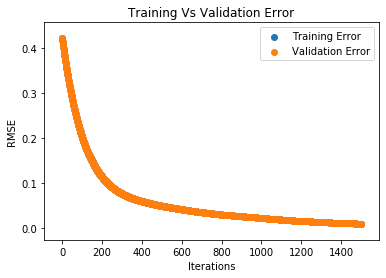

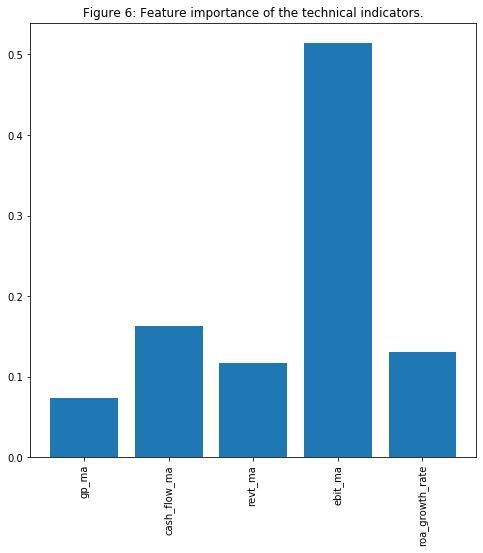

 52%|█████▏    | 264/507 [05:55<04:57,  1.23s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


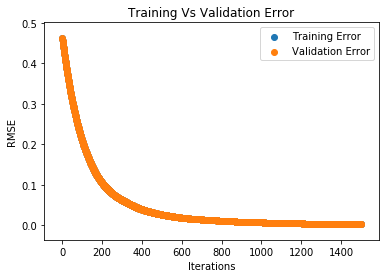

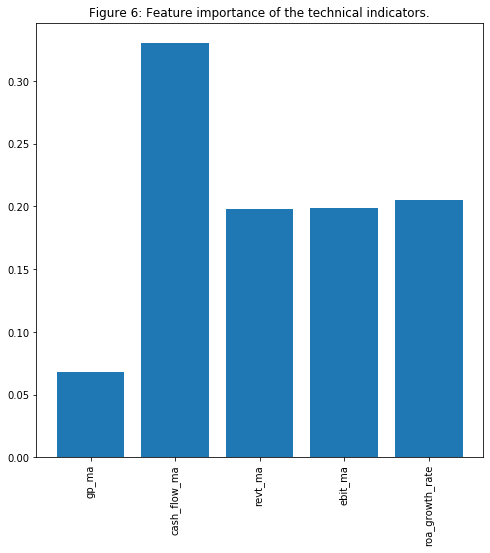

 53%|█████▎    | 269/507 [05:58<03:26,  1.15it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
1
[15:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


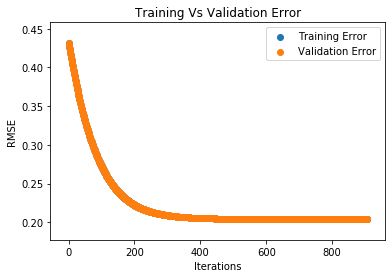

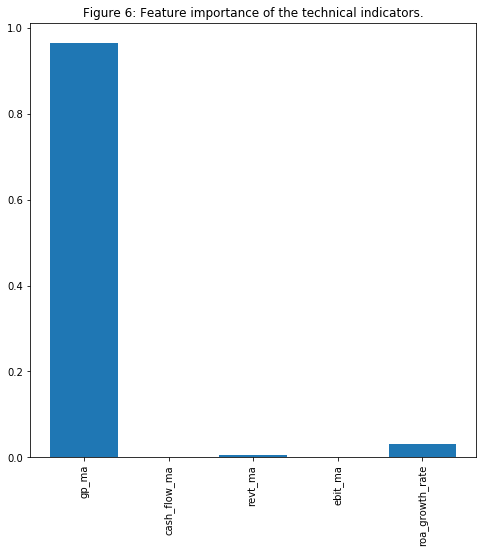

 53%|█████▎    | 270/507 [05:59<04:35,  1.16s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


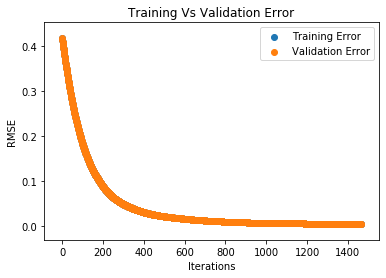

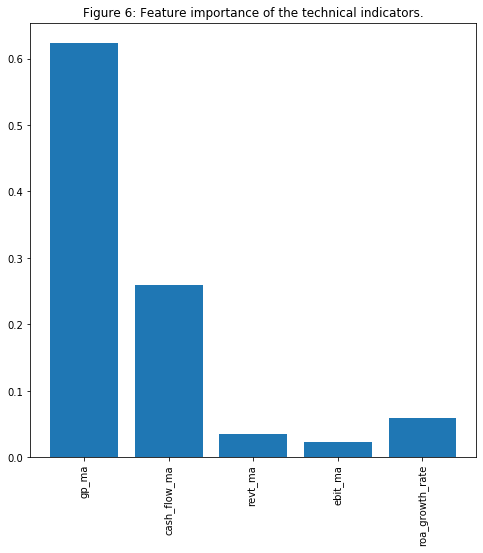

 53%|█████▎    | 271/507 [06:02<06:00,  1.53s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


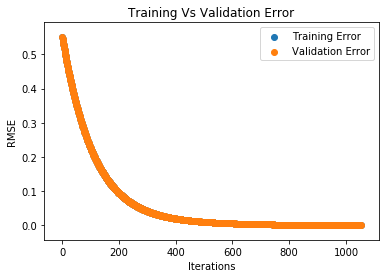

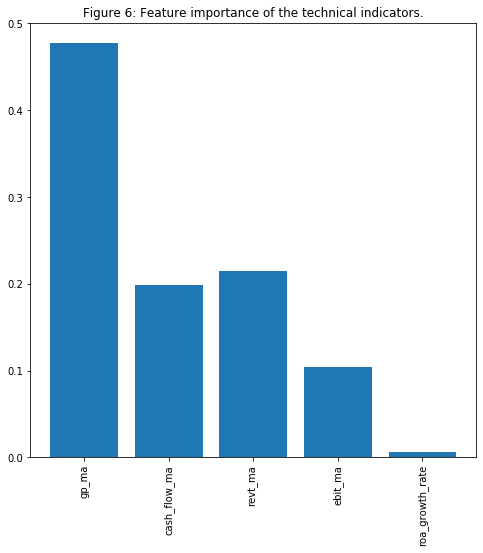

 54%|█████▎    | 272/507 [06:04<06:32,  1.67s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


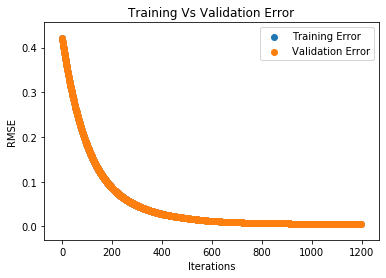

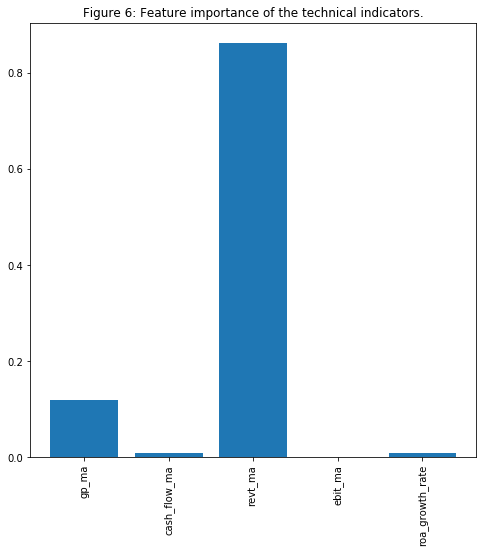

 54%|█████▍    | 273/507 [06:06<06:49,  1.75s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


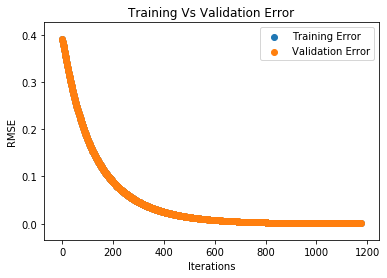

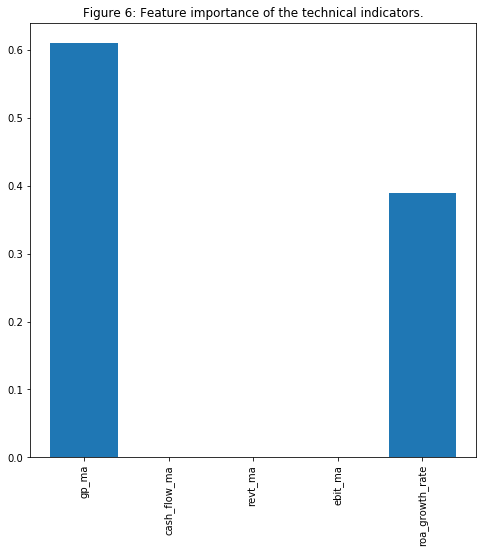

 54%|█████▍    | 274/507 [06:08<06:49,  1.76s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


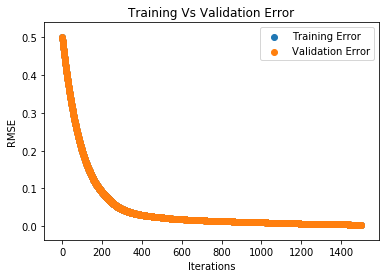

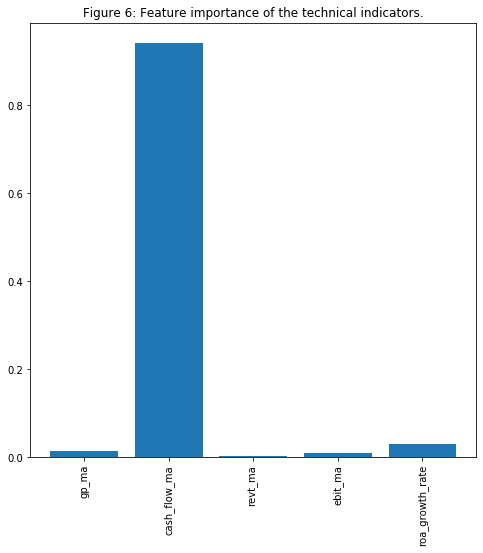

 54%|█████▍    | 275/507 [06:10<07:23,  1.91s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


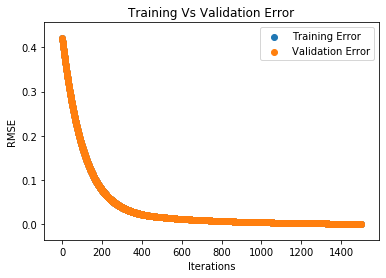

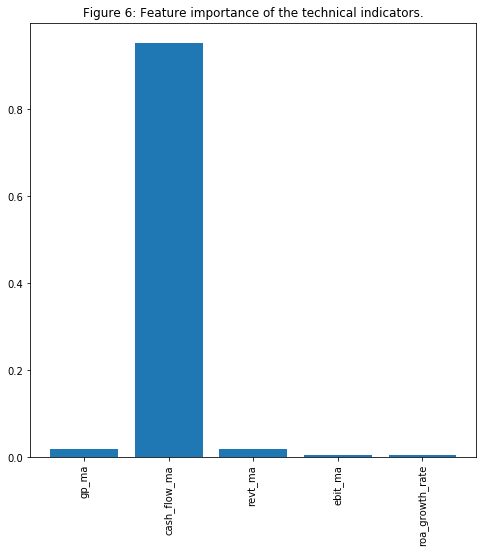

 54%|█████▍    | 276/507 [06:12<07:50,  2.04s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


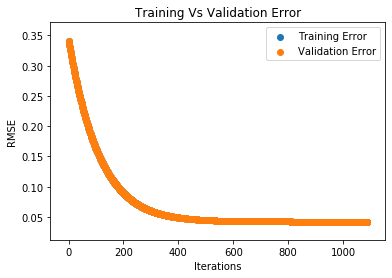

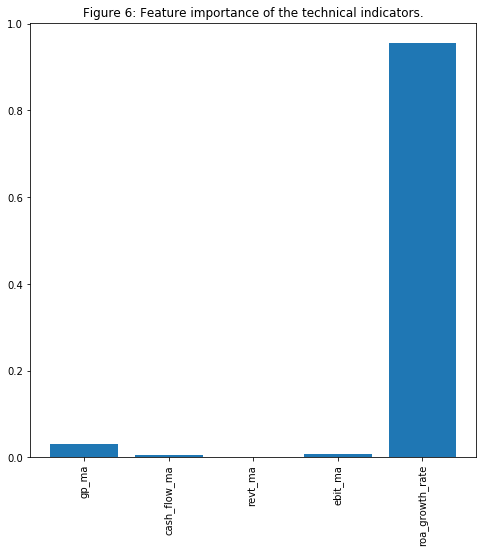

 55%|█████▍    | 277/507 [06:14<07:29,  1.96s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


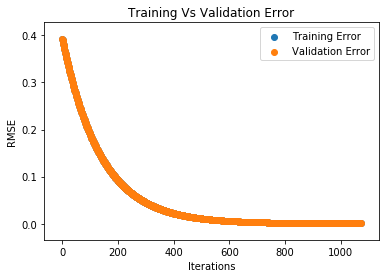

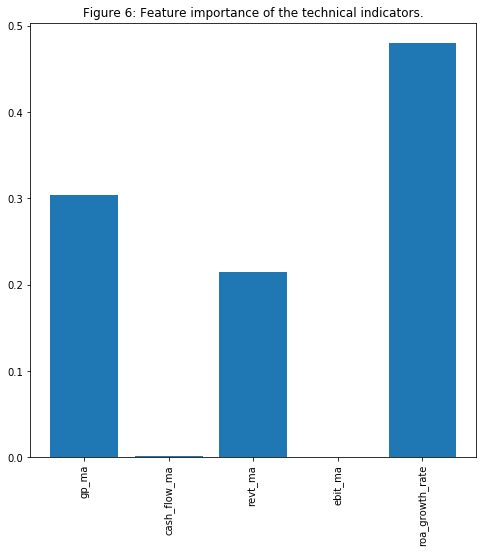

 55%|█████▌    | 281/507 [06:17<05:13,  1.39s/it]

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


[15:41:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


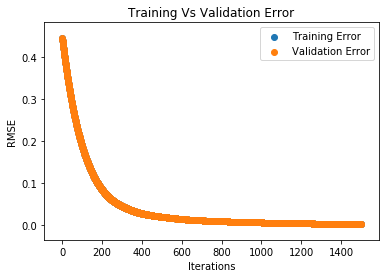

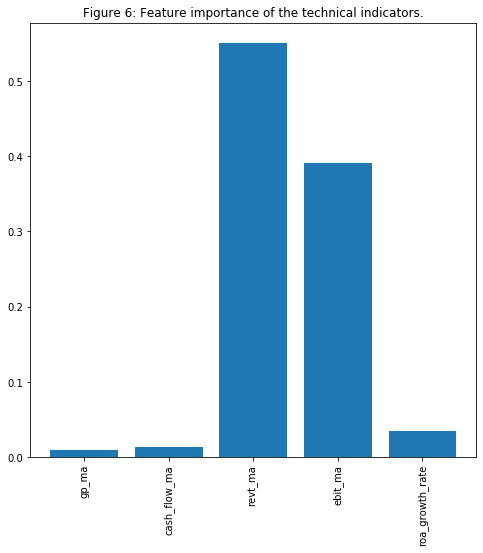

 56%|█████▌    | 282/507 [06:19<06:11,  1.65s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


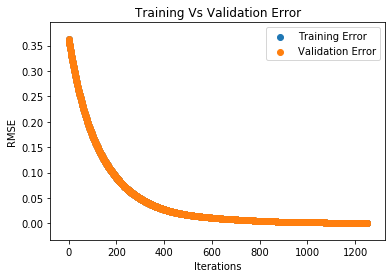

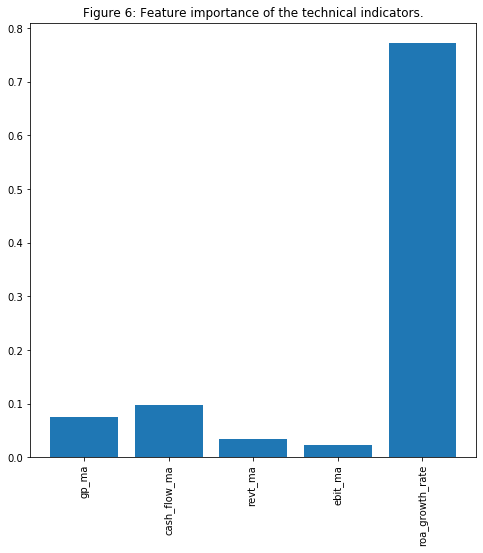

 56%|█████▌    | 283/507 [06:21<06:42,  1.80s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


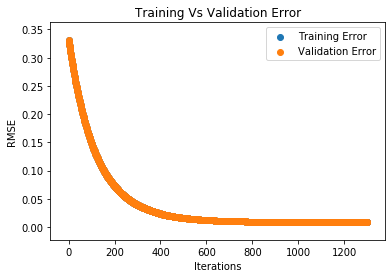

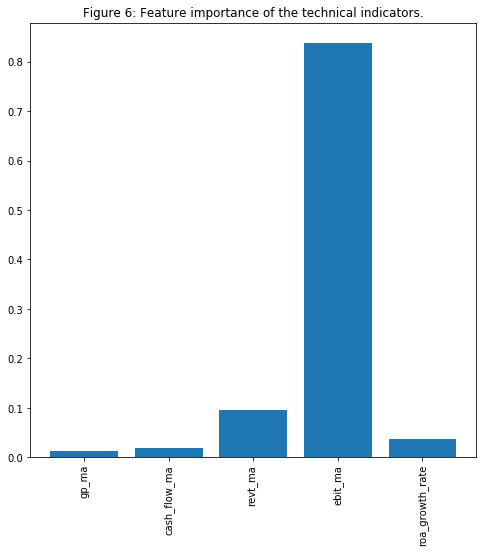

 56%|█████▌    | 284/507 [06:24<07:13,  1.94s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:41:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


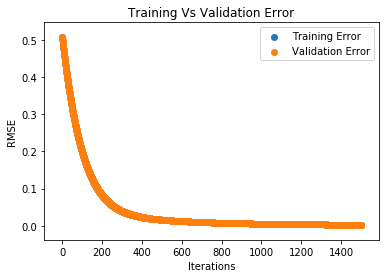

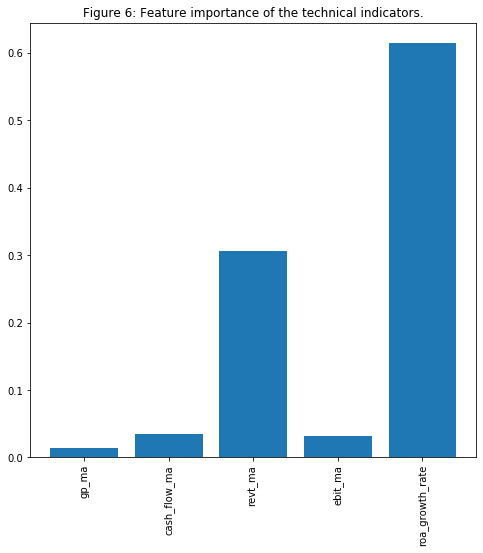

 56%|█████▋    | 286/507 [06:26<06:18,  1.71s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


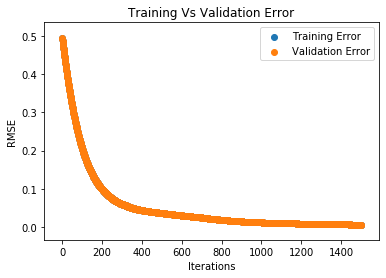

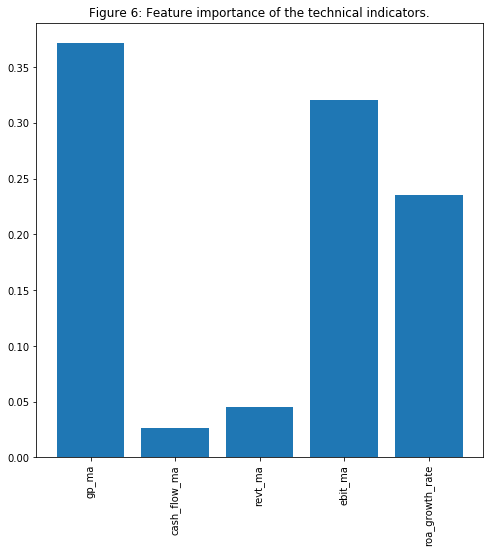

 57%|█████▋    | 287/507 [06:28<07:02,  1.92s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


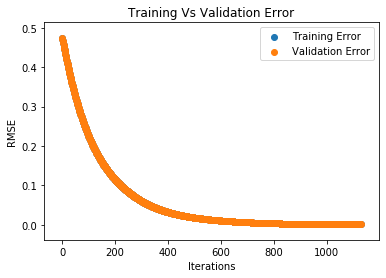

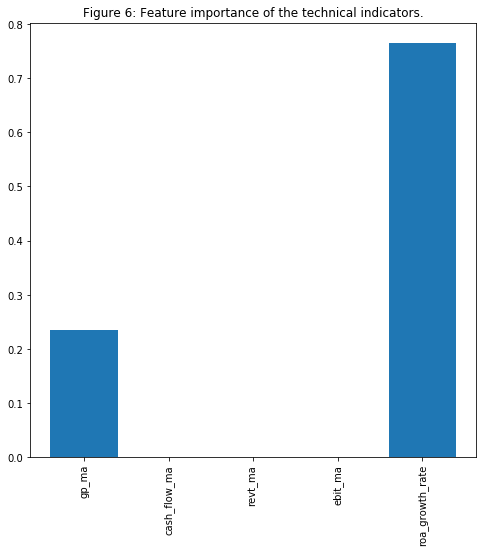

 57%|█████▋    | 288/507 [06:30<07:03,  1.93s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


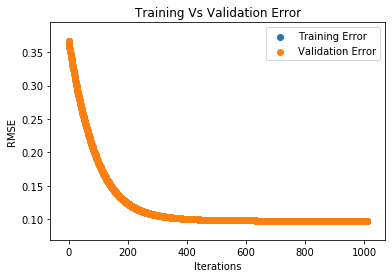

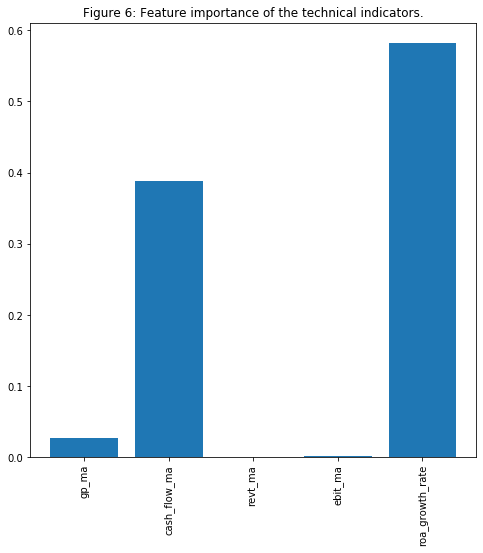

 57%|█████▋    | 289/507 [06:32<07:08,  1.96s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


[15:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


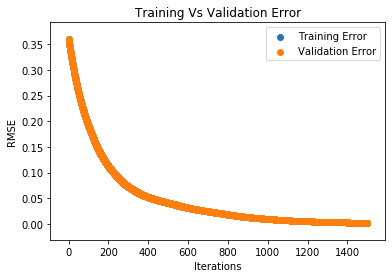

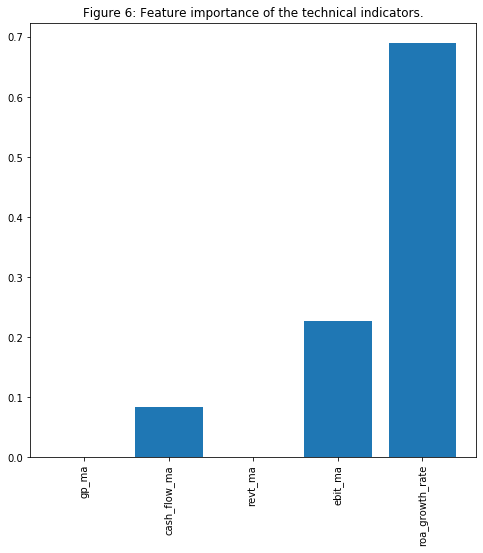

 57%|█████▋    | 290/507 [06:35<07:29,  2.07s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


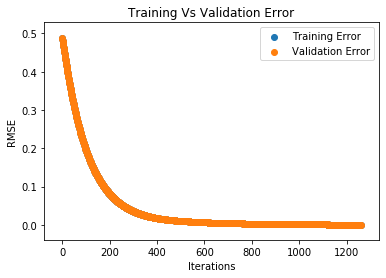

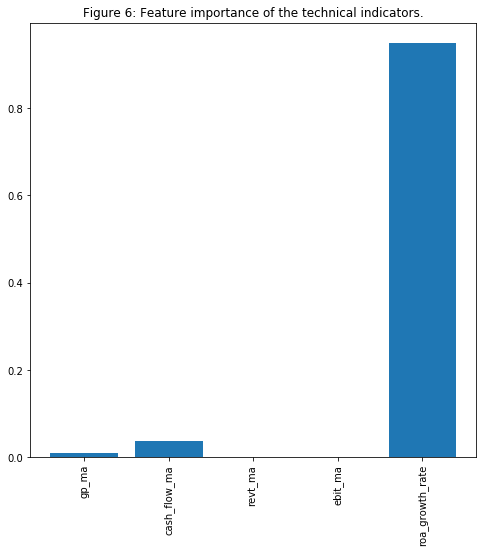

 57%|█████▋    | 291/507 [06:37<07:30,  2.09s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


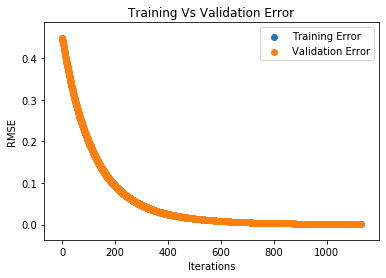

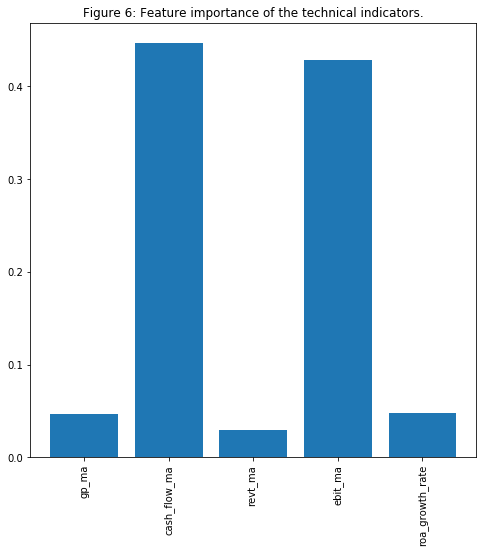

 58%|█████▊    | 292/507 [06:39<07:14,  2.02s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


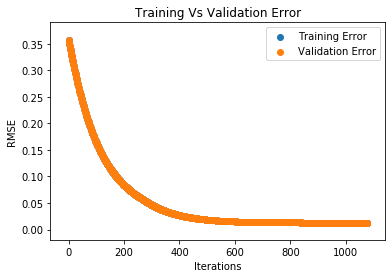

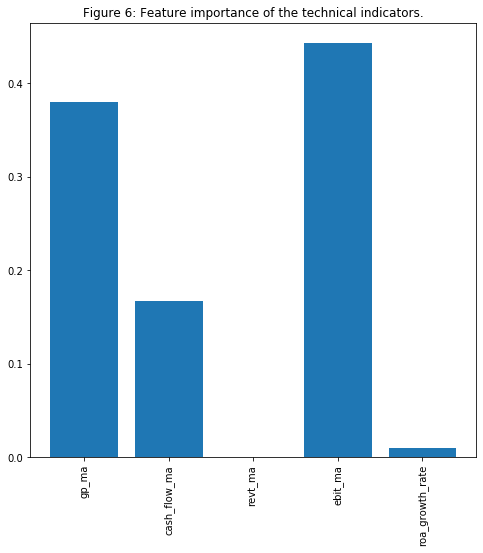

 58%|█████▊    | 295/507 [06:41<05:47,  1.64s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


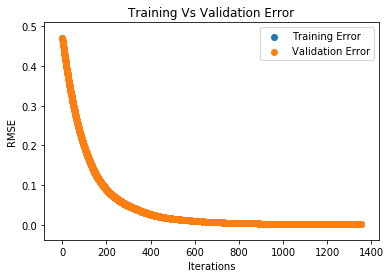

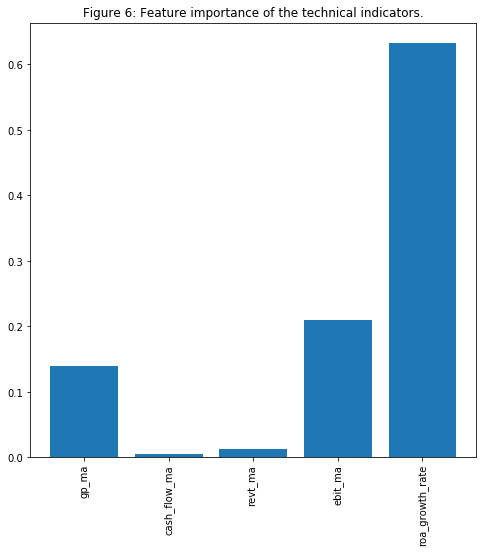

 58%|█████▊    | 296/507 [06:43<06:08,  1.75s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


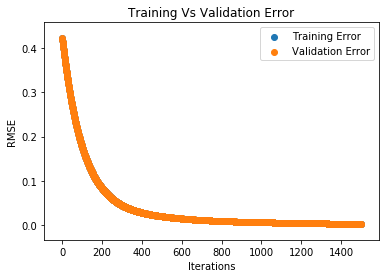

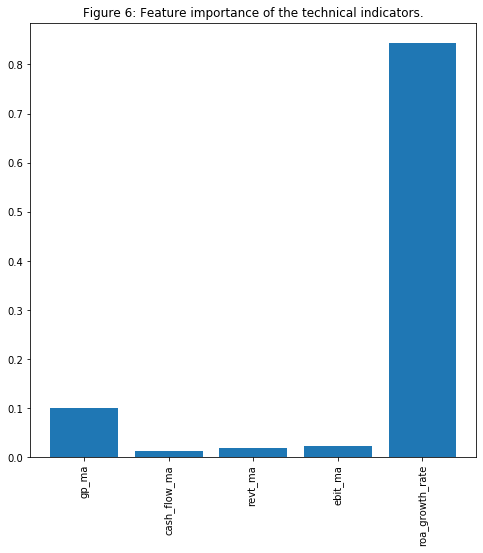

 59%|█████▊    | 297/507 [06:46<06:53,  1.97s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:41:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


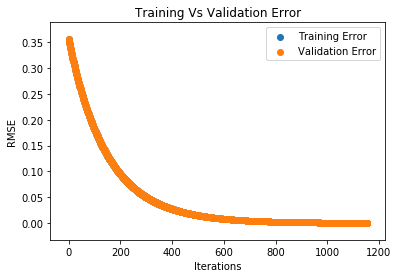

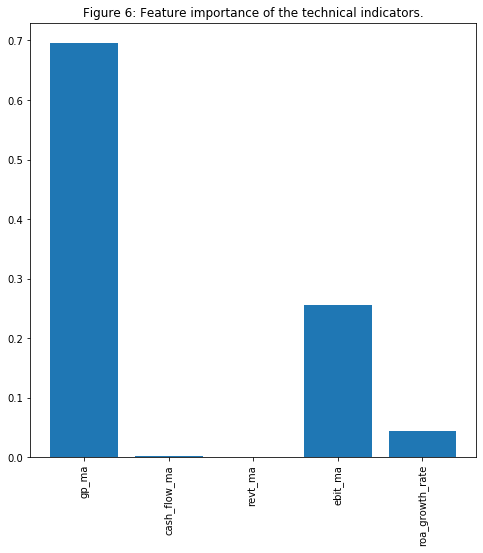

 59%|█████▉    | 298/507 [06:48<07:52,  2.26s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:41:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


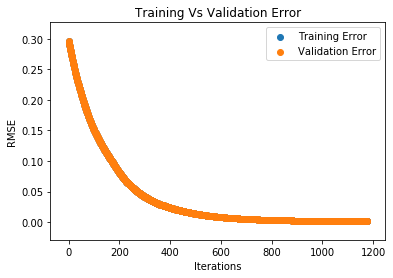

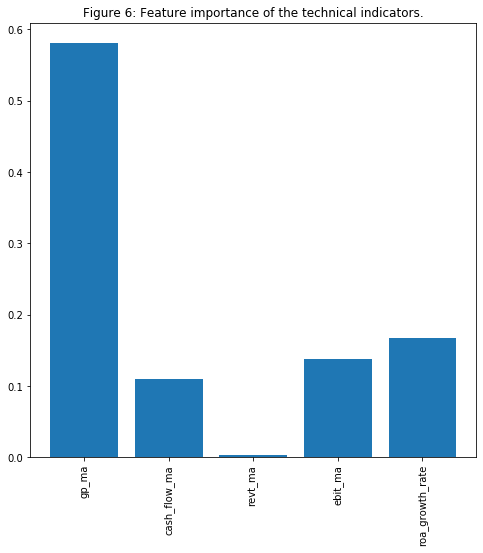

 59%|█████▉    | 300/507 [06:51<06:36,  1.92s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:41:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


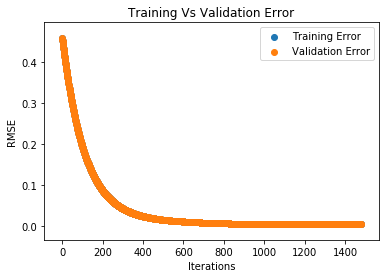

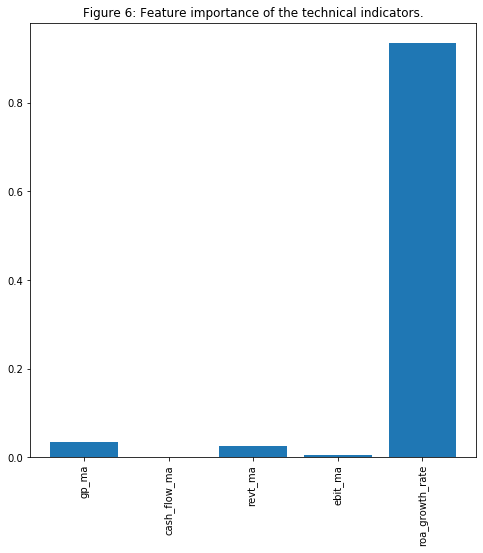

 60%|█████▉    | 302/507 [06:53<05:43,  1.67s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


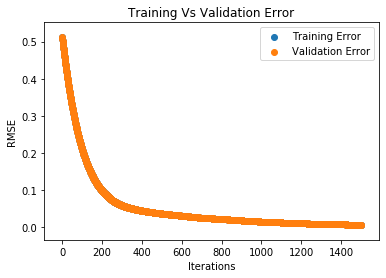

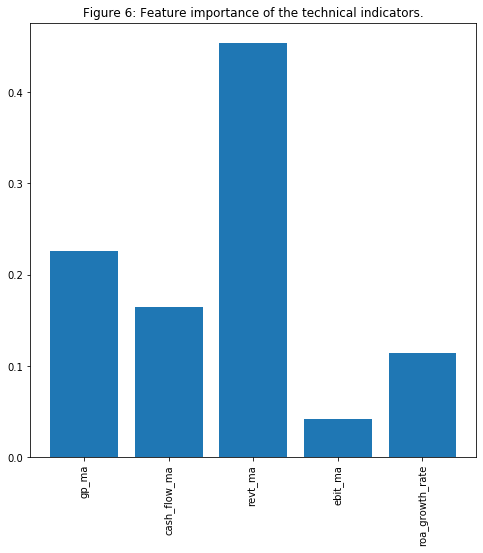

 60%|█████▉    | 304/507 [06:55<05:14,  1.55s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


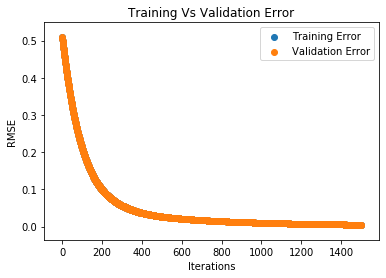

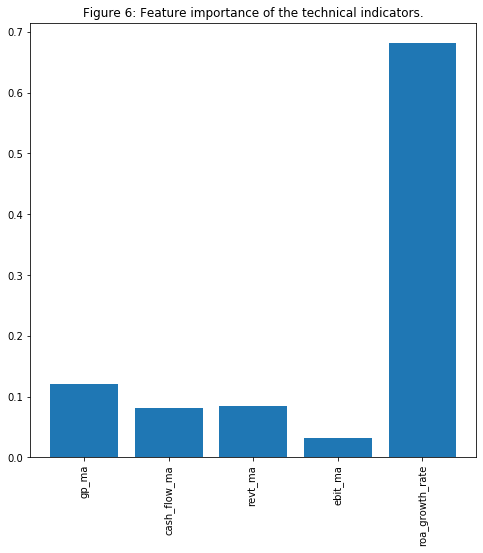

 60%|██████    | 305/507 [06:58<05:50,  1.74s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


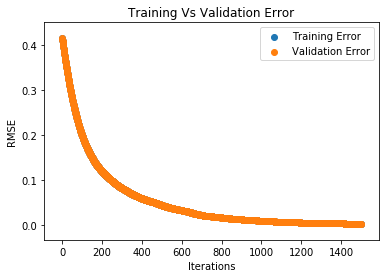

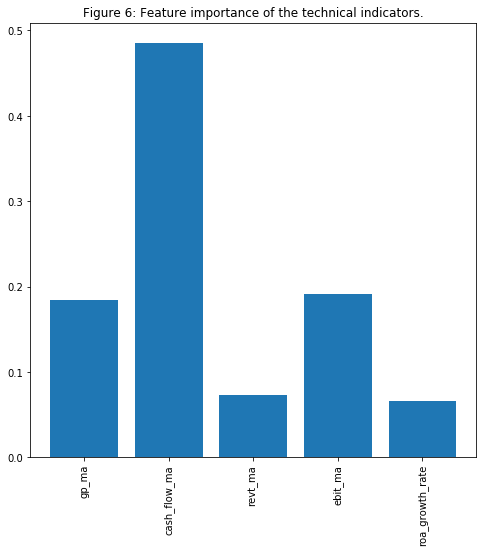

 60%|██████    | 306/507 [07:00<06:35,  1.97s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


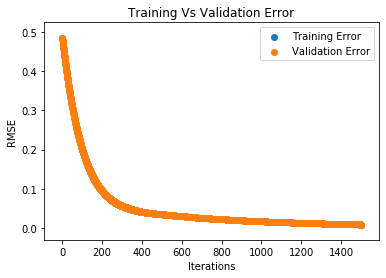

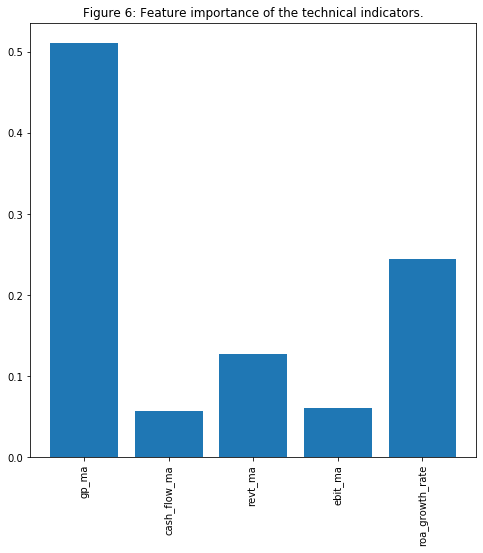

 61%|██████    | 307/507 [07:03<07:01,  2.11s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


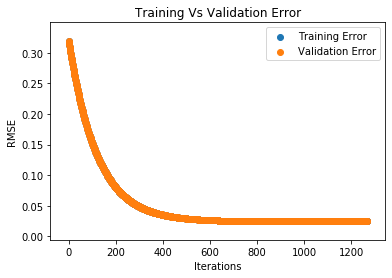

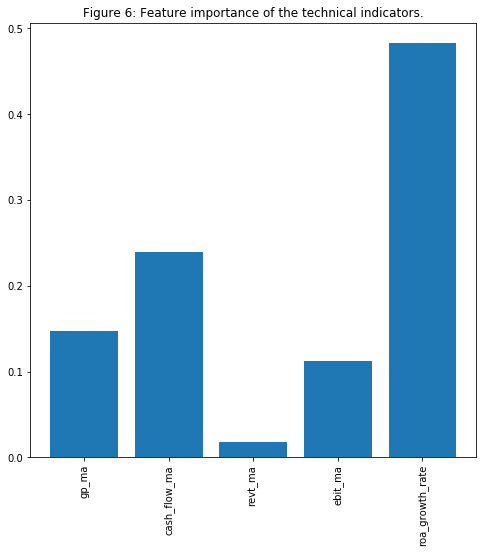

 61%|██████    | 308/507 [07:05<07:06,  2.14s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:42:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


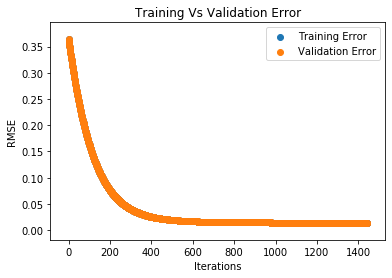

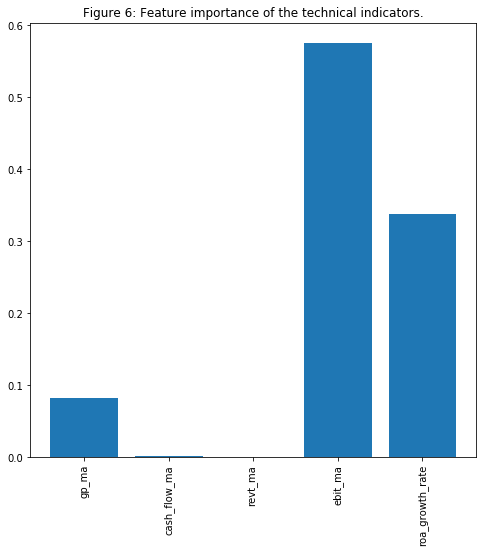

 61%|██████    | 310/507 [07:07<06:01,  1.83s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


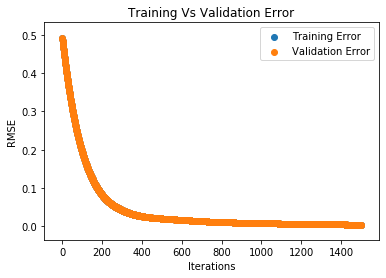

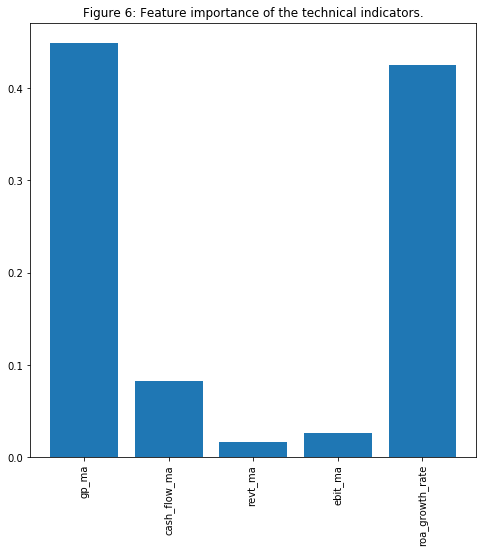

 61%|██████▏   | 311/507 [07:09<06:31,  2.00s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:42:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


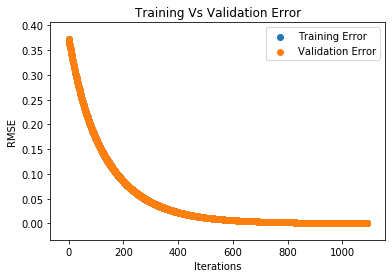

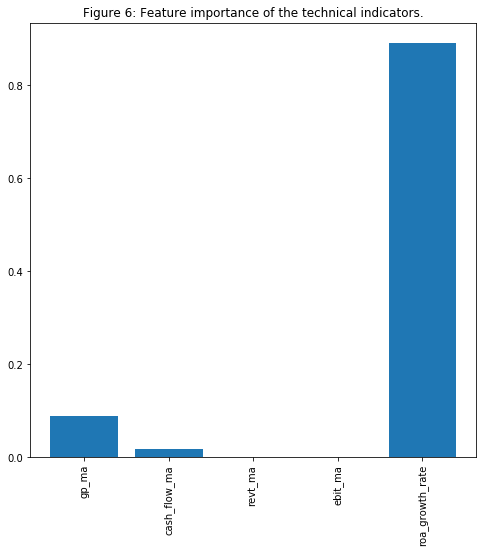

 62%|██████▏   | 313/507 [07:11<05:31,  1.71s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


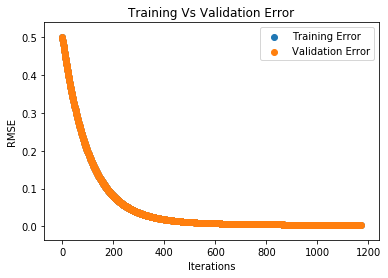

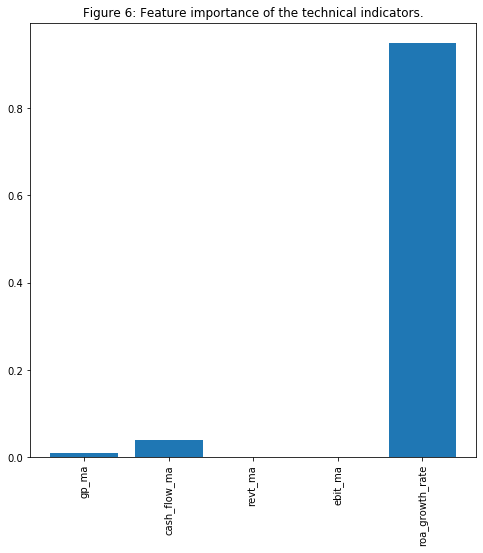

 63%|██████▎   | 317/507 [07:14<04:11,  1.32s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
1
1


 63%|██████▎   | 319/507 [07:15<03:24,  1.09s/it]

1
[15:42:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


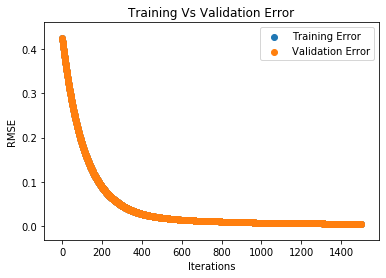

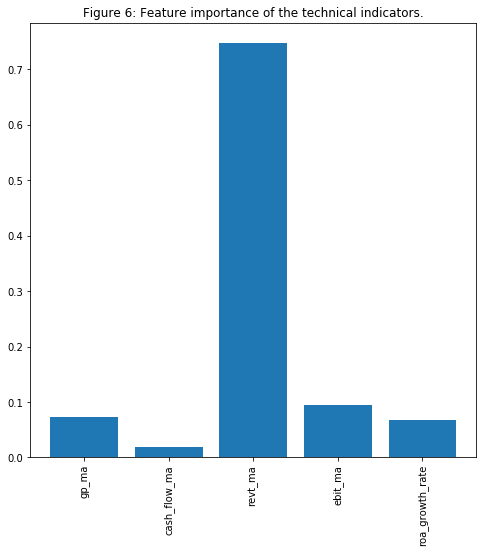

 63%|██████▎   | 320/507 [07:17<04:42,  1.51s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


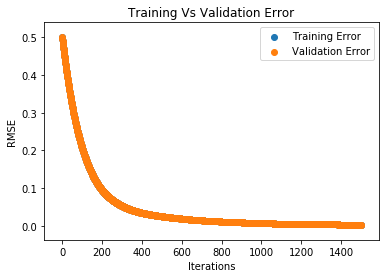

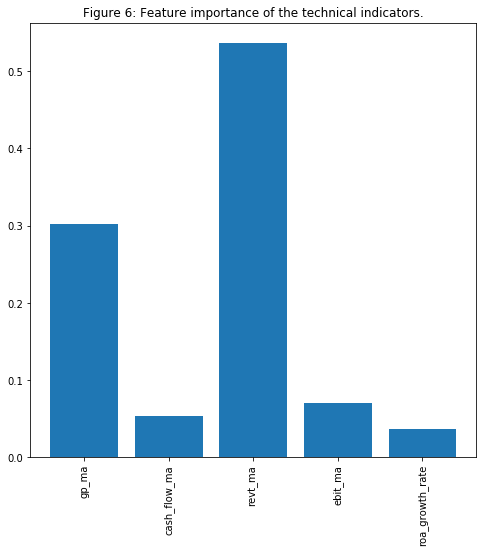

 63%|██████▎   | 321/507 [07:20<05:19,  1.72s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


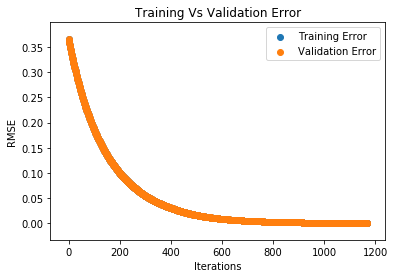

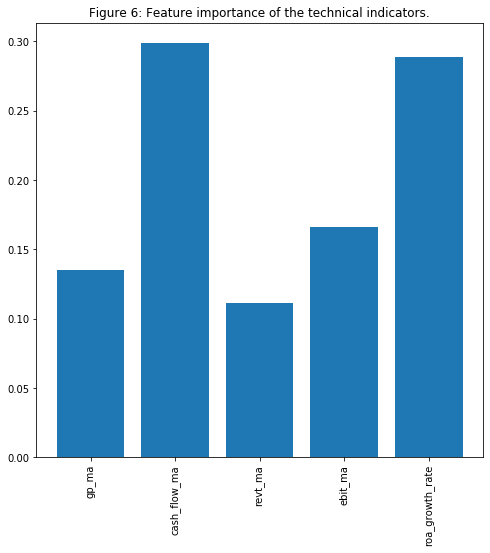

 64%|██████▎   | 322/507 [07:22<05:30,  1.79s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


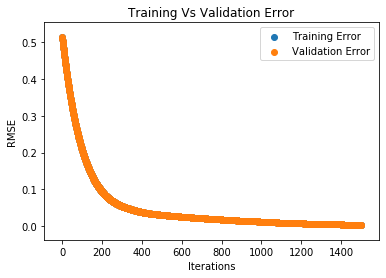

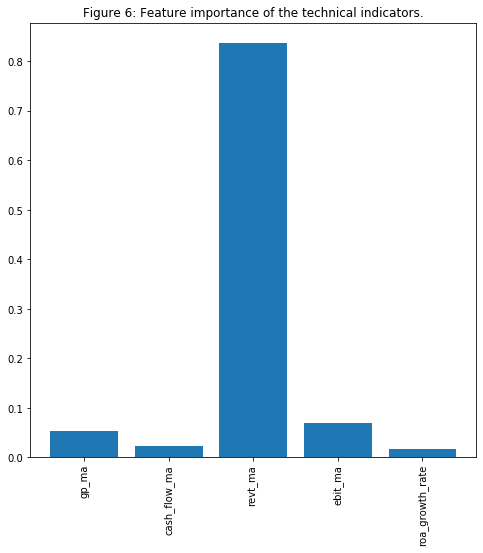

 64%|██████▎   | 323/507 [07:24<06:16,  2.05s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


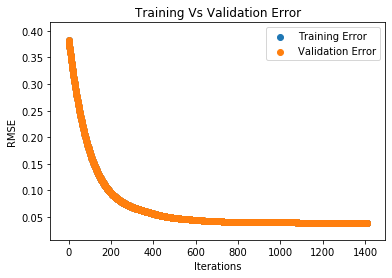

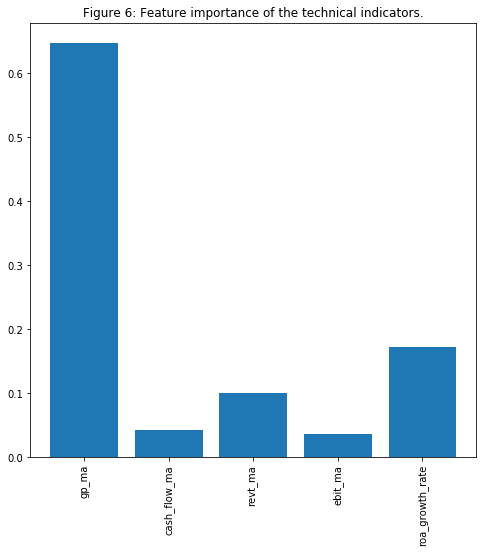

 64%|██████▍   | 324/507 [07:27<06:31,  2.14s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


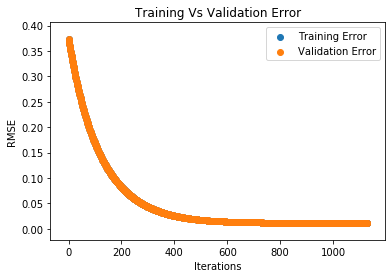

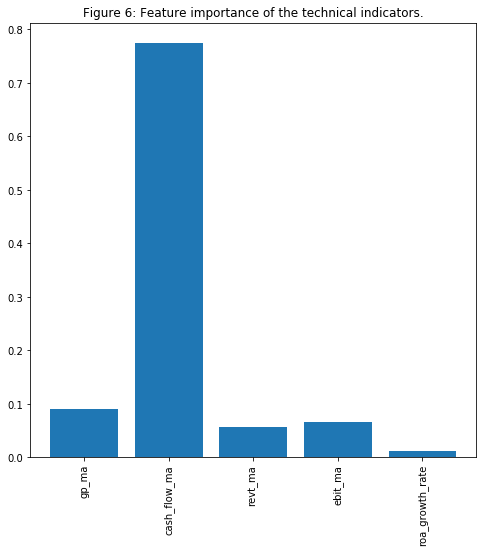

 64%|██████▍   | 325/507 [07:29<06:20,  2.09s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:42:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


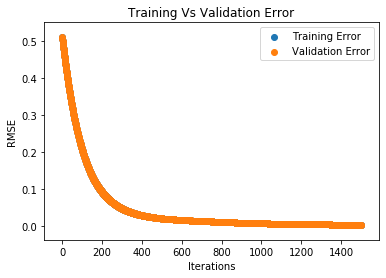

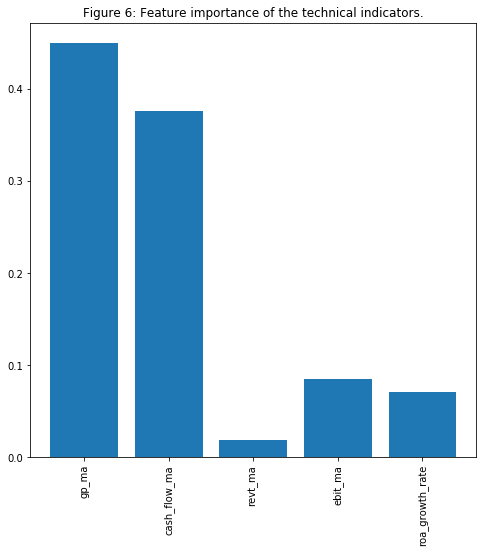

 64%|██████▍   | 327/507 [07:31<05:28,  1.83s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:42:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


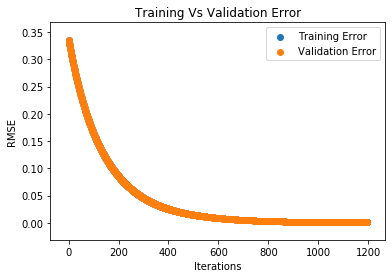

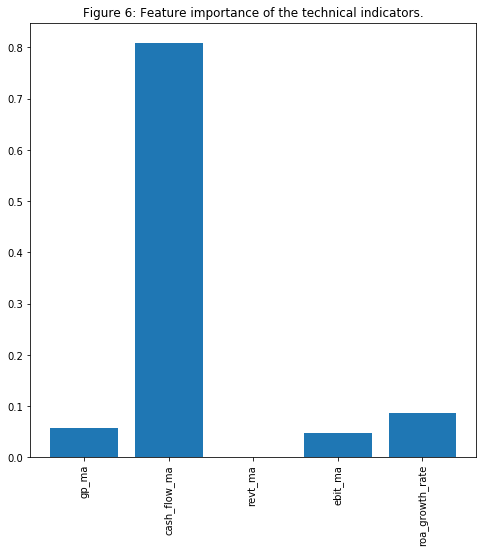

 65%|██████▍   | 329/507 [07:33<04:45,  1.60s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


1
1


 65%|██████▌   | 332/507 [07:34<03:33,  1.22s/it]

1
1
[15:42:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


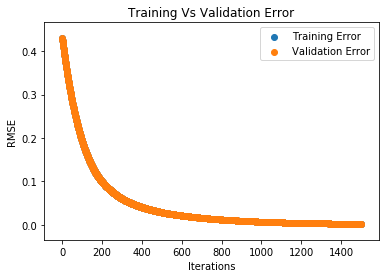

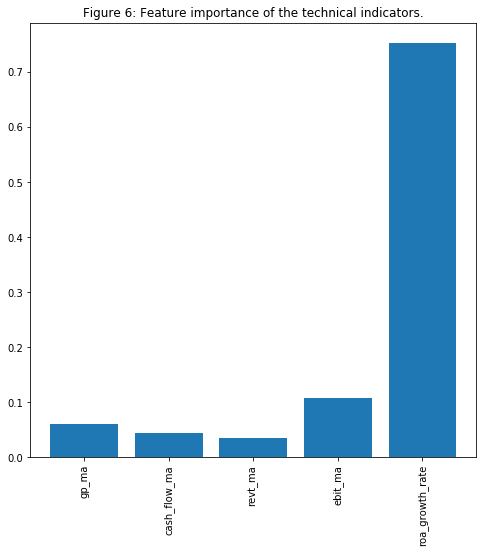

 66%|██████▌   | 334/507 [07:36<03:25,  1.19s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


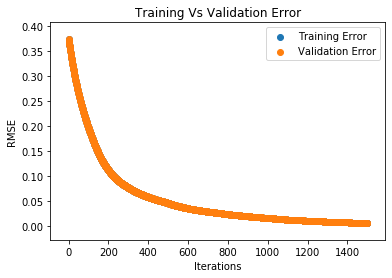

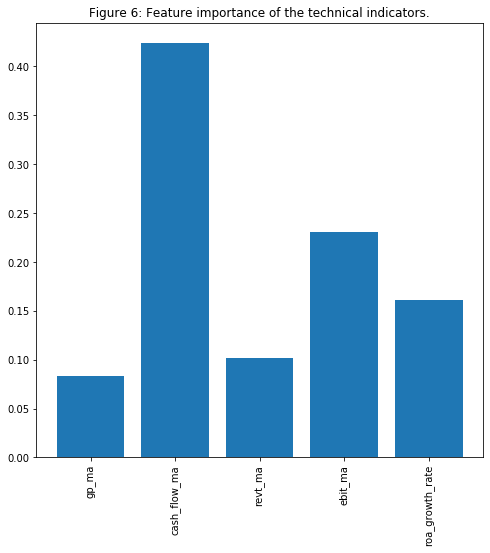

 66%|██████▌   | 335/507 [07:39<04:34,  1.60s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


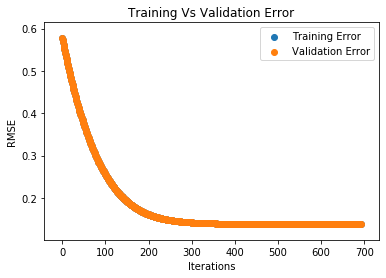

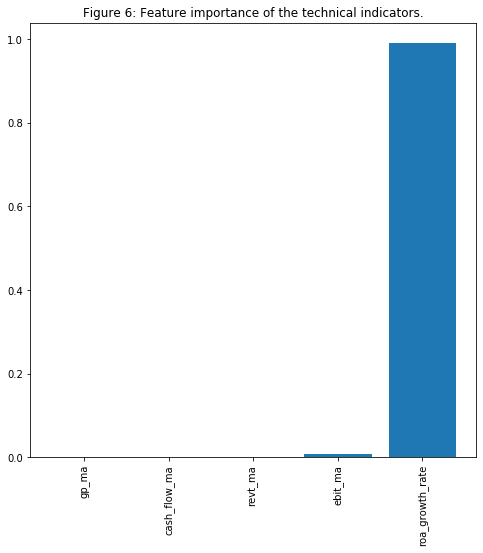

 66%|██████▋   | 336/507 [07:41<04:46,  1.67s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


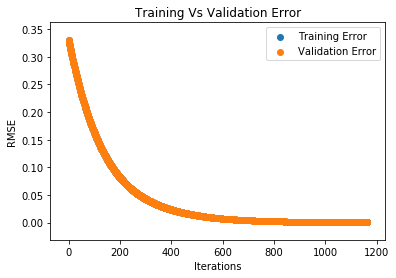

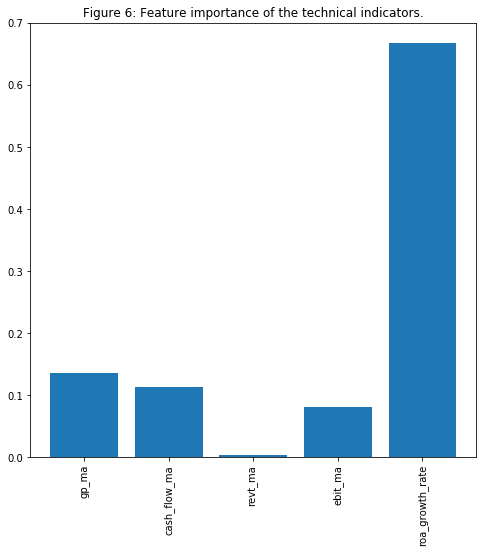

 66%|██████▋   | 337/507 [07:43<05:04,  1.79s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:42:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


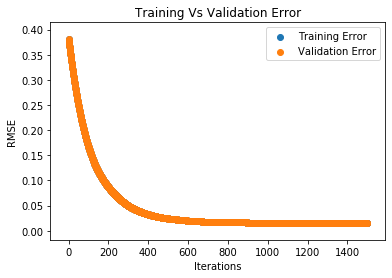

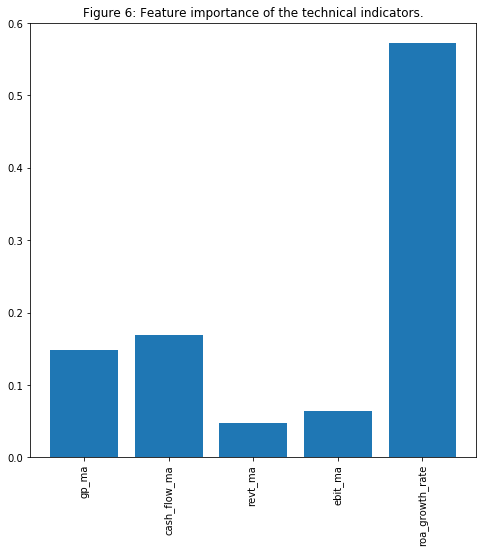

 67%|██████▋   | 340/507 [07:45<04:09,  1.50s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:42:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


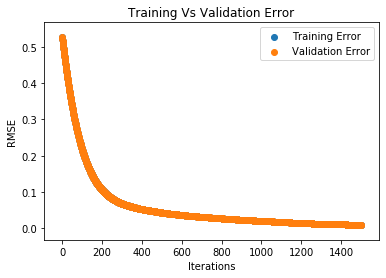

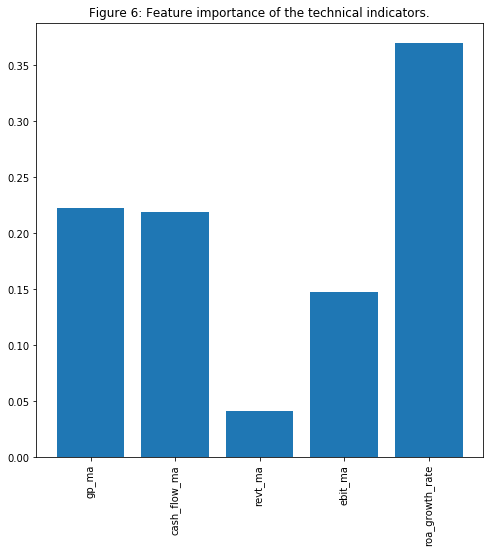

 68%|██████▊   | 343/507 [07:48<03:31,  1.29s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


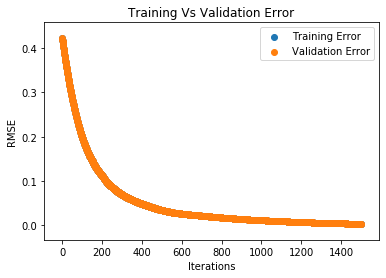

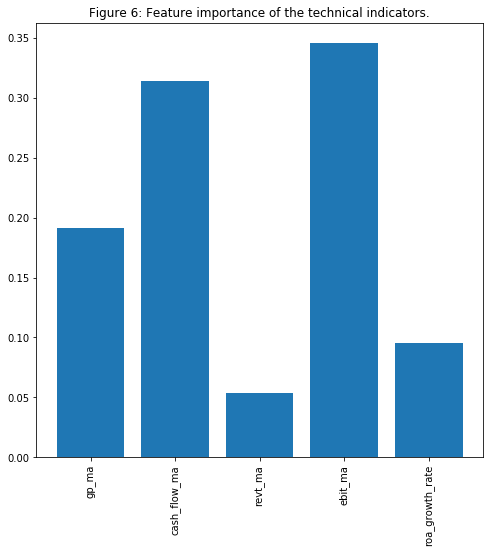

 68%|██████▊   | 344/507 [07:50<04:08,  1.52s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:42:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


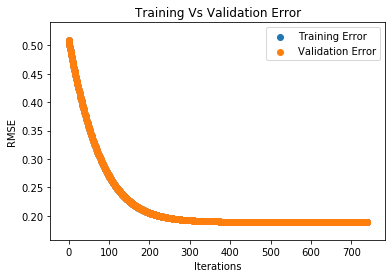

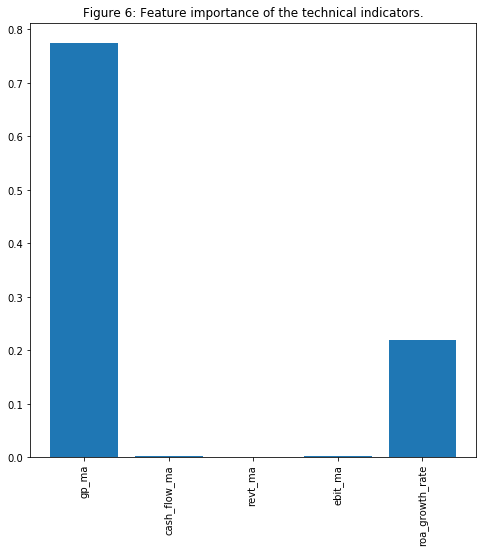

 68%|██████▊   | 345/507 [07:52<04:32,  1.68s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:42:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


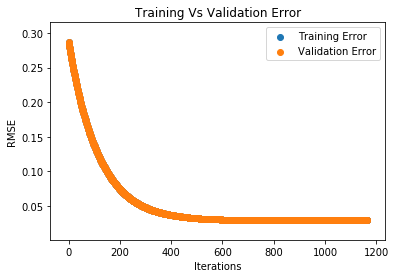

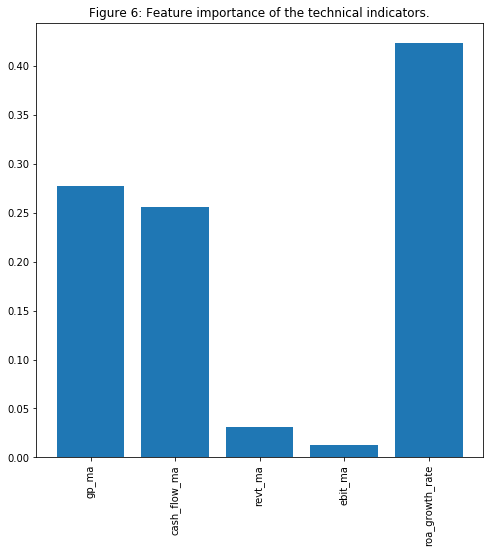

 68%|██████▊   | 347/507 [07:54<04:00,  1.50s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:43:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


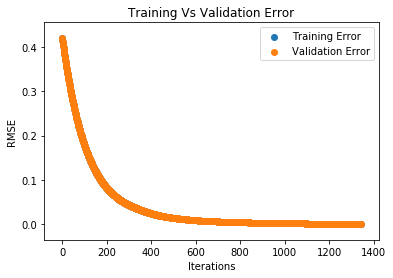

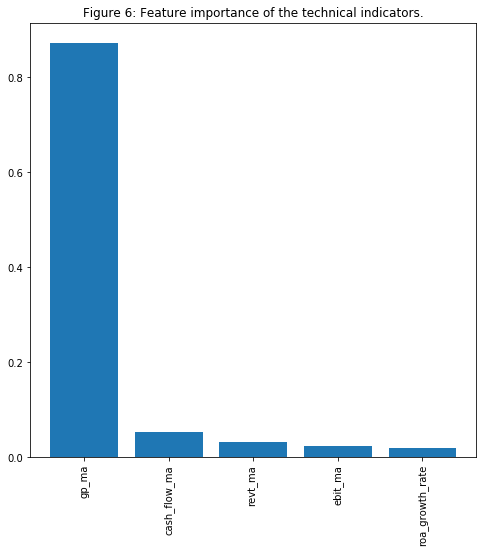

 69%|██████▉   | 349/507 [07:56<03:37,  1.38s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:43:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


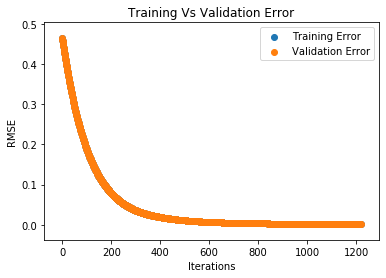

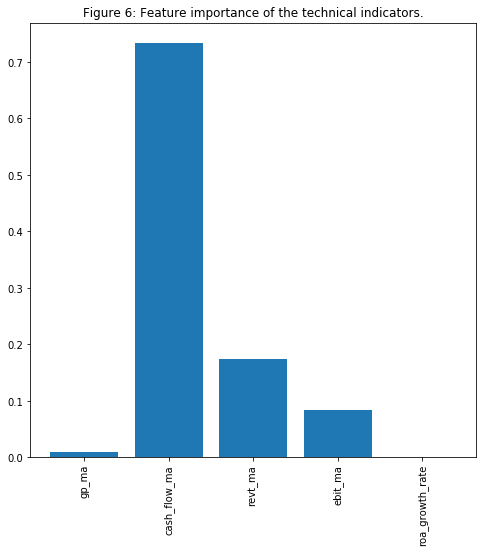

 69%|██████▉   | 351/507 [07:58<03:22,  1.30s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:43:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


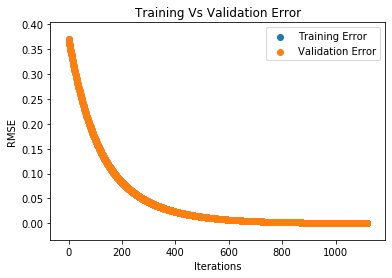

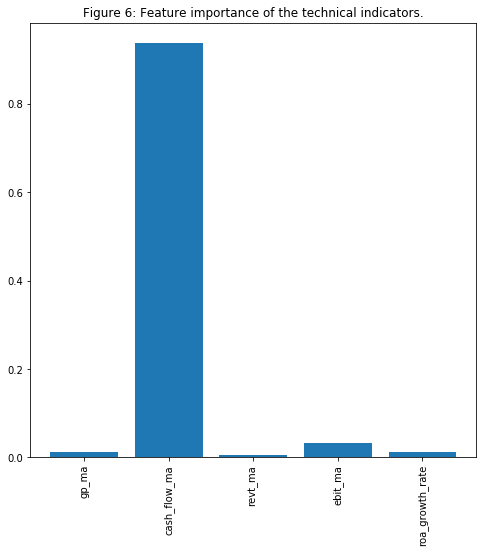

 70%|██████▉   | 354/507 [08:00<02:52,  1.12s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


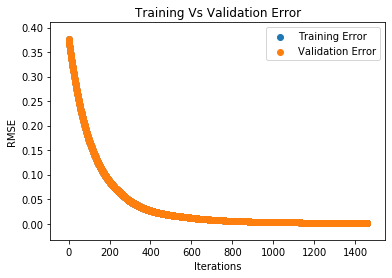

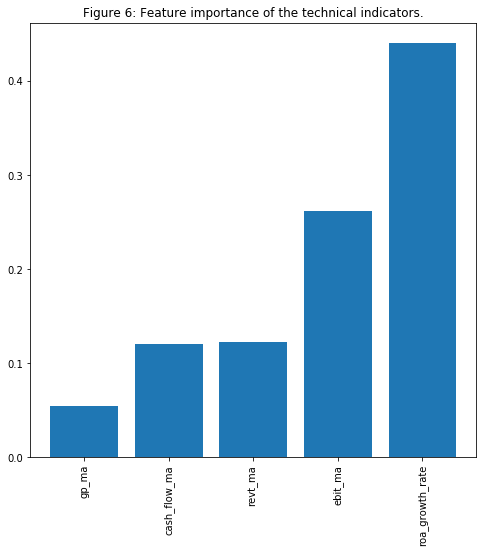

 70%|███████   | 355/507 [08:03<03:40,  1.45s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


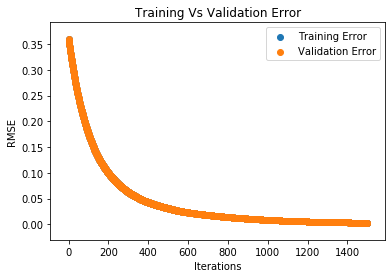

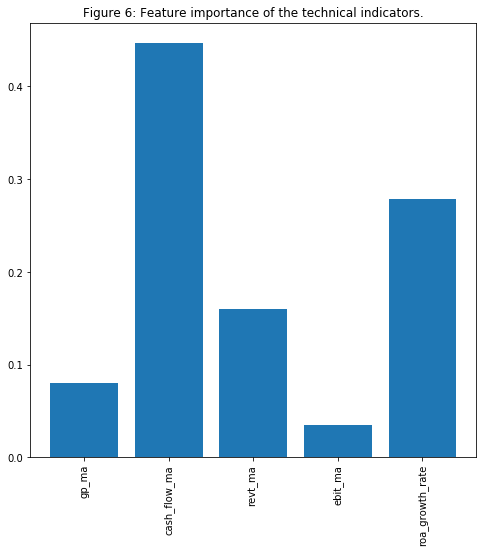

 70%|███████   | 356/507 [08:05<04:15,  1.69s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


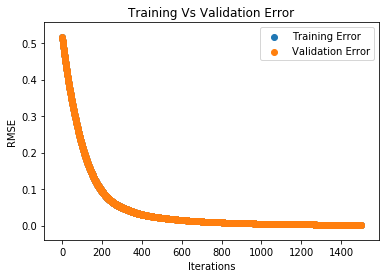

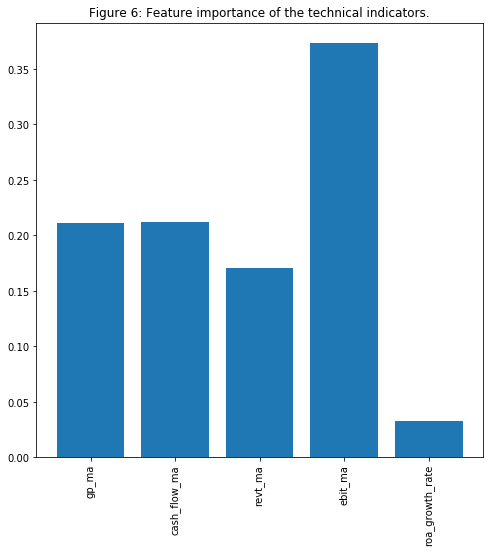

 70%|███████   | 357/507 [08:07<04:48,  1.92s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


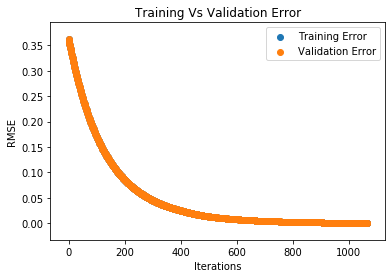

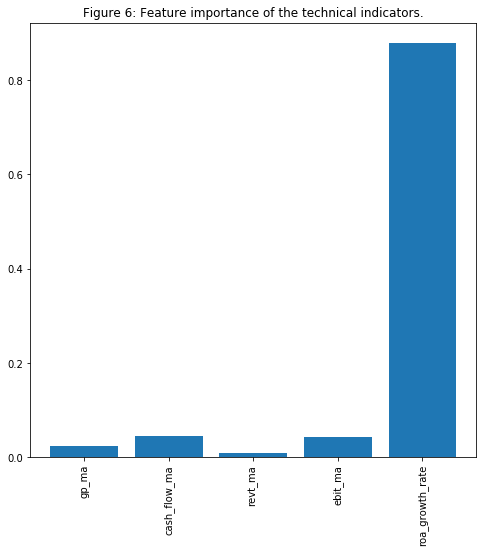

 71%|███████   | 358/507 [08:09<04:51,  1.95s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


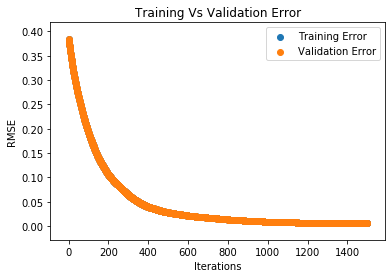

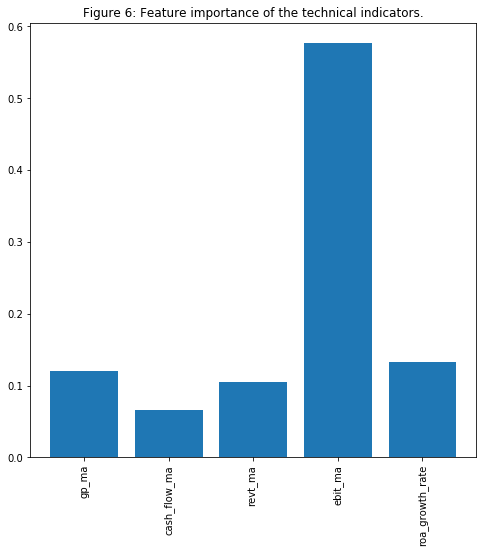

 71%|███████   | 359/507 [08:12<05:04,  2.05s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


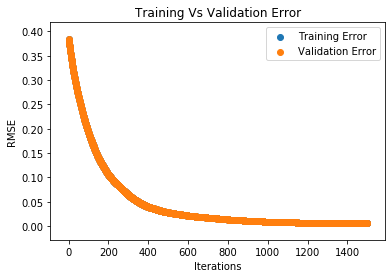

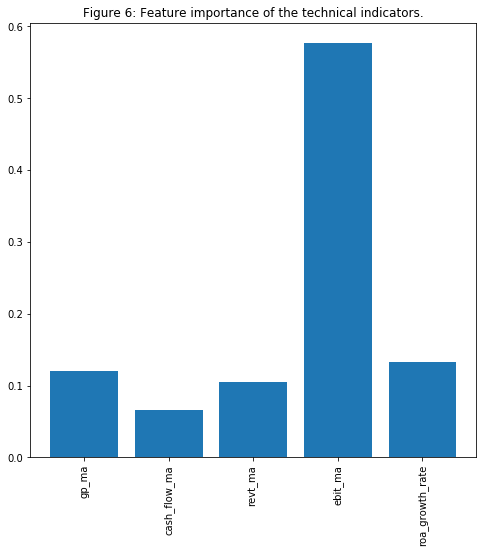

 71%|███████   | 360/507 [08:13<04:30,  1.84s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


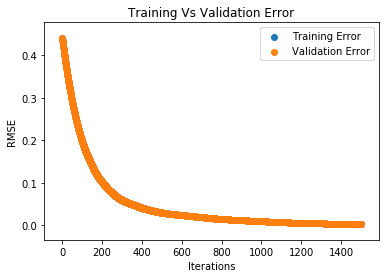

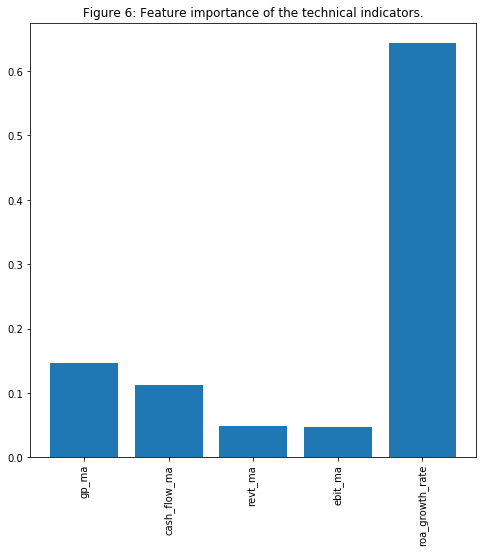

 71%|███████   | 361/507 [08:15<04:52,  2.00s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


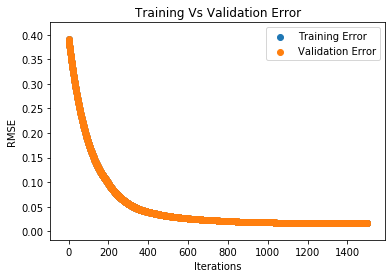

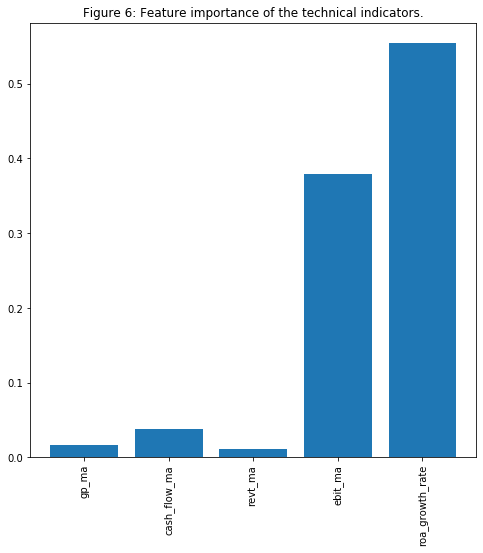

 72%|███████▏  | 365/507 [08:18<03:40,  1.55s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
1
[15:43:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


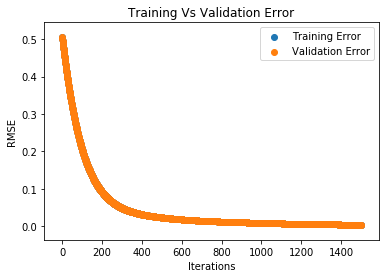

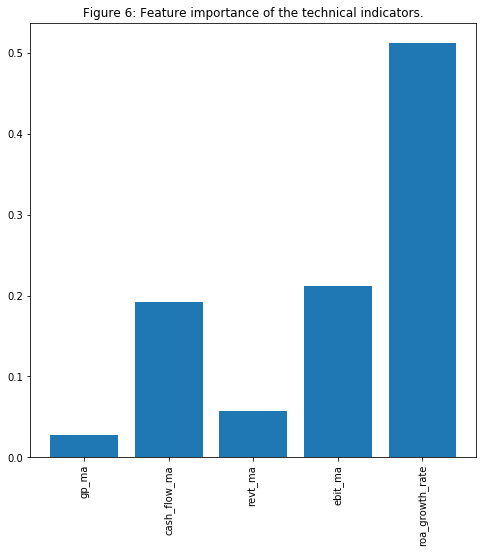

 72%|███████▏  | 366/507 [08:21<04:14,  1.81s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1


 73%|███████▎  | 368/507 [08:21<03:12,  1.39s/it]

1
[15:43:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


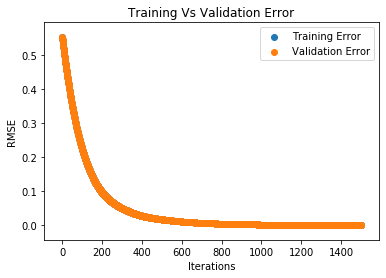

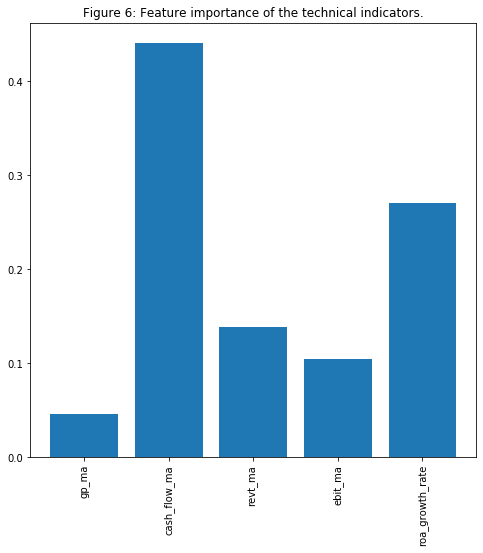

 73%|███████▎  | 369/507 [08:23<03:38,  1.58s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


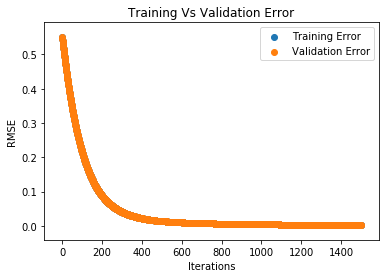

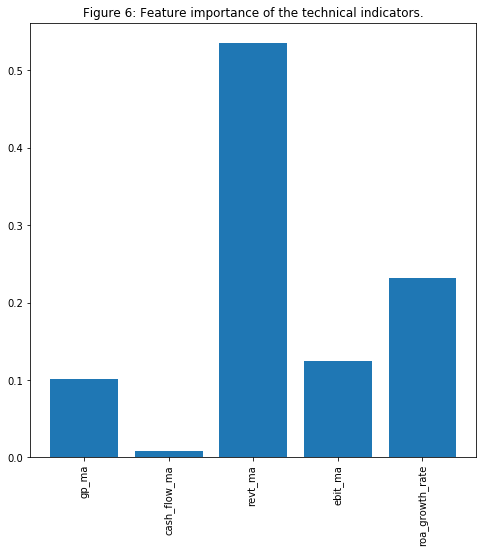

 73%|███████▎  | 370/507 [08:27<05:12,  2.28s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


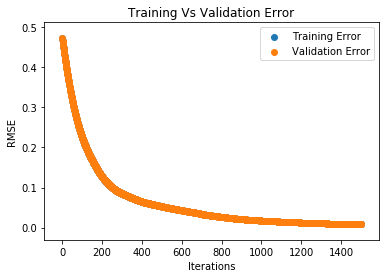

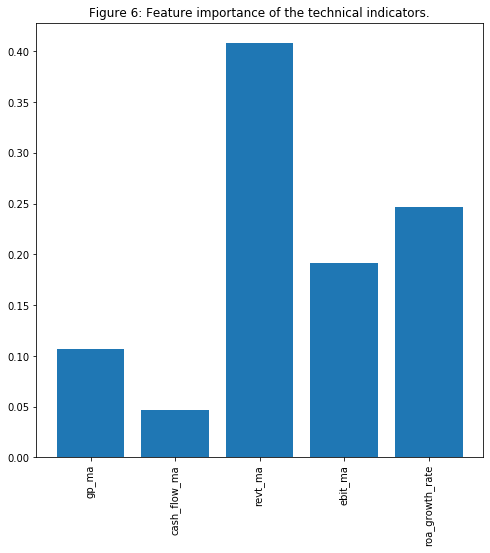

 73%|███████▎  | 371/507 [08:30<05:16,  2.33s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


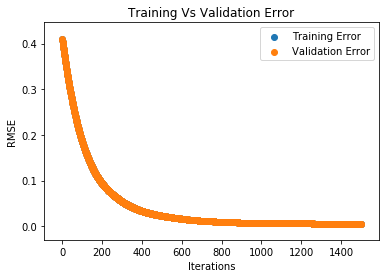

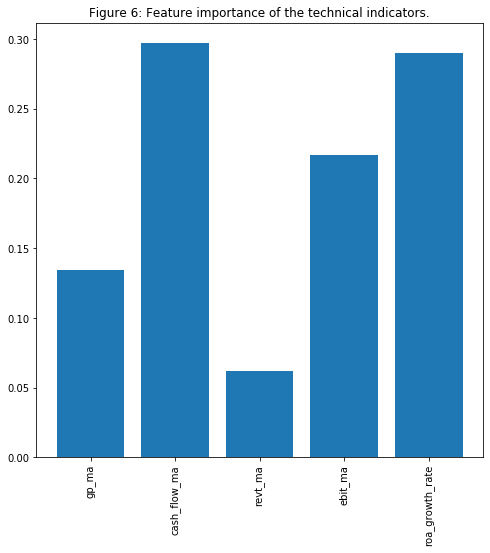

 73%|███████▎  | 372/507 [08:32<05:10,  2.30s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


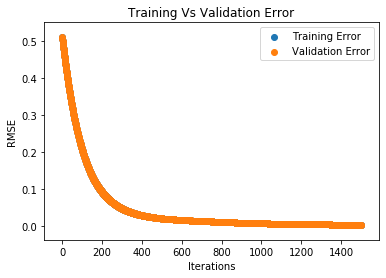

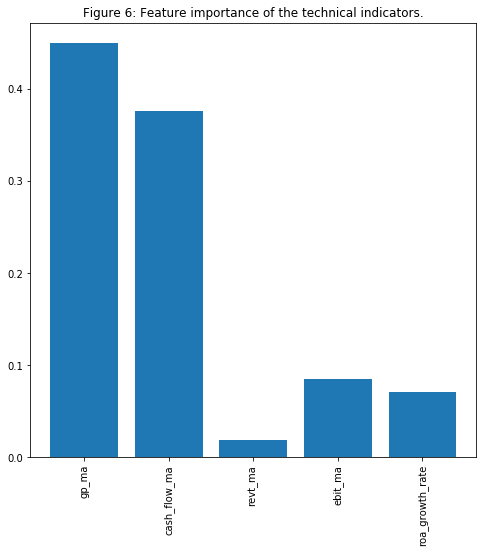

 74%|███████▎  | 373/507 [08:34<04:36,  2.06s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:43:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


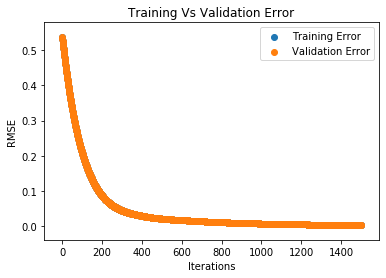

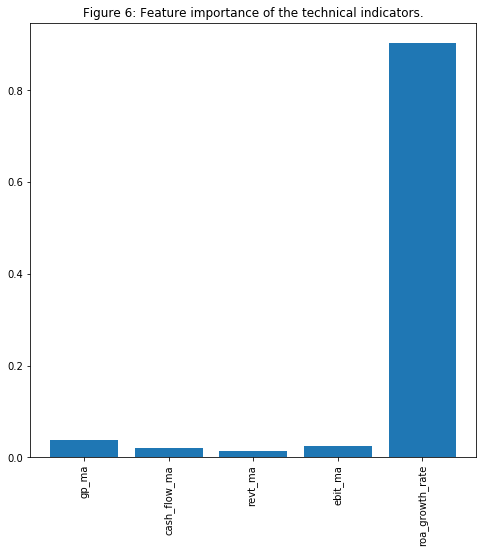

 74%|███████▍  | 375/507 [08:36<04:03,  1.85s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:43:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


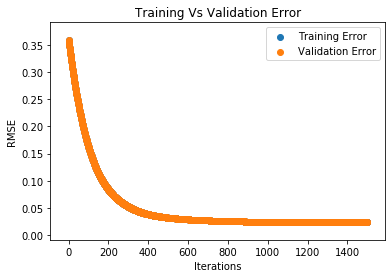

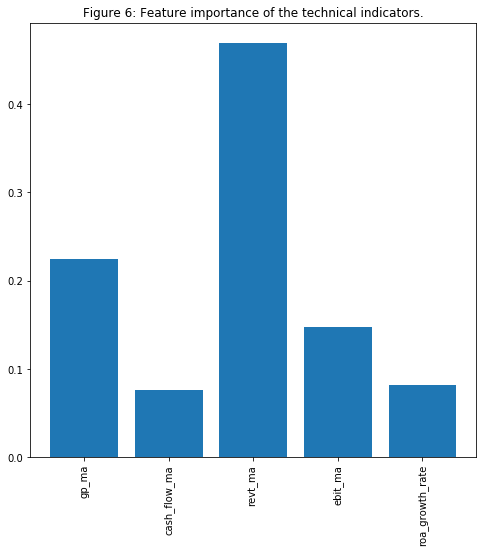

 75%|███████▍  | 378/507 [08:38<03:15,  1.51s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


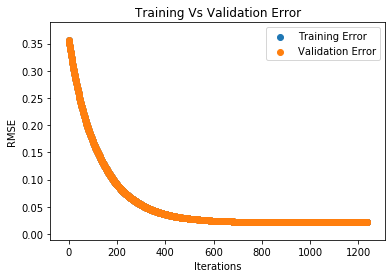

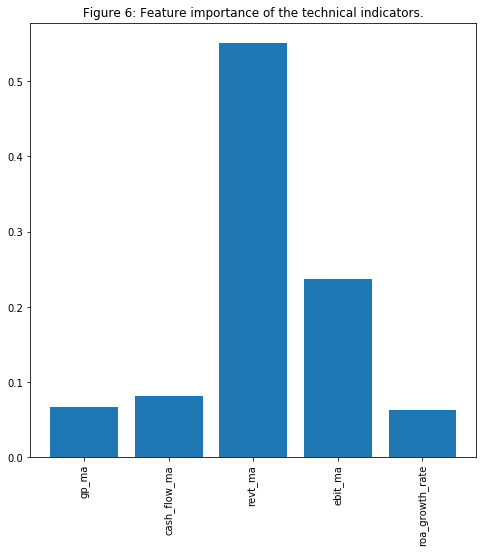

 75%|███████▍  | 379/507 [08:41<03:34,  1.68s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:43:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


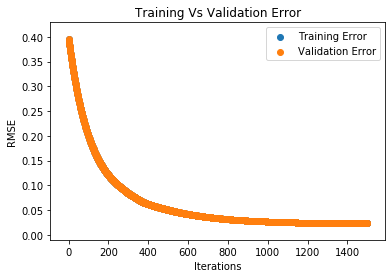

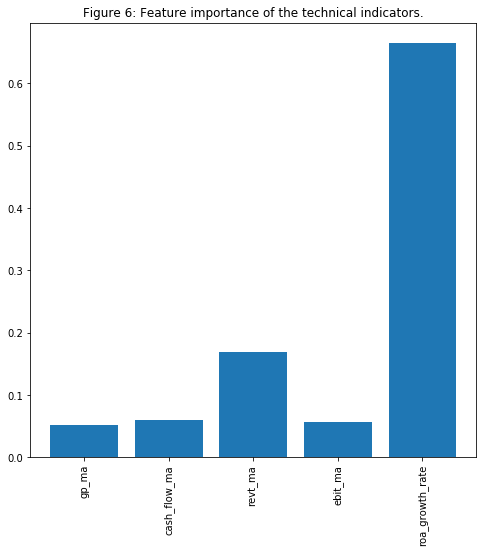

 75%|███████▌  | 381/507 [08:43<03:10,  1.51s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:43:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


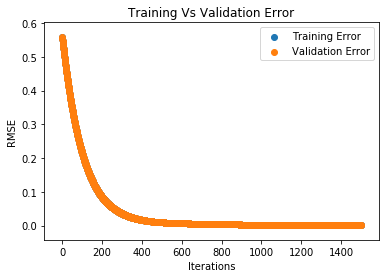

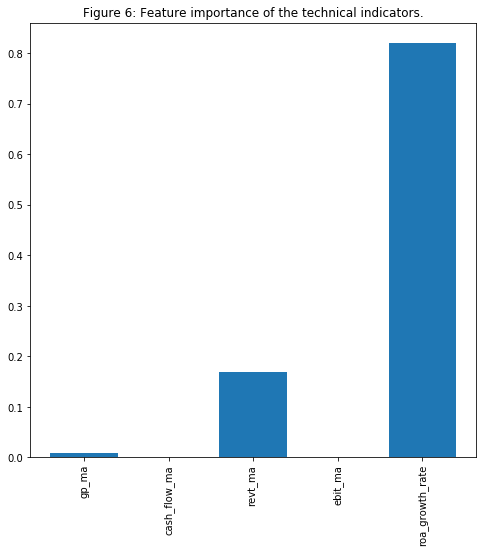

 76%|███████▌  | 383/507 [08:45<02:48,  1.36s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


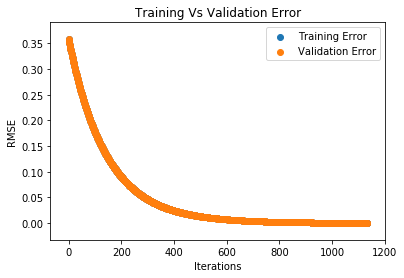

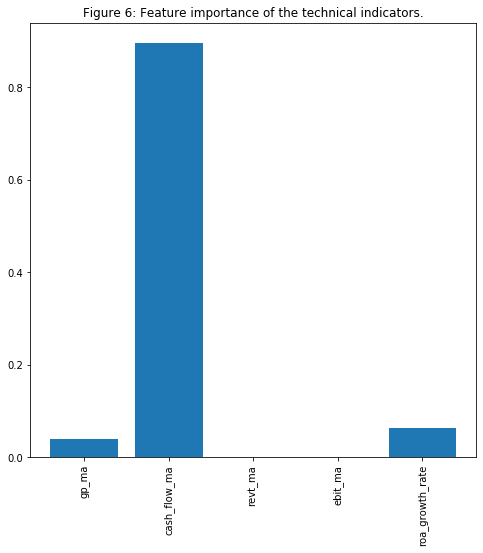

 76%|███████▌  | 384/507 [08:47<03:07,  1.52s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


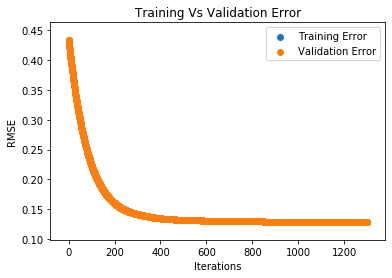

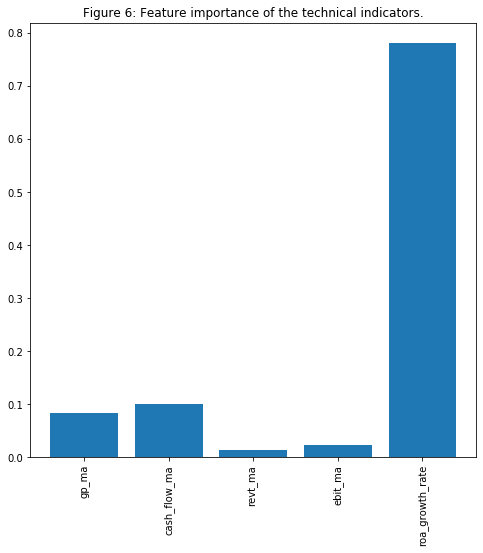

 77%|███████▋  | 388/507 [08:49<02:20,  1.18s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
1
[15:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


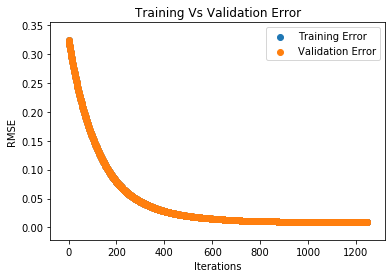

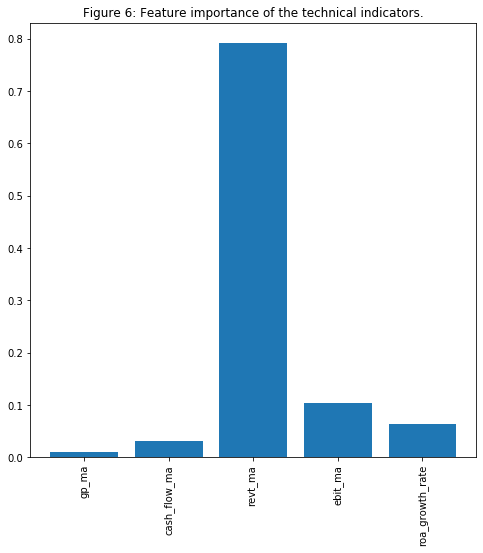

 77%|███████▋  | 389/507 [08:51<02:56,  1.49s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


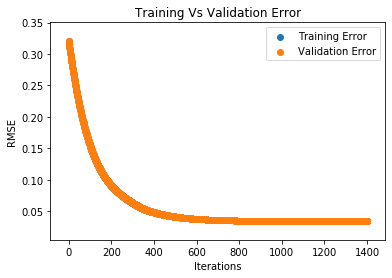

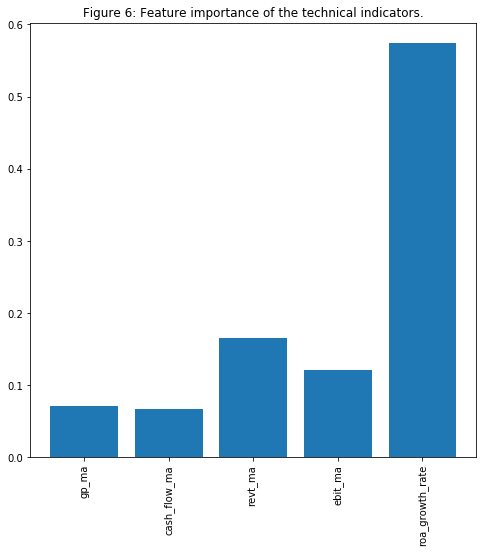

 77%|███████▋  | 390/507 [08:53<03:20,  1.71s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:43:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


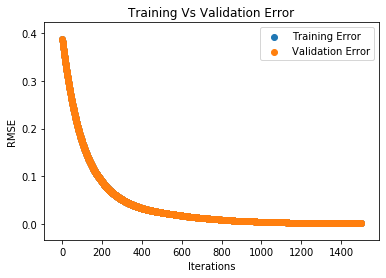

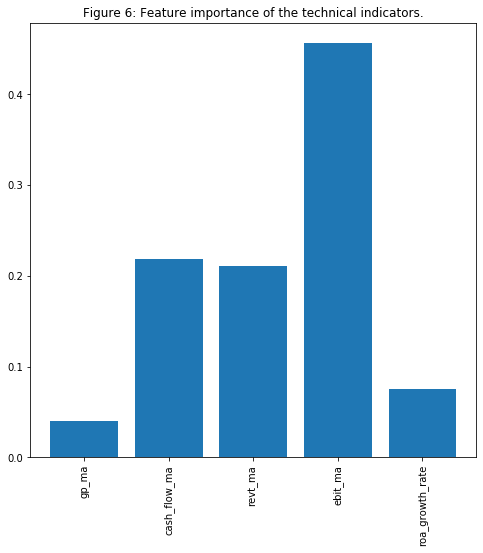

 77%|███████▋  | 391/507 [08:56<03:49,  1.97s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:44:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


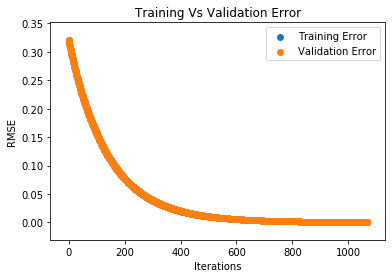

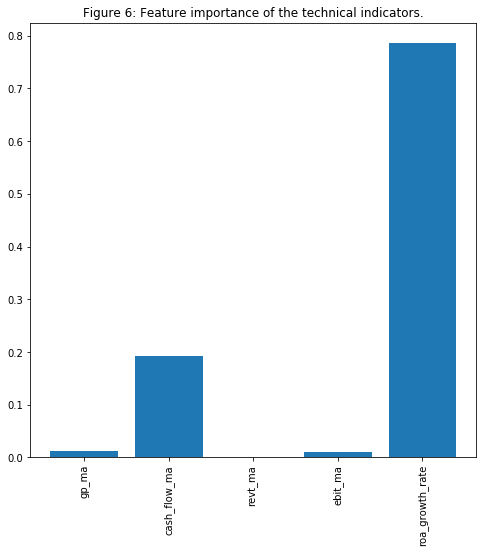

 78%|███████▊  | 393/507 [08:58<03:14,  1.71s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


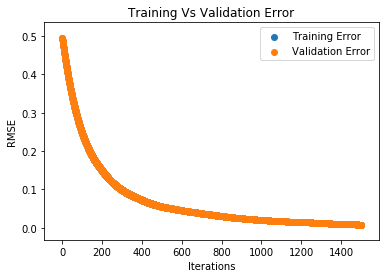

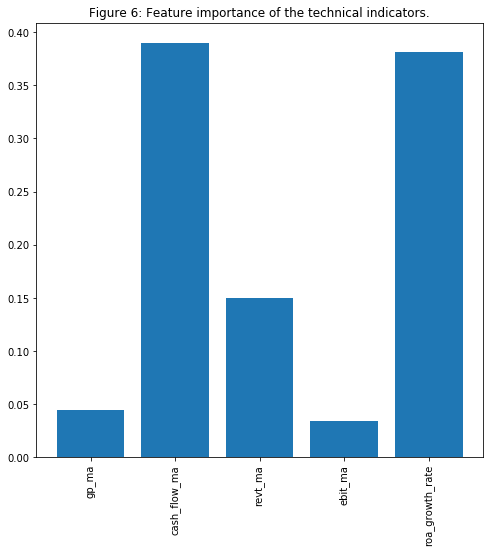

 78%|███████▊  | 394/507 [09:00<03:34,  1.89s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:44:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


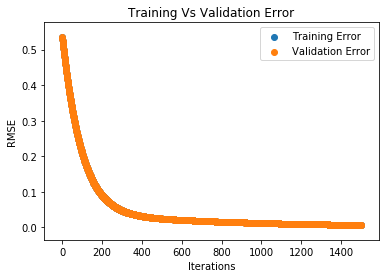

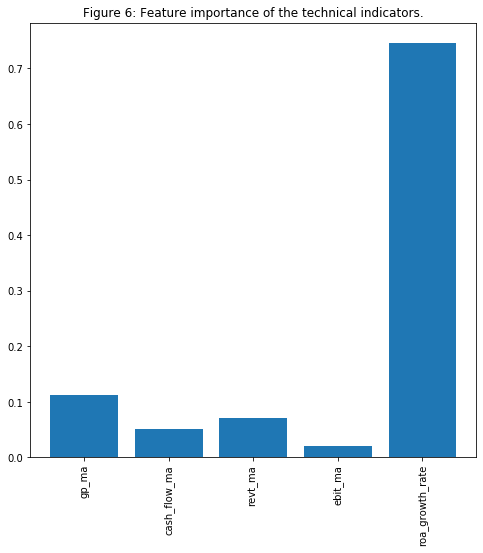

 78%|███████▊  | 396/507 [09:03<03:07,  1.69s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


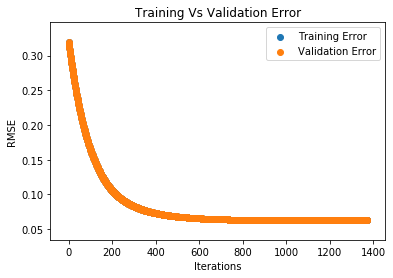

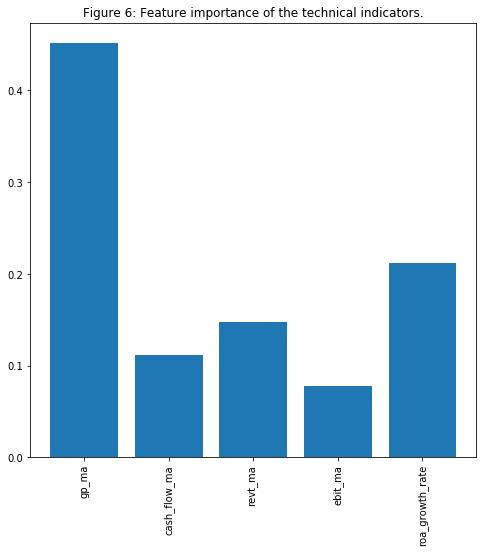

 78%|███████▊  | 397/507 [09:05<03:23,  1.85s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


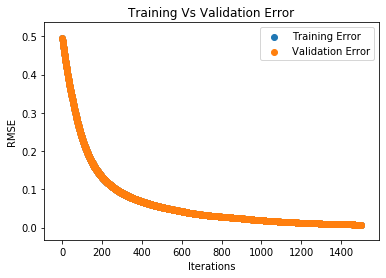

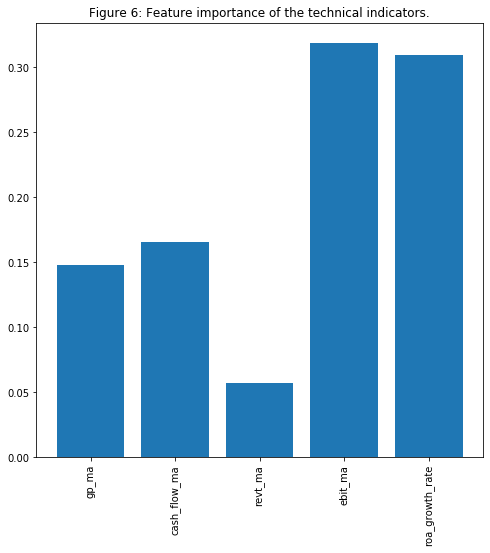

 79%|███████▊  | 398/507 [09:07<03:34,  1.97s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


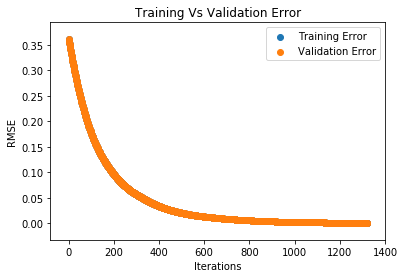

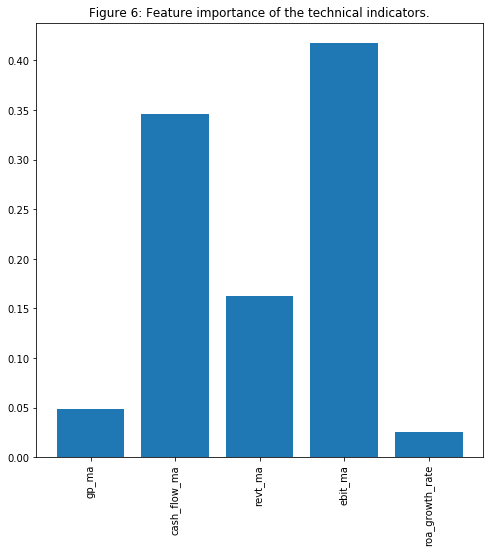

 79%|███████▉  | 402/507 [09:10<02:30,  1.43s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
1
[15:44:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


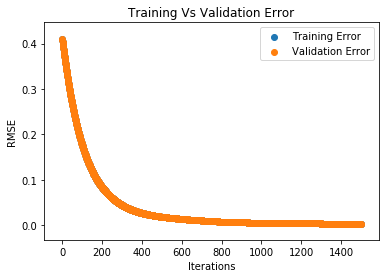

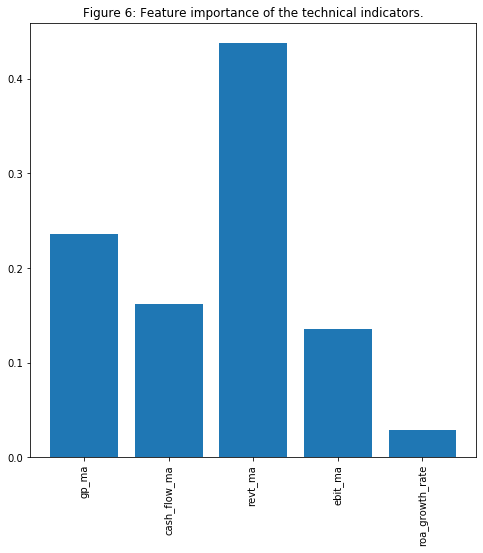

 79%|███████▉  | 403/507 [09:12<02:53,  1.67s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:44:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


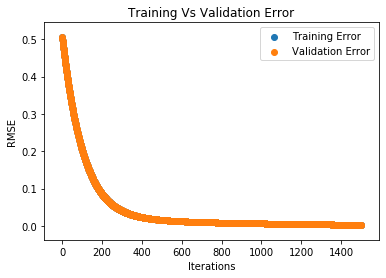

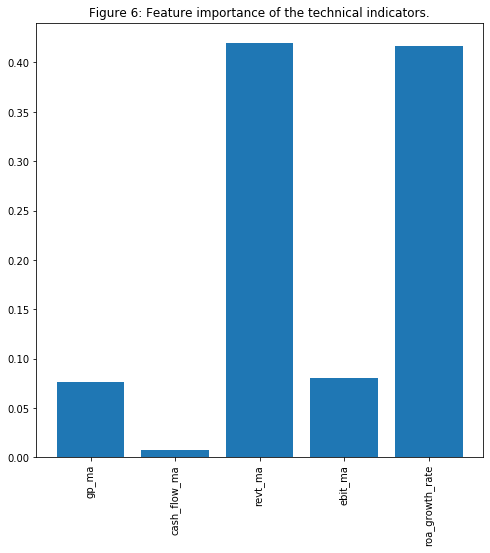

 80%|███████▉  | 405/507 [09:14<02:38,  1.55s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


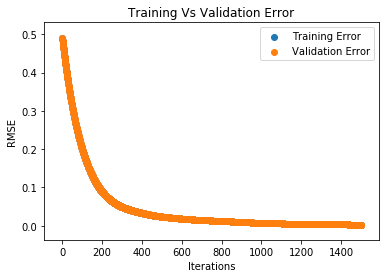

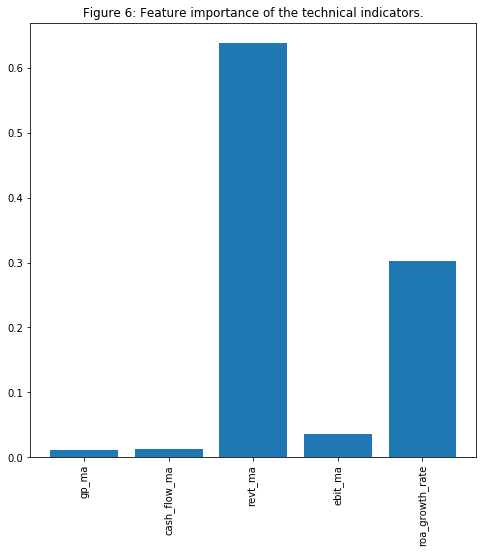

 80%|████████  | 406/507 [09:17<03:02,  1.81s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


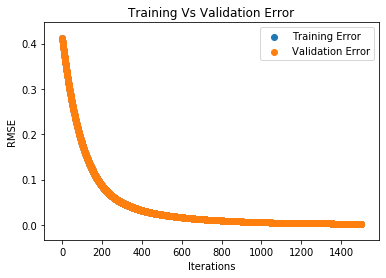

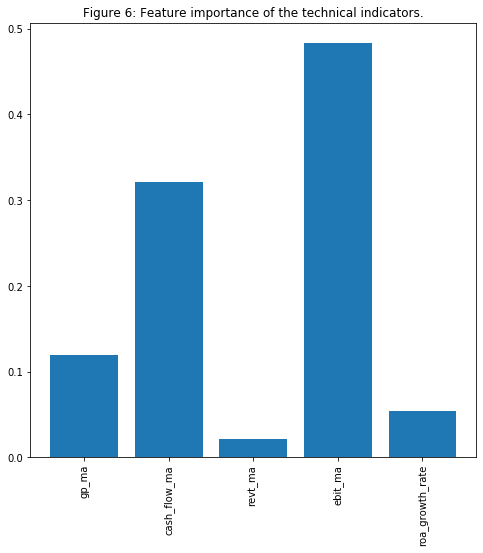

 80%|████████  | 407/507 [09:19<03:17,  1.97s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


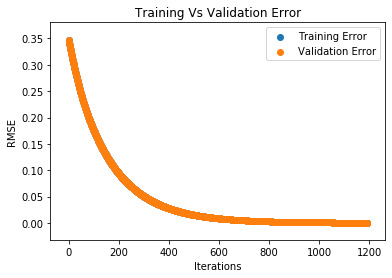

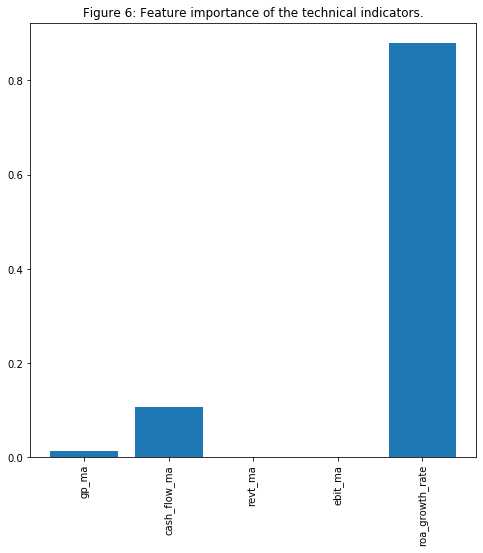

 80%|████████  | 408/507 [09:21<03:12,  1.95s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


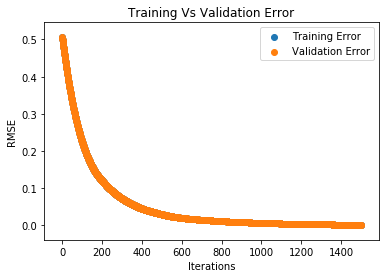

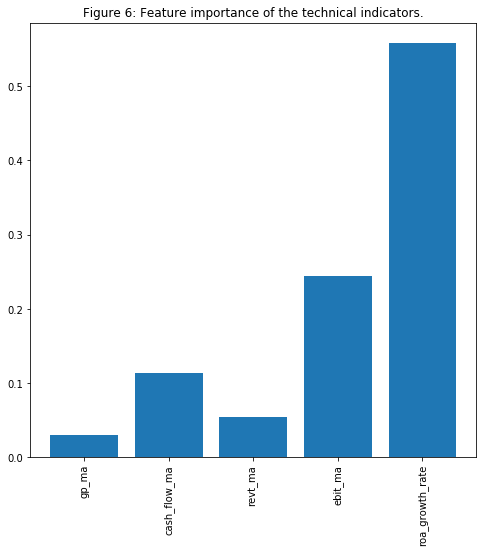

 81%|████████  | 409/507 [09:23<03:18,  2.03s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


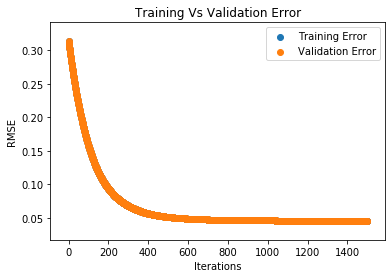

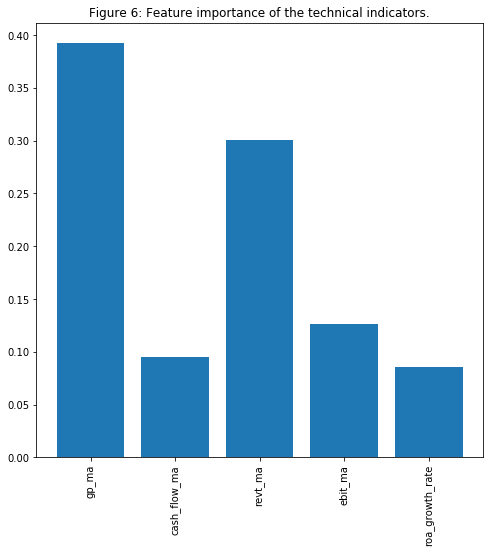

 81%|████████  | 410/507 [09:26<03:29,  2.16s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


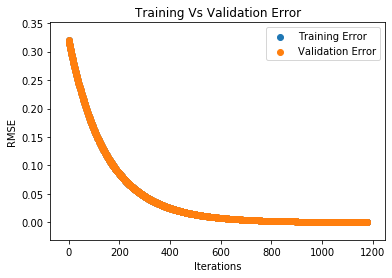

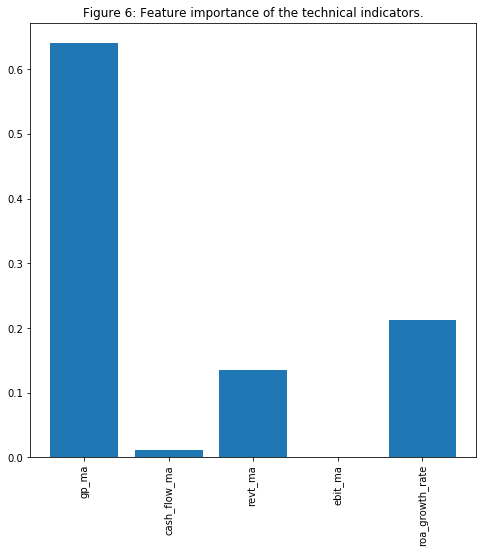

 81%|████████  | 411/507 [09:28<03:21,  2.10s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


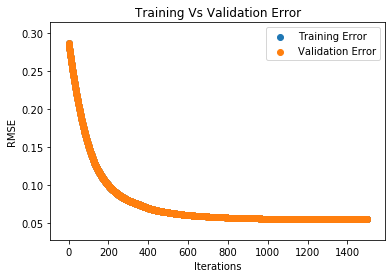

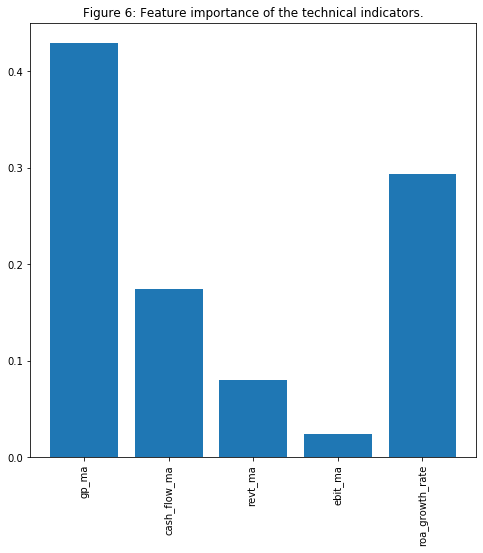

 81%|████████▏ | 412/507 [09:30<03:25,  2.16s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


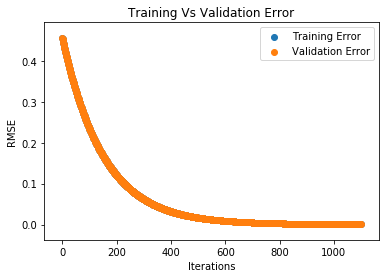

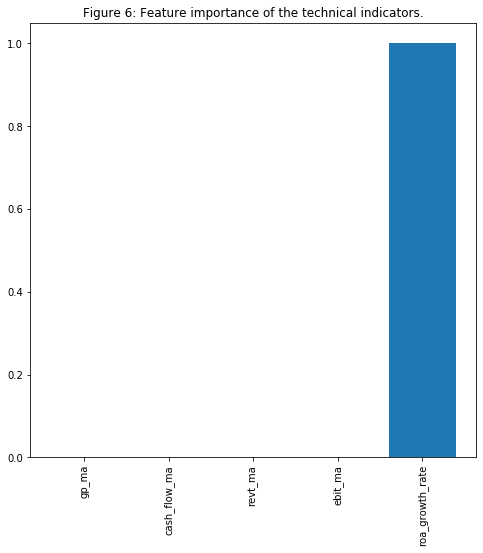

 82%|████████▏ | 414/507 [09:32<02:44,  1.77s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


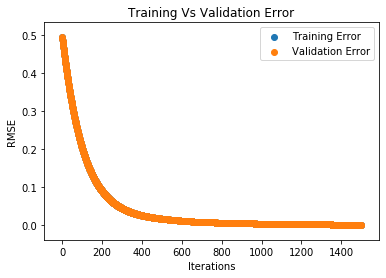

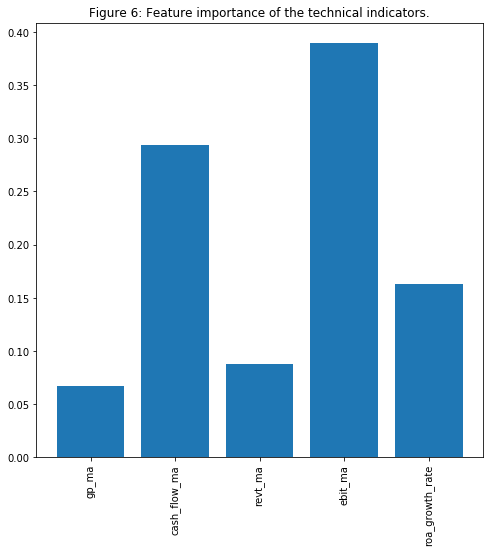

 82%|████████▏ | 415/507 [09:33<02:30,  1.63s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


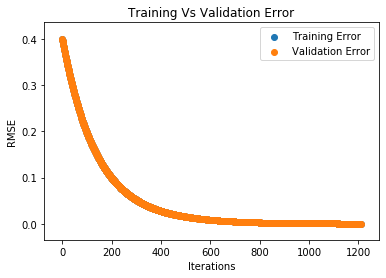

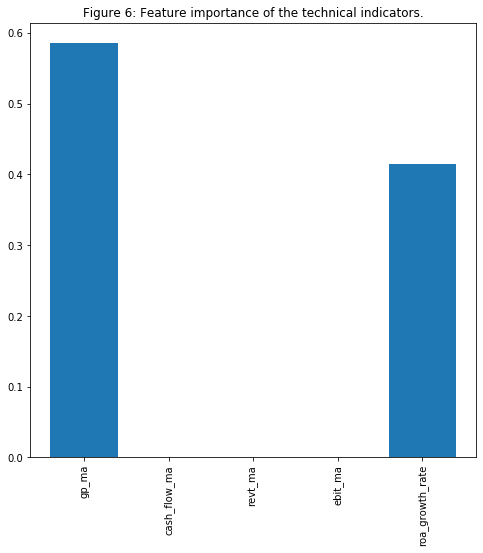

 82%|████████▏ | 416/507 [09:35<02:29,  1.64s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1


 82%|████████▏ | 418/507 [09:35<01:53,  1.27s/it]

1
[15:44:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


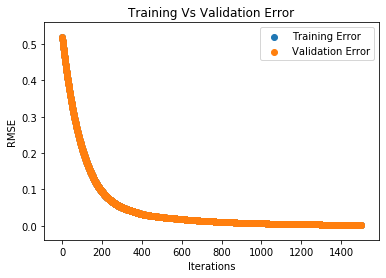

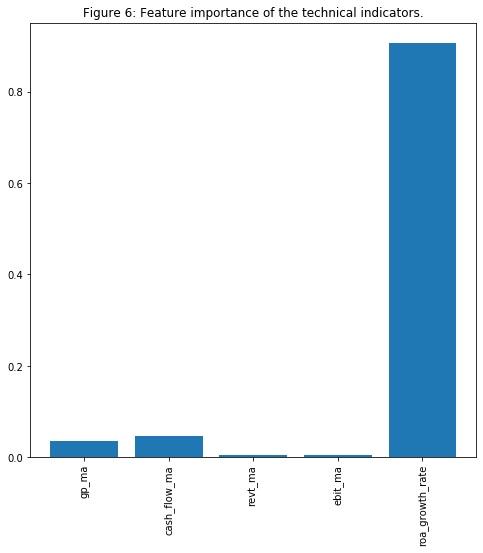

 83%|████████▎ | 419/507 [09:38<02:25,  1.66s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


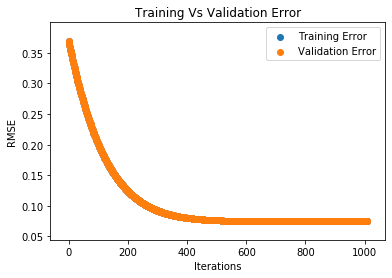

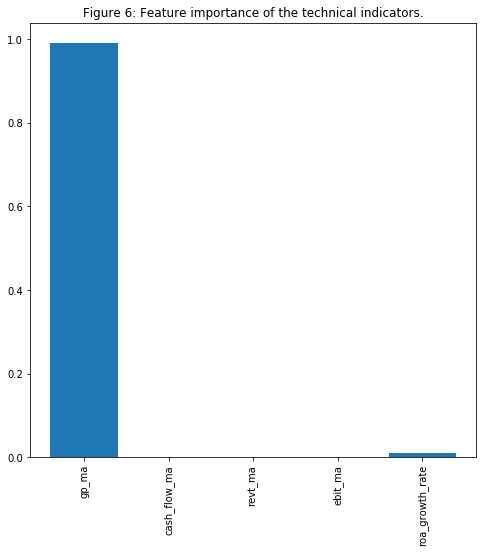

 83%|████████▎ | 420/507 [09:40<02:26,  1.68s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:44:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


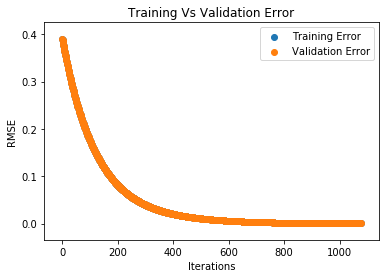

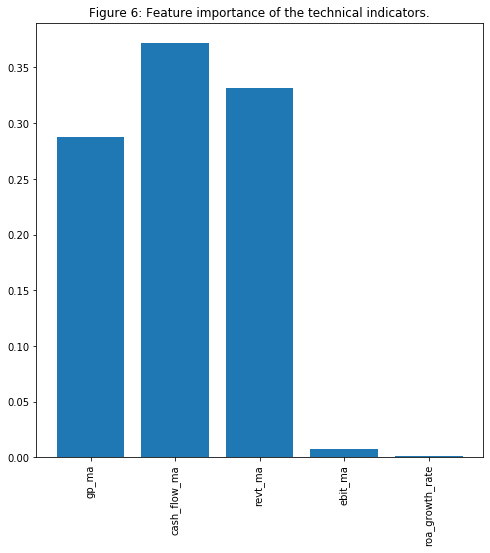

 83%|████████▎ | 423/507 [09:42<01:56,  1.38s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


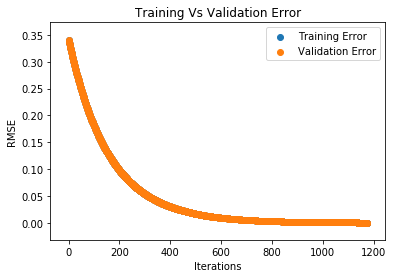

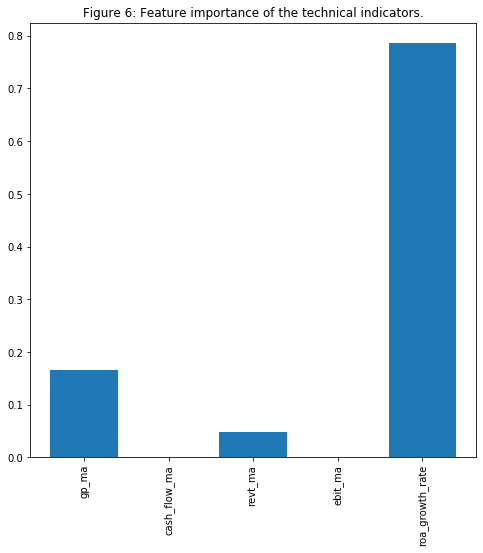

 84%|████████▎ | 424/507 [09:44<02:07,  1.53s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:44:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


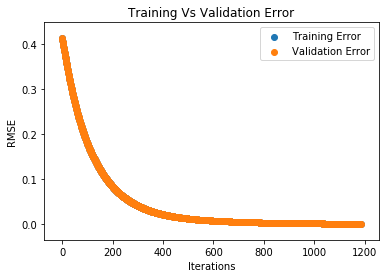

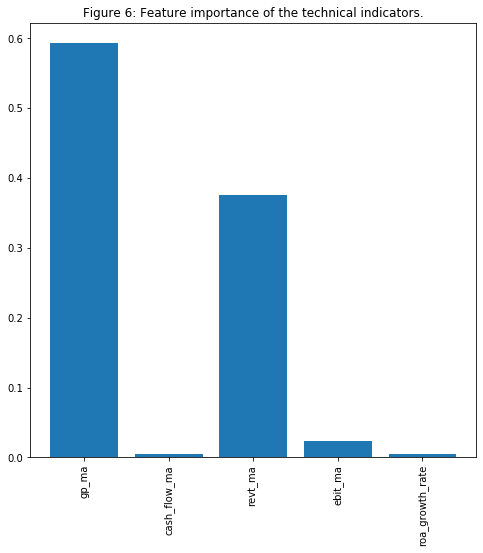

 84%|████████▍ | 426/507 [09:46<01:52,  1.39s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:44:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


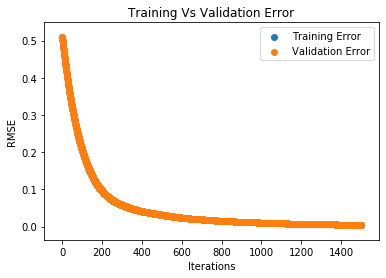

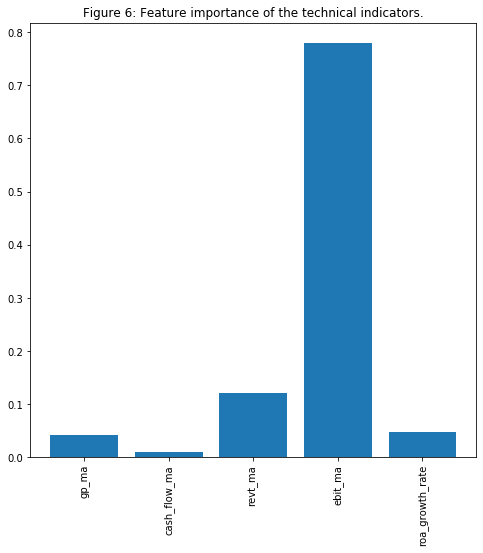

 85%|████████▍ | 429/507 [09:49<01:40,  1.29s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


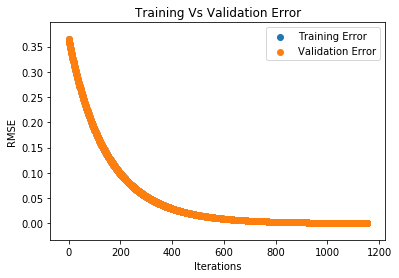

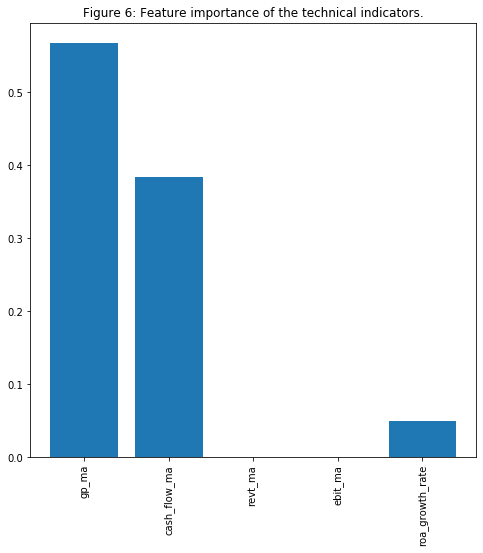

 85%|████████▍ | 430/507 [09:51<01:50,  1.43s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:44:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


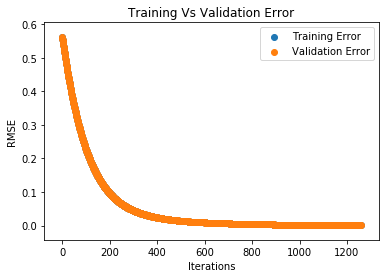

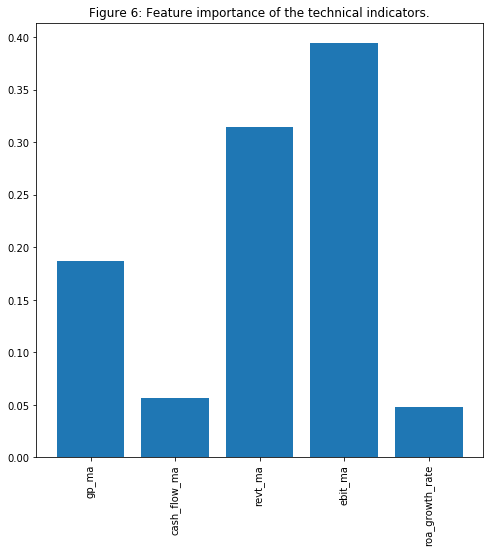

 85%|████████▌ | 432/507 [09:53<01:40,  1.34s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:44:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


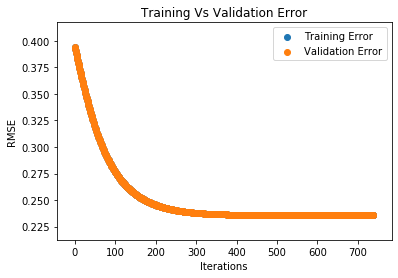

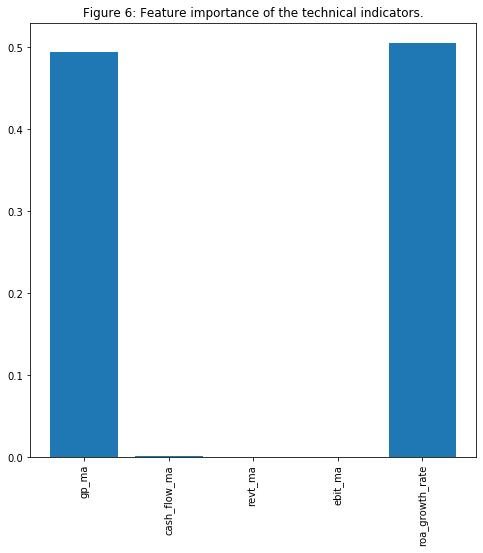

 86%|████████▌ | 434/507 [09:55<01:29,  1.23s/it]

1
1
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


[15:45:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


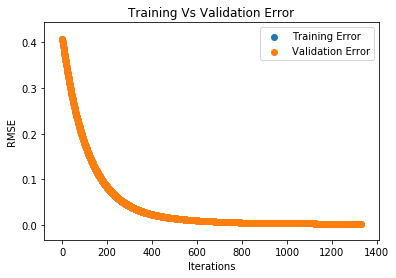

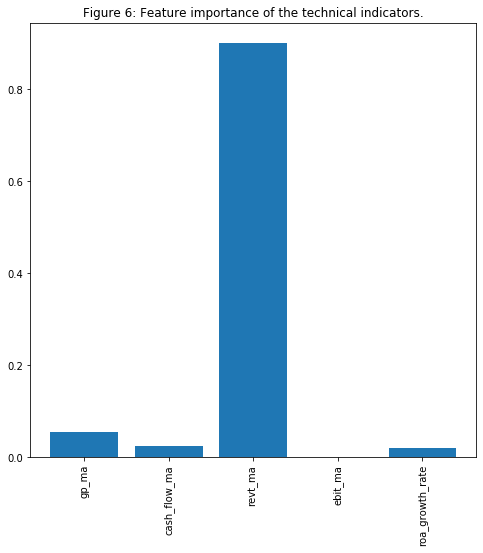

 86%|████████▌ | 437/507 [09:58<01:16,  1.09s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:45:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


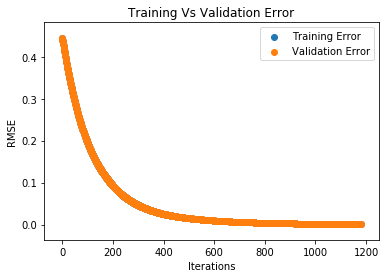

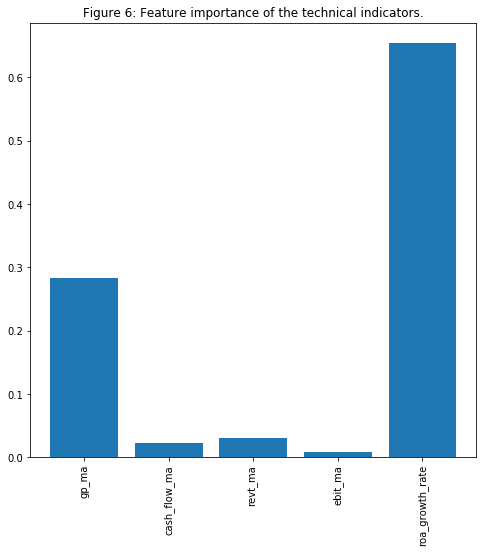

 87%|████████▋ | 439/507 [10:00<01:13,  1.08s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:45:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


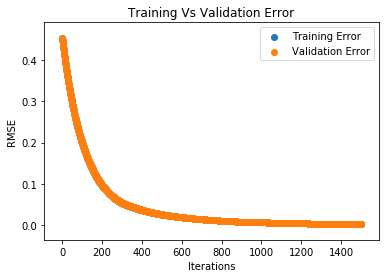

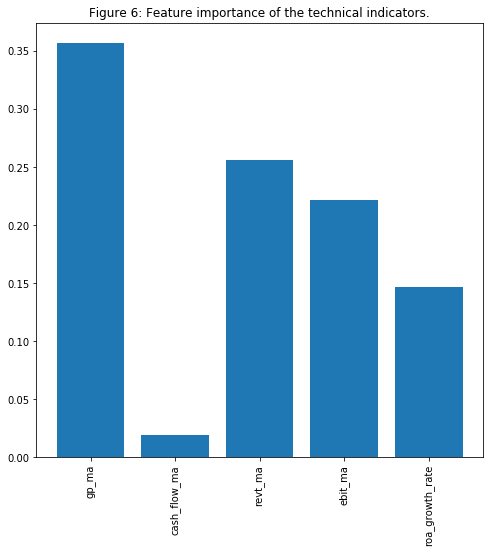

 87%|████████▋ | 442/507 [10:02<01:03,  1.03it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:45:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


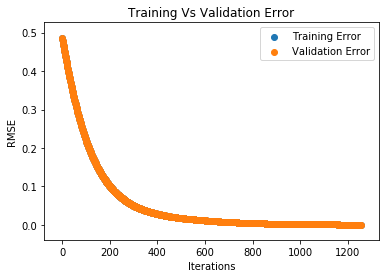

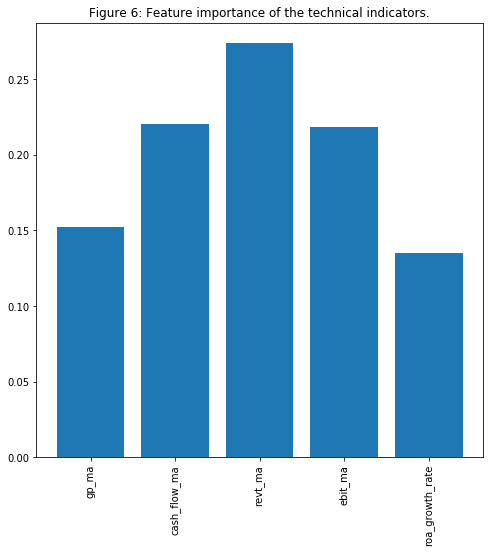

 88%|████████▊ | 444/507 [10:04<01:00,  1.04it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:45:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


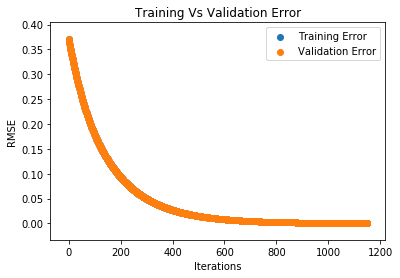

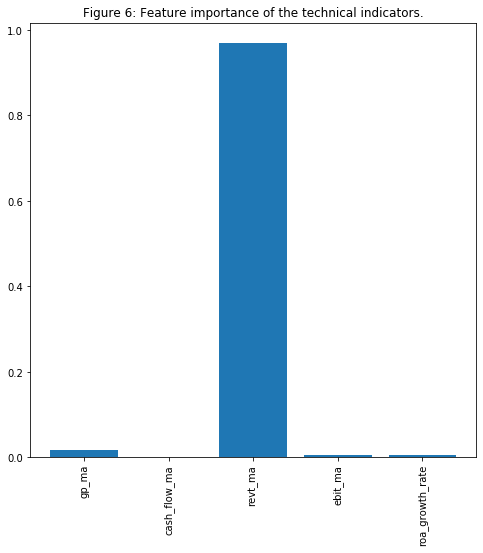

 88%|████████▊ | 446/507 [10:06<00:59,  1.02it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:45:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


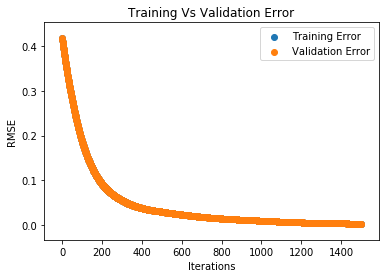

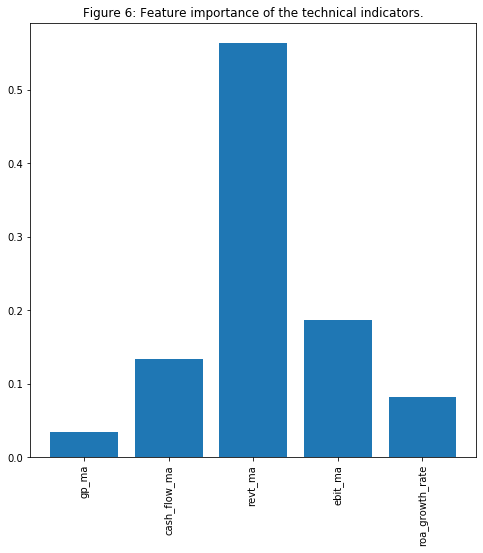

 88%|████████▊ | 447/507 [10:08<01:20,  1.33s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:45:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


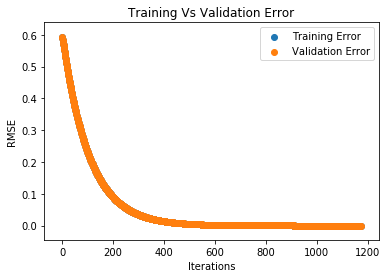

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


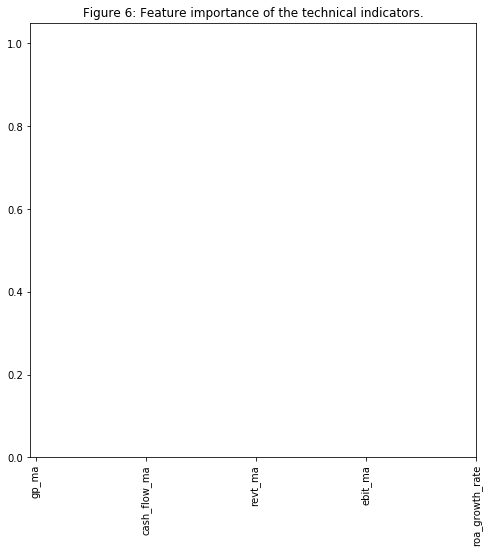

 89%|████████▊ | 449/507 [10:10<01:11,  1.24s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:45:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


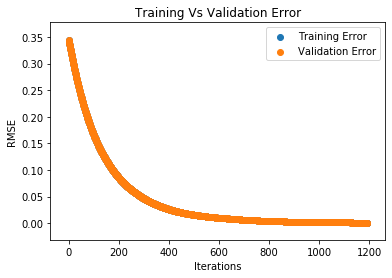

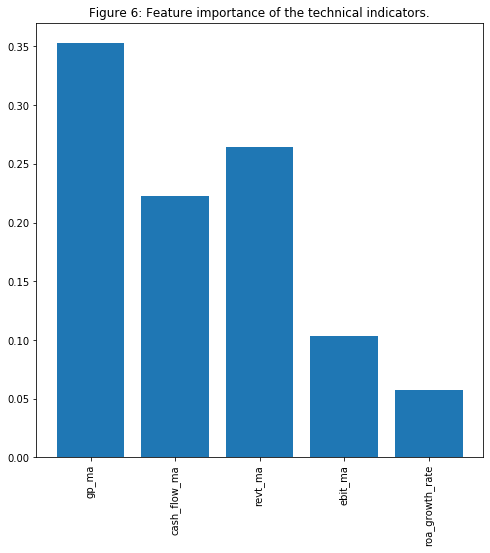

 89%|████████▉ | 450/507 [10:14<01:51,  1.96s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


[15:45:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


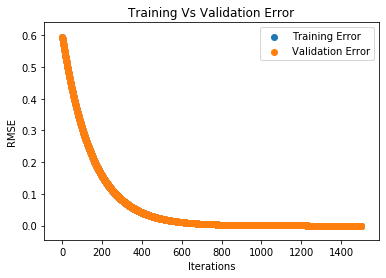

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


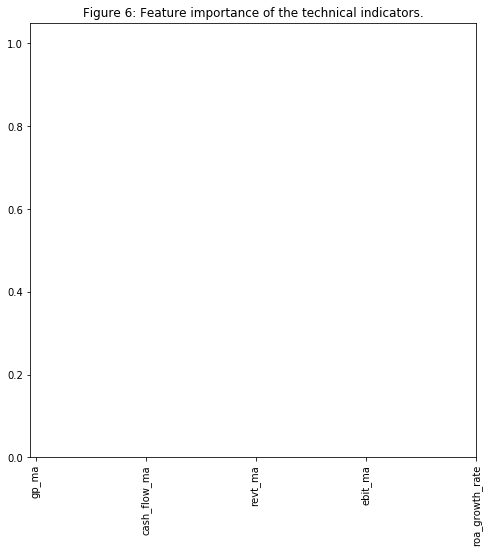

 89%|████████▉ | 451/507 [10:15<01:46,  1.90s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:45:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


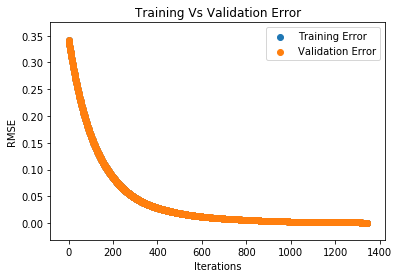

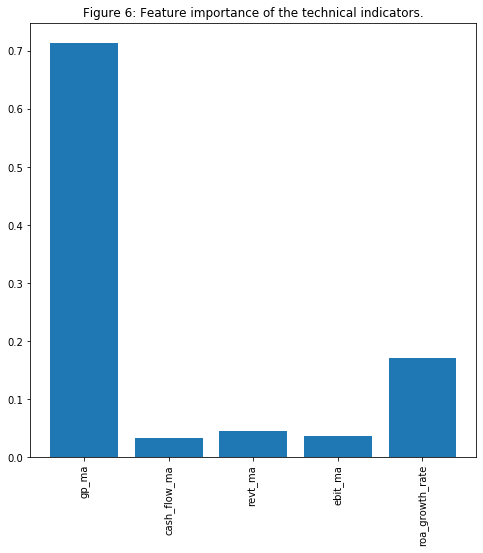

 89%|████████▉ | 452/507 [10:18<01:48,  1.98s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:45:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


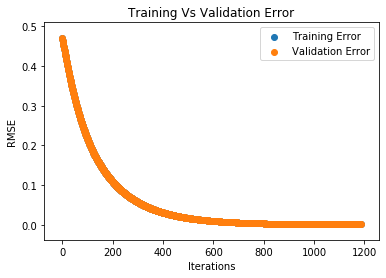

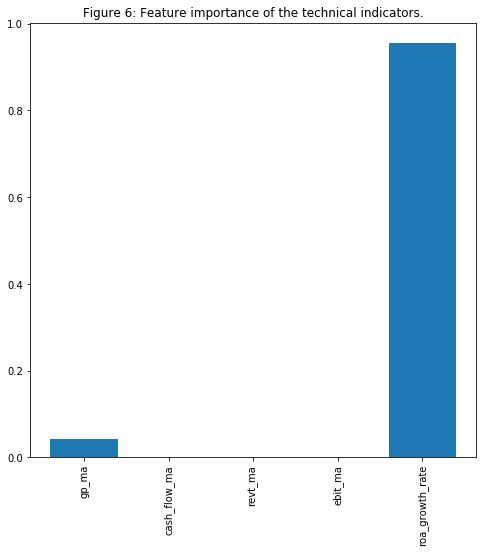

 89%|████████▉ | 453/507 [10:18<01:28,  1.65s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:45:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


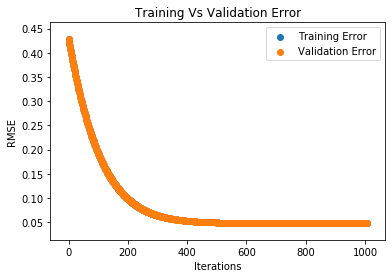

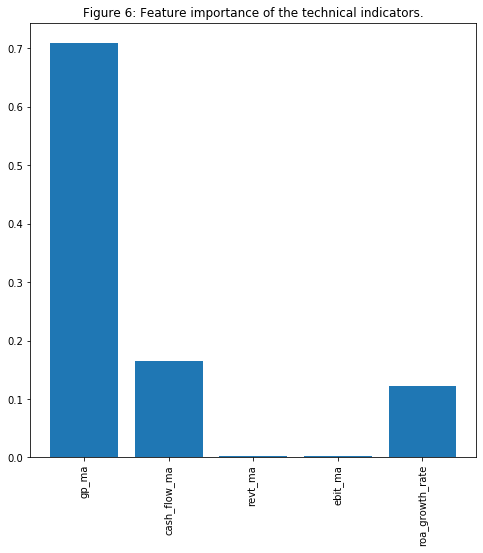

 90%|████████▉ | 455/507 [10:20<01:15,  1.45s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:45:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


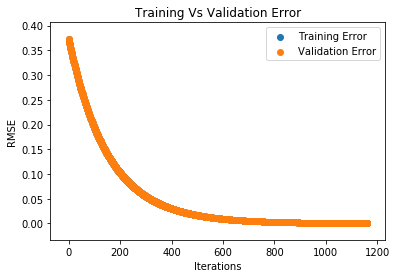

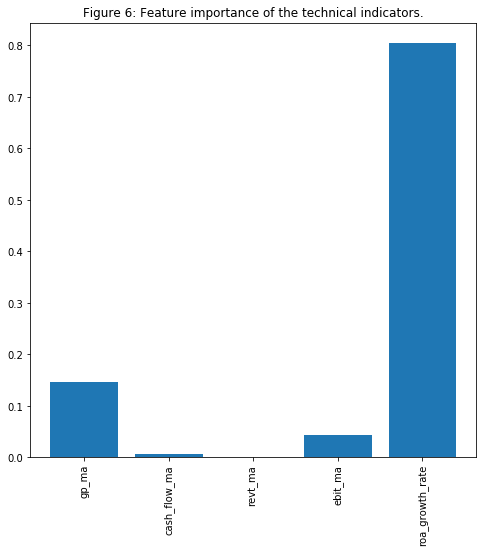

 90%|█████████ | 457/507 [10:23<01:06,  1.34s/it]

1
[15:45:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


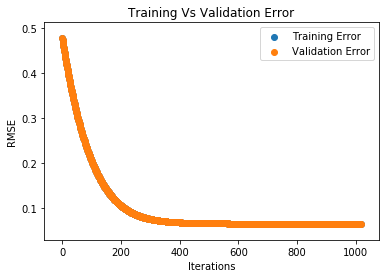

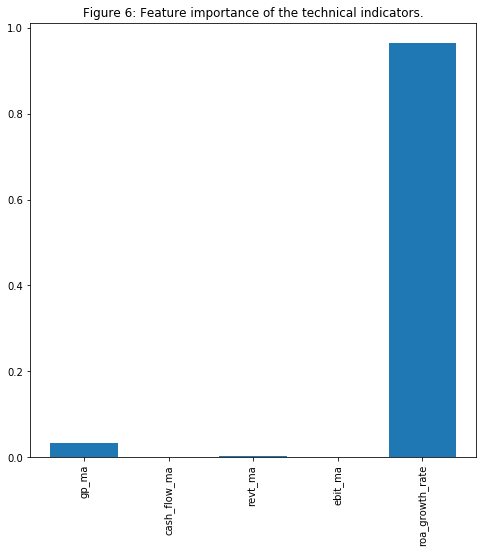

 90%|█████████ | 458/507 [10:25<01:15,  1.55s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:45:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


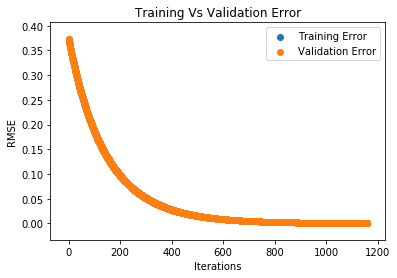

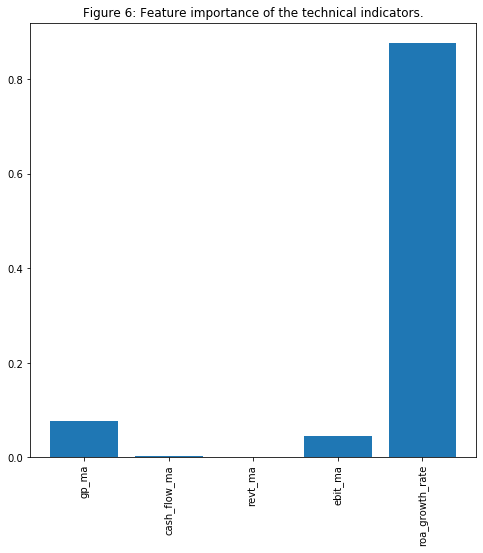

 91%|█████████ | 460/507 [10:27<01:03,  1.36s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:45:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


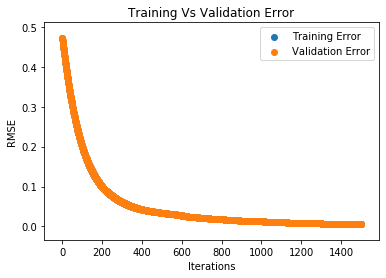

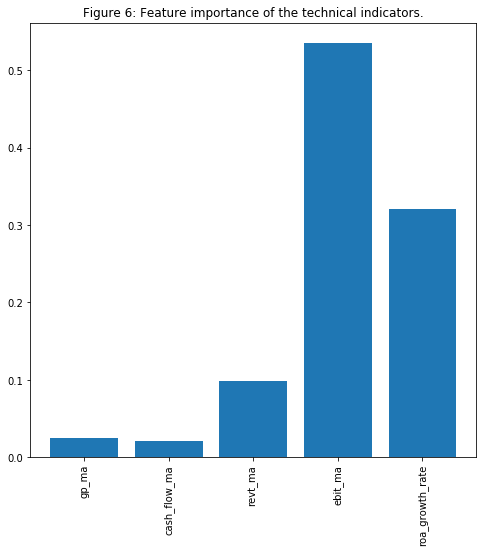

 91%|█████████ | 461/507 [10:29<01:18,  1.70s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:45:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


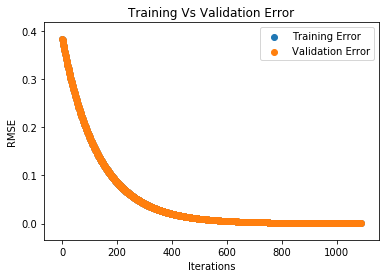

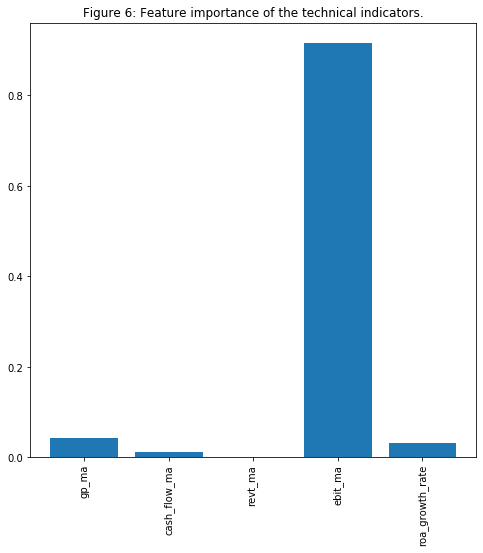

 91%|█████████ | 462/507 [10:31<01:17,  1.73s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:45:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


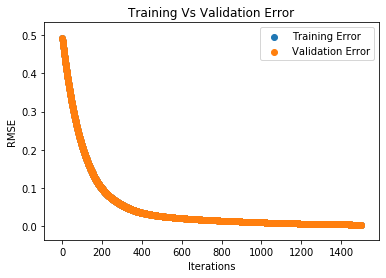

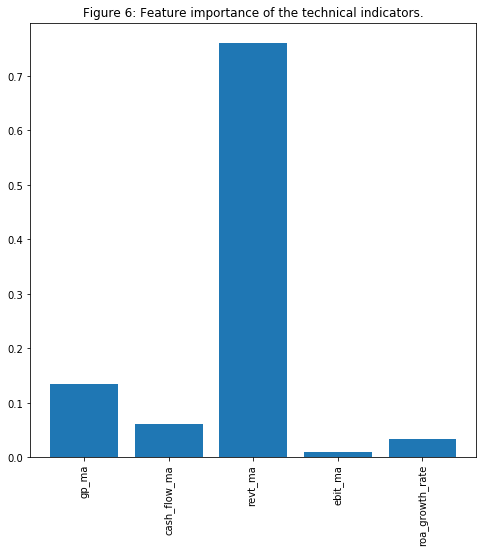

 91%|█████████▏| 463/507 [10:34<01:24,  1.92s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
 92%|█████████▏| 467/507 [10:35<00:45,  1.15s/it]

1
1
1
1
1
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


[15:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


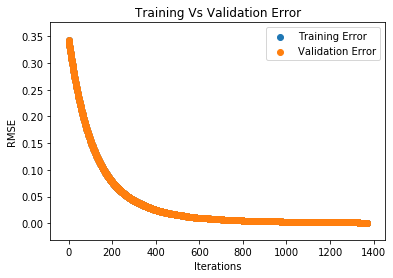

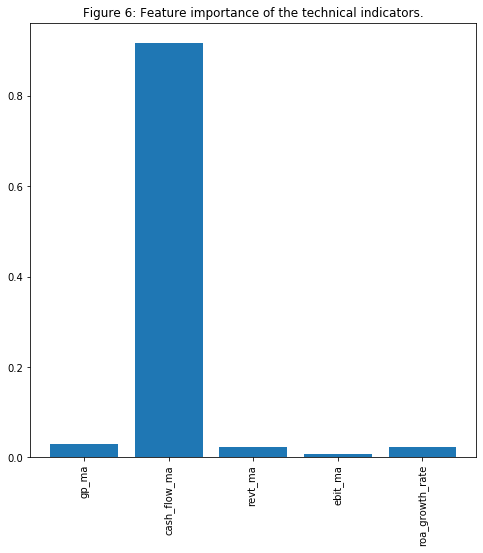

 93%|█████████▎| 470/507 [10:37<00:38,  1.03s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:45:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


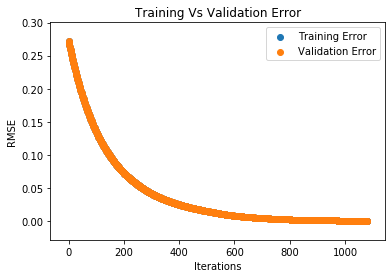

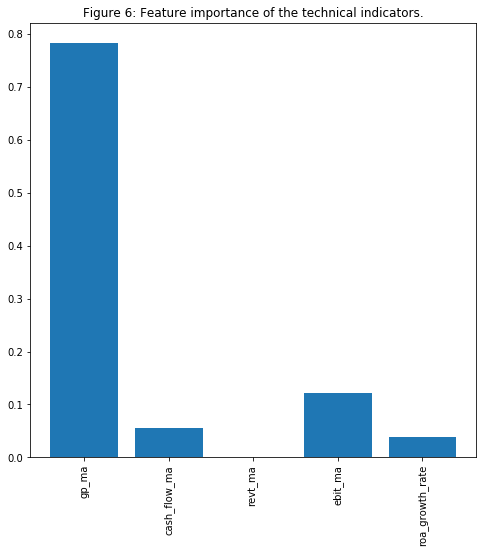

 93%|█████████▎| 471/507 [10:39<00:47,  1.31s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:45:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


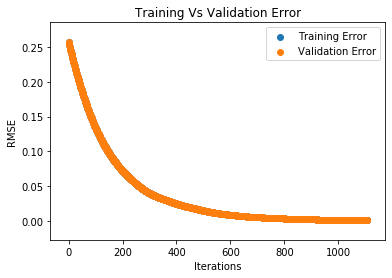

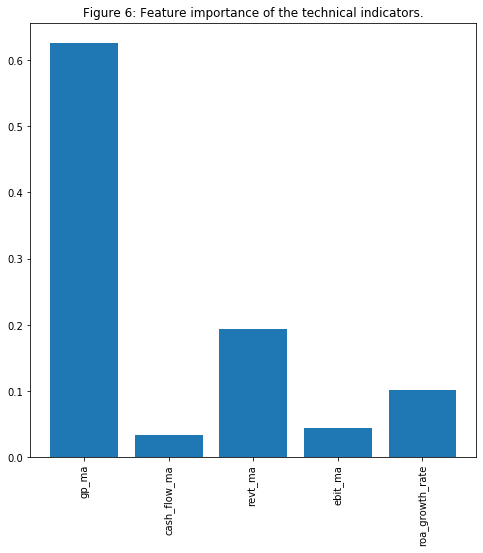

 93%|█████████▎| 472/507 [10:41<00:53,  1.52s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
[15:45:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


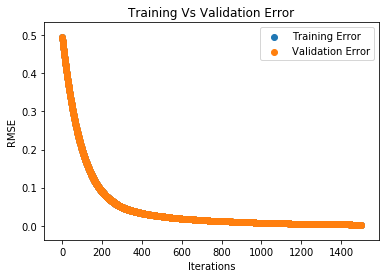

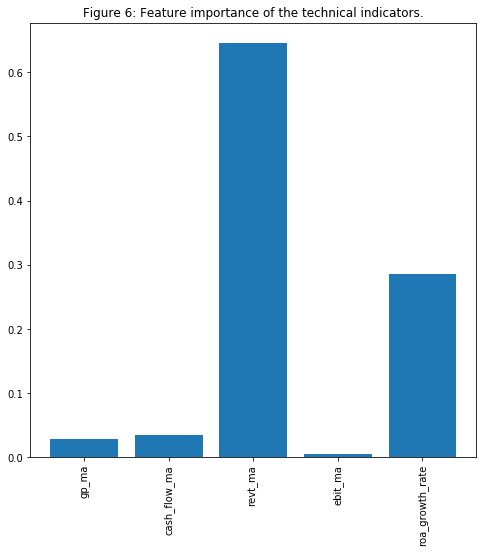

 94%|█████████▍| 478/507 [10:43<00:26,  1.09it/s]

1
1
1
1
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:45:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


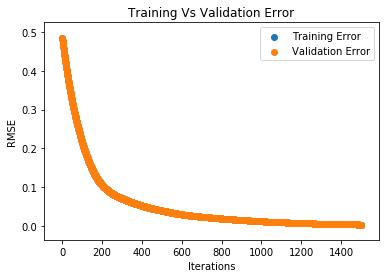

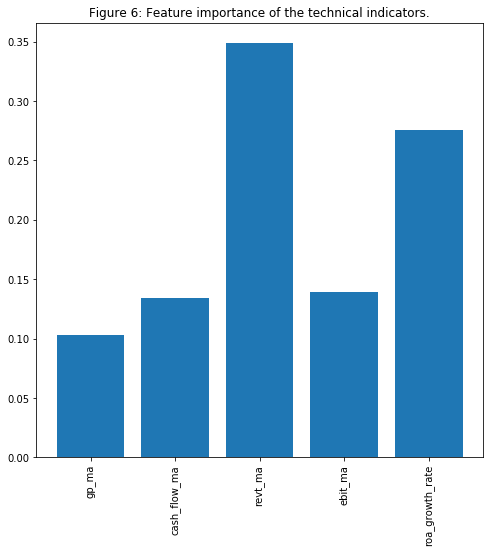

 95%|█████████▍| 481/507 [10:46<00:22,  1.16it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:45:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


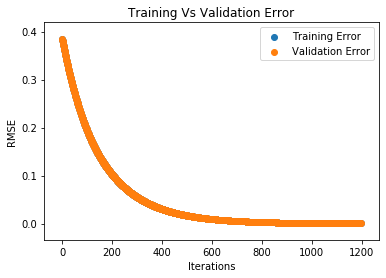

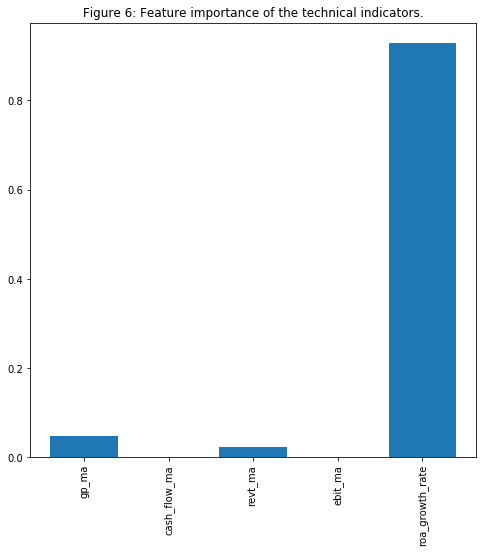

 95%|█████████▌| 483/507 [10:48<00:21,  1.12it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:45:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


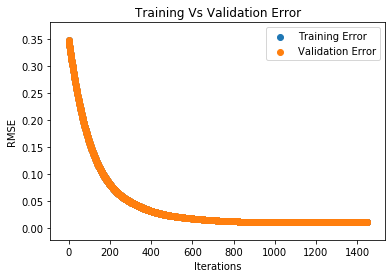

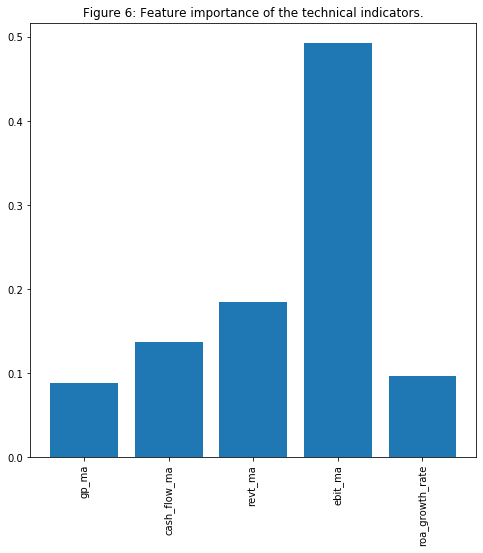

 96%|█████████▌| 485/507 [10:50<00:21,  1.05it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1


 96%|█████████▌| 487/507 [10:51<00:16,  1.19it/s]

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


[15:45:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


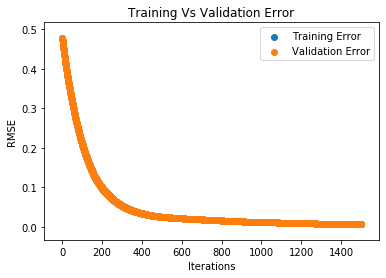

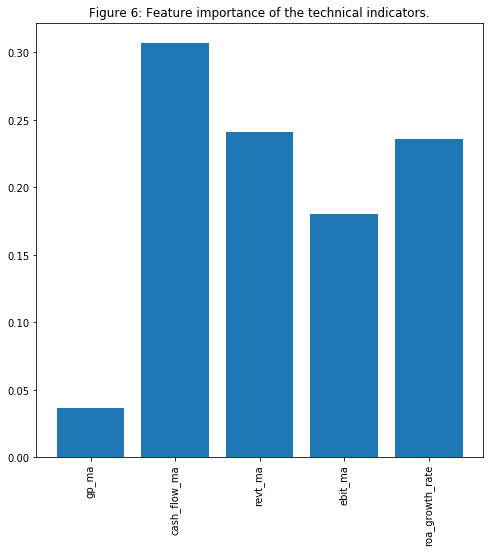

 96%|█████████▋| 488/507 [10:54<00:26,  1.37s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


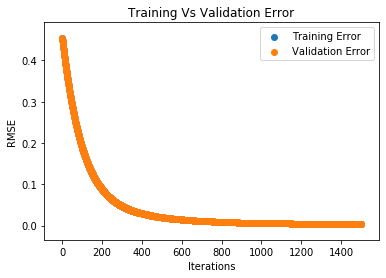

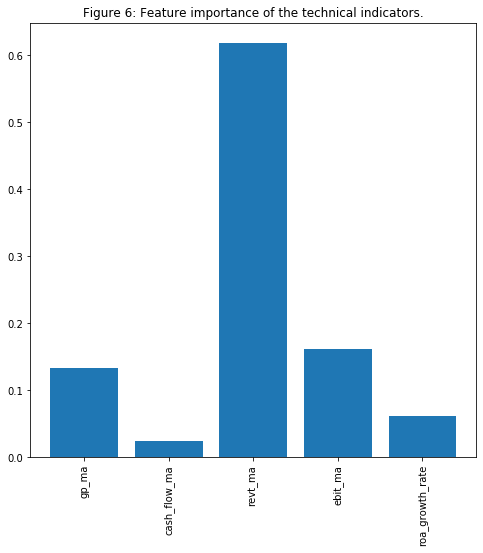

 97%|█████████▋| 490/507 [10:56<00:22,  1.31s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:46:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


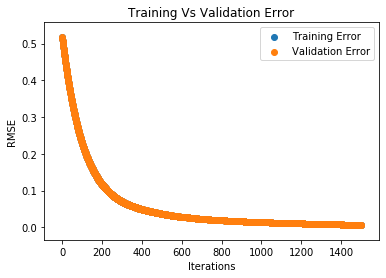

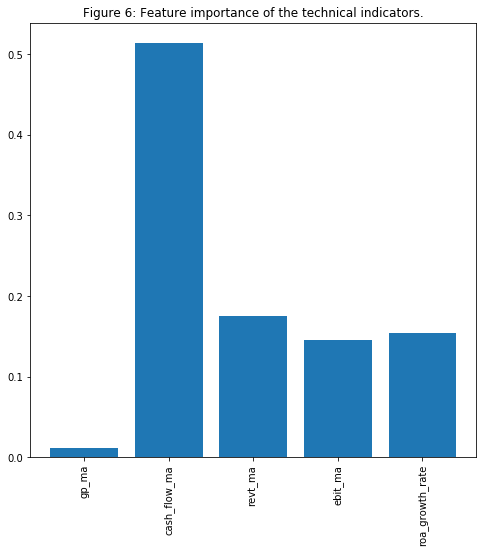

 97%|█████████▋| 491/507 [10:58<00:24,  1.56s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:46:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


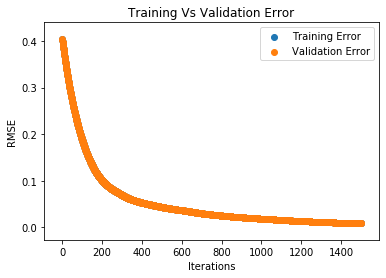

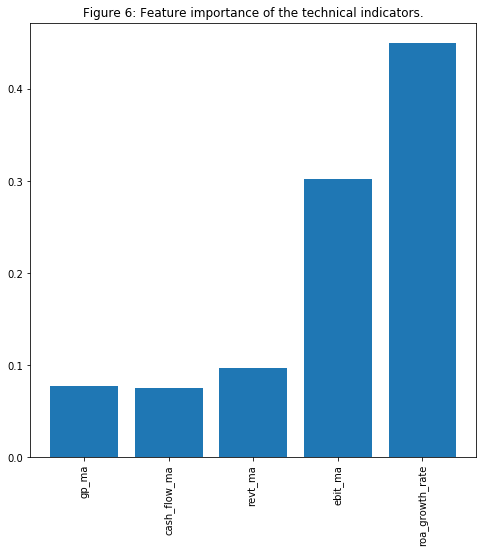

 97%|█████████▋| 492/507 [11:01<00:28,  1.87s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:46:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


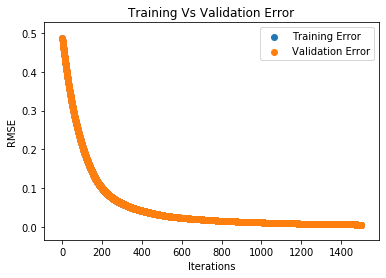

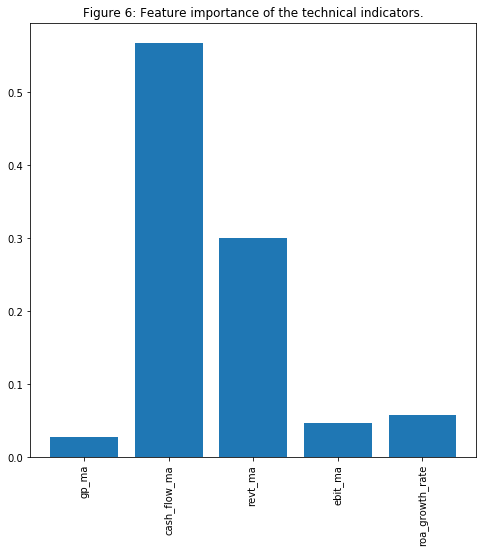

 97%|█████████▋| 493/507 [11:03<00:29,  2.07s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


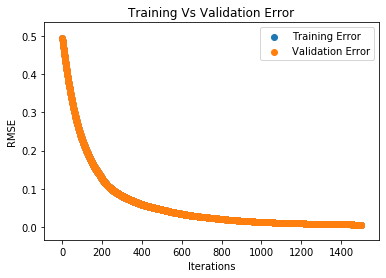

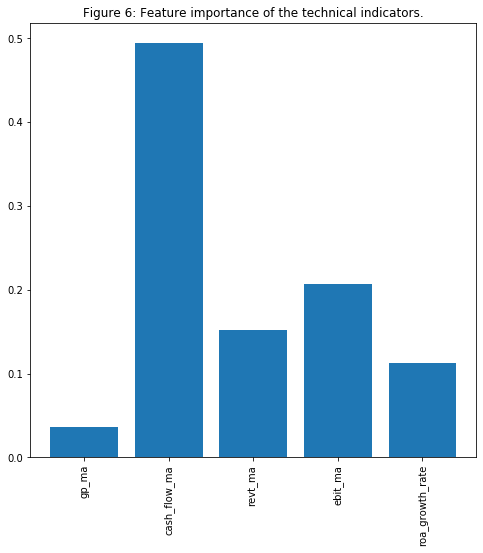

 97%|█████████▋| 494/507 [11:05<00:27,  2.11s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:46:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


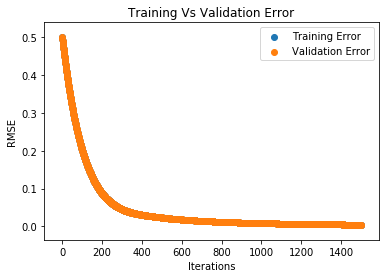

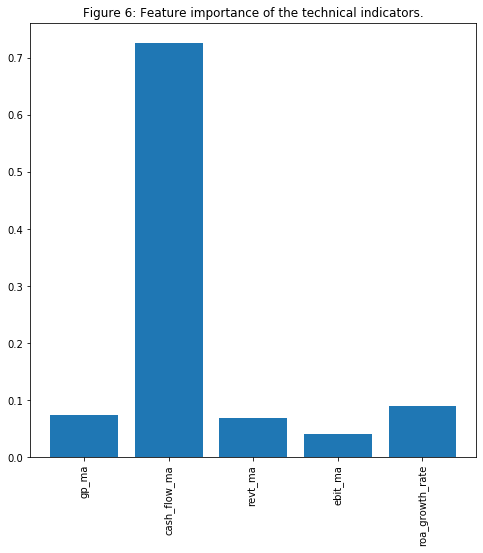

 98%|█████████▊| 498/507 [11:08<00:13,  1.51s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
1
1
[15:46:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


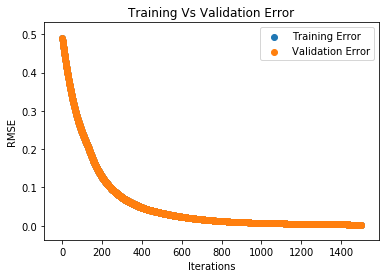

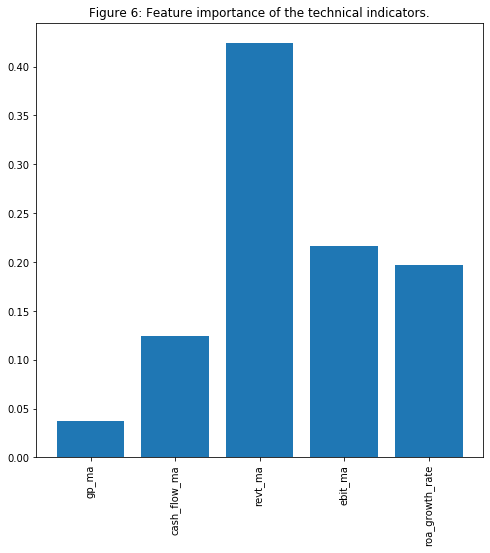

 98%|█████████▊| 499/507 [11:10<00:13,  1.73s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1
[15:46:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


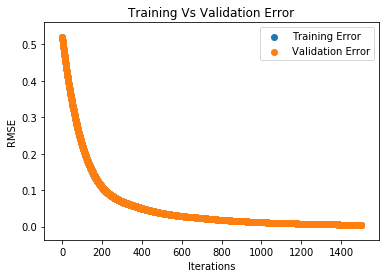

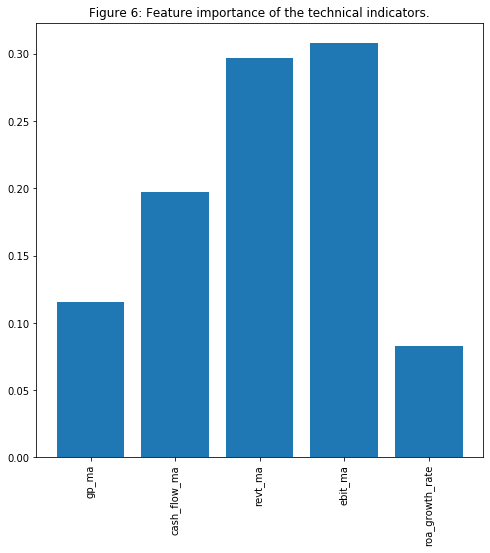

 99%|█████████▉| 501/507 [11:13<00:09,  1.61s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


1


 99%|█████████▉| 503/507 [11:13<00:05,  1.25s/it]

1
[15:46:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


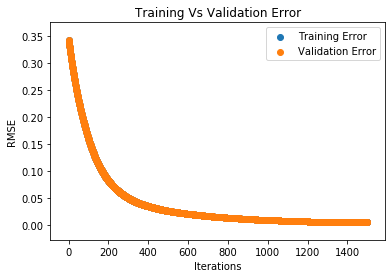

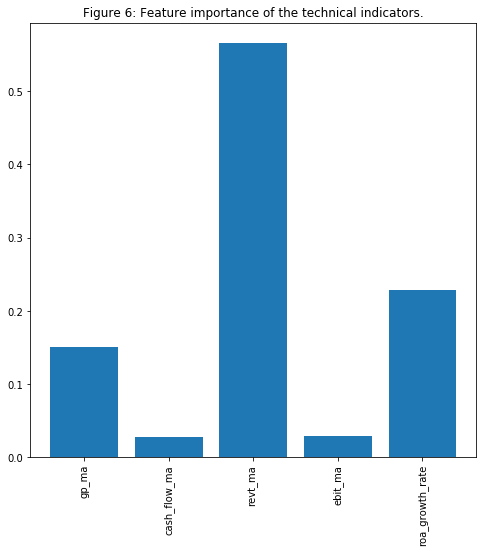

 99%|█████████▉| 504/507 [11:16<00:04,  1.61s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:46:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


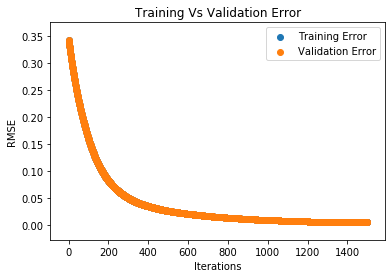

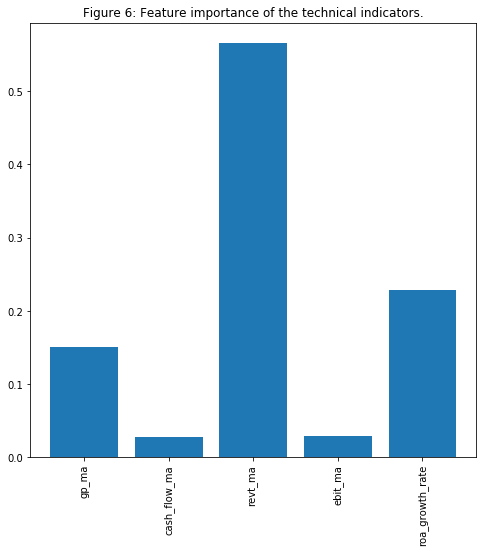

100%|█████████▉| 505/507 [11:17<00:03,  1.54s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


[15:46:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


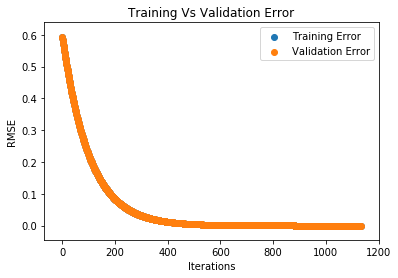

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


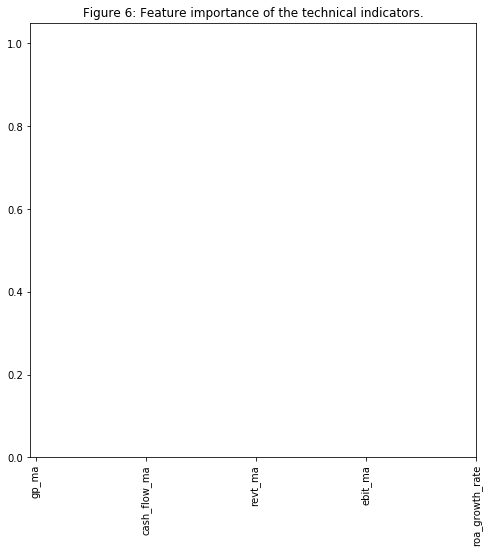

100%|██████████| 507/507 [11:19<00:00,  1.34s/it]

1
['ANF', 'ATV', 'AOBC', 'BTOW3', 'BAJAJ-AUTO', 'BATAINDIA', 'BOSCHLTD', 'CTRC', 'CAAS', '601888', 'COST', 'GRDZF', 'HEROMOTOCO', 'HSW', 'JUBLFOOD', 'KROT3', 'RENT3', 'LAME4', 'LREN3', 'LOOK', 'MGLU3', 'M&M', 'MARUTI', '333', 'NXT', 'OTB', 'PSON', 'SHALF', 'TATAMOTORS', 'TM', 'WTB', 'ABEV3', 'CRFB3', 'BRFS3', 'PCAR4', 'GODREJAGRO', 'GODREJCP', 'HINDUNILVR', 'ITC', 'JBSS3', 'JSDA', '600519', 'MDIA3', 'MNST', 'NATU3', 'NESTLEIND', 'RADL3', 'RB.', 'SBRY', 'ULVR', '858', 'WYN', 'CSUNY', 'COALINDIA', 'CSAN3', 'ET', 'GLEN', 'LAM', 'ONGC', 'BRDT3', 'PETR4', 'PETR3', 'RELIANCE', 'RDSA', 'SJVN', 'SUN', 'TLW', 'UGPA3', 'ADCB', 'ALDAR', 'AV.', 'AXISBANK', 'B3SA3', 'BPAC11', 'BBAS3', 'SANB11', 'BBDC3', 'BBDC4', '2142', 'BBSE3', 'BRML3', 'CWB', '939', '2', '600007', 'CIEL3', 'C', 'CLIG', 'CS', 'DIB', 'EMAARDEV', 'EMAARMALLS', 'EMAAR', 'EXPN', 'FAB', 'GBCI', 'HDFCBANK', 'HDFC', 'HSBA', 'ICICIBANK', 'IRBR3', 'ITUB4', 'ITSA4', 'LLOY', 'MFSL', 'MCO', 'MULT3', 'ONB', '2318', 'PSSA3', 'PSA', 'RECLTD', 'S

In [12]:
df_stock_list = pd.read_csv("/gdrive/My Drive/Blair/10/KWHS2019/KWHS_list.csv")
stocks = df_stock_list['TICKER']

no_data = []
weights = []
for comp in tqdm(stocks):
    error = 0
    try: 
        # get_Weight(comp)
        weights.append(get_Weight(comp))
    except:
        error += 1
        no_data.append(comp)
        print(error)
print(no_data)

In [29]:
a = np.array(weights)
mask = np.all(np.isnan(a) | np.equal(a, 0), axis=1)
a[~mask].shape

results = np.mean(a[~mask], axis = 0)

for i in range(4):
    items = ["gross profit", "cash_flow", "revenue growth", "ebit", "roa"]
    print("{} = {}".format(items[i], results[i]))

array([0.18654718, 0.18049775, 0.1826339 , 0.11940605, 0.33091513])

In [0]:
# gross profit = 0.18654718, 
# cash_flow = 0.18049775, 
# revenue growth = 0.1826339 , 
# ebit = 0.11940605, 
# roa = 0.33091513 